In [1]:


import astropy
print('astropy',astropy.__version__ )
from spectral_cube import SpectralCube      # This is a handy package for working with 3D data cubes

from astropy.coordinates import SkyCoord
from reproject import reproject_interp      
from reproject.mosaicking import find_optimal_celestial_wcs 
import regions
import reproject
print('reproject',reproject.__version__)
import spectral_cube
print('spectral_cube',spectral_cube.__version__)
import numpy as np                          
import pylab                                
import matplotlib 
import matplotlib.gridspec as gridspec                                                                                             
import scipy
import astropy.io.fits as fits                                                          
from astropy.wcs import WCS                 
from astropy import units as u              
import pyspeckit as psk   
import astrodendro
import matplotlib.colors as colors
from matplotlib import pyplot as plt
# Suppress warnings we don't care about:
import sys
import gc

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")
%matplotlib inline
#%matplotlib notebook
from astrodendro.analysis import PPVStatistic
from astrodendro.analysis import PPStatistic
from matplotlib.patches import Ellipse
#%matplotlib widget

astropy 5.1.dev153+gb740594dc
reproject 0.8
spectral_cube 0.6.1.dev22+g003ef16


Clean Notebook for CMZ

Featuring:

HCO+ 4-3
HCN 4-3
H13CN 4-3
H13CO+ J4-3

Part 1: Updates

Part 2: File Reads, Integrated Maps

Part 3: Image Ratios

Part 4: Channel Maps

Part 5: PV Plots

Part 6: Reporojection

Part 7: Spectra

Part 8: Dendograms

# Part 1: Updates

!pip install git+https://github.com/astropy/astropy
!pip install reproject
!pip install git+https://github.com/radio-astro-tools/spectral-cube.git
!pip install pyspeckit
!pip install regions
!pip install astrodendro
!pip install wcsaxes
!pip install ipympl

In [2]:
#path = 'CMZ_3mm_HCO+.fits'
path = 'CMZ_3mm_H13CO+.fits'



#path = "HC3N_11_10.fits"

scP = SpectralCube.read(path)
sc = scP.with_spectral_unit(u.km/u.s,velocity_convention="radio")
scW = sc.wcs[:][:][0]

raDP1 = scW.pixel_to_world(0,0)
raDP2 = scW.pixel_to_world(1,1)

a=(raDP1)
b=(raDP2)
print(a)
print(b)

vel,NA,na = sc.world[:,0,0]

#too accurate?
#50 mili arcseconds

header5 = sc.header
beam5_a = header5["BMAJ"]*3600.0 # beam sizes in arcseconds
beam5_b = header5["BMIN"]*3600.0
pixel5 = header5["CDELT1"] * (-1)*3600.0

#print(sc.statistics())
print(header5)

print(abs(header5["CDELT3"]))

<SkyCoord (Galactic): (l, b) in deg
    (1.81512418, -0.31499077)>
<SkyCoord (Galactic): (l, b) in deg
    (1.81178957, -0.31165745)>
SIMPLE  =                    T  /                                               BITPIX  =                  -32  /                                               NAXIS   =                    3                                                  NAXIS1  =                  765                                                  NAXIS2  =                  165                                                  NAXIS3  =                  323                                                  EXTEND  =                    T  /                                               BSCALE  =    1.00000000000E+00  /                                               BZERO   =    0.00000000000E+00  /                                               BLANK   =                   -1  /                                               BUNIT   = 'K       '  /                                           

# Part 2: File Reads, Moment Maps

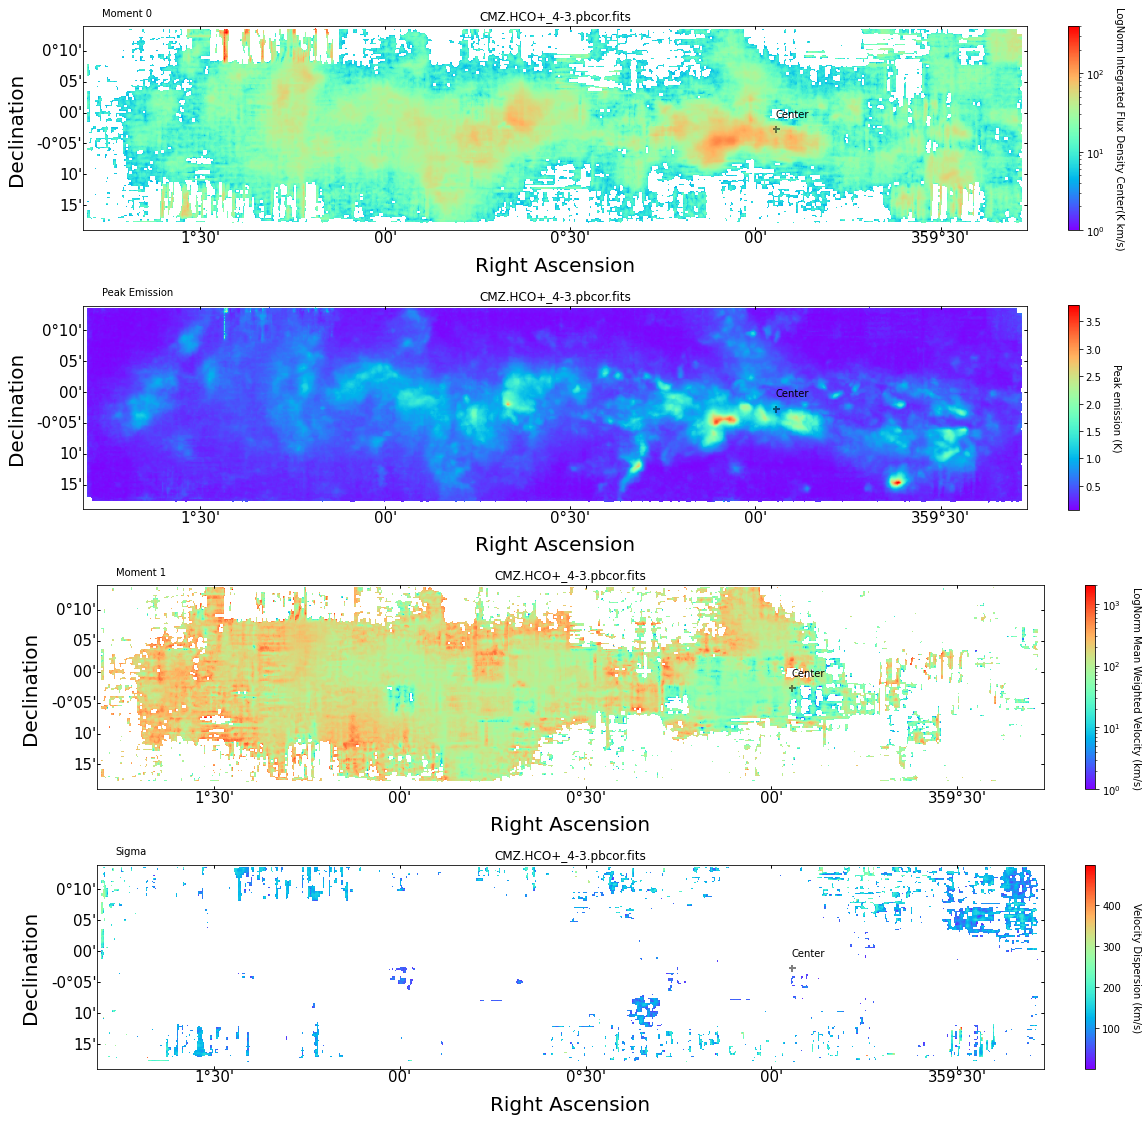

In [71]:
#HCO+ 4-3

path = 'CMZ_3mm_HCO+.fits'

cube = SpectralCube.read(path) #Load the important axes
cheader = fits.getheader(path)  
w1 = WCS(cheader) 
w1 = w1.dropaxis(2)#Get rid of the different slices

cube.allow_huge_operations=True


###### Make zoomed in images
# ex: c = SkyCoord('00h42m30s', '+41d12m00s', frame='icrs')
#Center: 359.94487501 -00.04391769 galcoord, ref: http://simbad.u-strasbg.fr/simbad/sim-id?Ident=Galactic+Centre
center = SkyCoord(l=359.94487501*u.degree,b=-00.04391769*u.degree, frame='galactic')


sc = SpectralCube.read(path)

sc_kms = sc.with_spectral_unit(u.km/u.s,velocity_convention="radio") # change from frequency to velocity

SCP = sc_kms.spectral_slab(-800. *u.km / u.s, 800. *u.km / u.s)  # Extract a subset of the velocities
subcube = SCP.to(u.K)
subcube.allow_huge_operations=True


subcube.allow_huge_operations=True
moment_0_sub  = subcube.moment(order=0,how='slice')            # Calculate the Moment 0 map 
max_map_sub   = subcube.apply_numpy_function(np.nanmax,axis=0) # Calculate the Maximum map 
moment_1_sub  = subcube.moment(order=1,how='slice')            # Calculate the Moment 1 map 
sigma_map_sub = subcube.linewidth_sigma(how='slice')           # Calculate the velocity dispersion map 


#Find Noise 
scW = subcube.wcs[:][:][0]
Np1 = SkyCoord('01d31m00s', '00d00m00s', frame='galactic')#These are away from the sources
Np2 = SkyCoord('01d30m00s', '00d10m00s', frame='galactic')
NraDP1 = [int(scW.world_to_pixel(Np1)[0]),int(scW.world_to_pixel(Np1)[1])]
NraDP2 = [int(scW.world_to_pixel(Np2)[0]),int(scW.world_to_pixel(Np2)[1])]
Nsc1 = subcube[0:int(len(subcube)/8),NraDP1[1]:NraDP2[1],NraDP1[0]:NraDP2[0]] # Make a subcube away from the signals
#Find StandardDev of this noise cube
N1kms = Nsc1.with_spectral_unit(u.km/u.s,velocity_convention="radio")
N1kms.allow_huge_operations=True
N1Kkma = N1kms.to(u.K)
N1Mom  = N1Kkma.moment(order=0,how='slice')    # Calculate the first Moment 0 map 
m1=N1Mom.std()

badpixS = pylab.where(abs(moment_0_sub)<m1*3)                 # Get ready to mask the data based on moment map
#
moment_0_sub.hdu.data[badpixS] = np.nan                          # Mask the moment 1 map
moment_1_sub.hdu.data[badpixS] = np.nan                          # Mask the moment 1 map
sigma_map_sub.hdu.data[badpixS] = np.nan                         # Mask the velocity dispersion map

scWCS = subcube.wcs[:][:][0]


########


fig1 = pylab.figure(1,figsize=(15,15))


######Moment 0 and Max map

ax3 = pylab.subplot(4,1,1,projection=scWCS) 
RA = ax3.coords[0]                                                                  # 
Dec = ax3.coords[1]
im3 = pylab.imshow(moment_0_sub.hdu.data,cmap='rainbow',norm=colors.LogNorm(vmin=1))
y,x = [int(scWCS.world_to_pixel(center)[0]),int(scWCS.world_to_pixel(center)[1])]
pylab.plot(y,x,'+',ms=7,mec='black',mfc='black',mew=2,alpha=.5)
pylab.annotate("Center",(y,x+10))
RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3) 
RA.set_ticklabel(exclude_overlapping=True) 
Dec.set_ticklabel(exclude_overlapping=True)                                                                                     
pylab.xlabel('Right Ascension',fontsize=20,labelpad=1)                               
pylab.ylabel('Declination',fontsize=20,labelpad=1)
ax3.tick_params(axis = 'both', which = 'major', labelsize = 15)    
cb=pylab.colorbar(im3,fraction=0.046,pad=0.04)                                     
cb.set_label(label='LogNorm Integrated Flux Density Center(K km/s)',fontsize=10,rotation=270,labelpad=20) 
cb.ax.tick_params(which = 'major', labelsize = 10)   
pylab.annotate(s='Moment 0',fontsize=10,xy=(0.02,1.05),xycoords="axes fraction")  


ax4 = pylab.subplot(4,1,2, projection=scWCS)
RA = ax4.coords[0]                                                                  # 
Dec = ax4.coords[1]
im4=pylab.imshow(max_map_sub.data,cmap='rainbow')
y,x = [int(scWCS.world_to_pixel(center)[0]),int(scWCS.world_to_pixel(center)[1])]
pylab.plot(y,x,'+',ms=7,mec='black',mfc='black',mew=2,alpha=.5)
pylab.annotate("Center",(y,x+10))
RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3) 
RA.set_ticklabel(exclude_overlapping=True) 
Dec.set_ticklabel(exclude_overlapping=True)                                                                                     
pylab.xlabel('Right Ascension',fontsize=20,labelpad=1)                               
pylab.ylabel('Declination',fontsize=20,labelpad=1) 
ax4.tick_params(axis = 'both', which = 'major', labelsize = 15)    
cb=pylab.colorbar(im4,fraction=0.046,pad=0.04)                                      
cb.set_label(label='Peak emission (K)',fontsize=10,rotation=270,labelpad=20) 
cb.ax.tick_params(which = 'major', labelsize = 10)  
pylab.annotate(s='Peak Emission',fontsize=10,xy=(0.02,1.05),xycoords="axes fraction")  


pylab.tight_layout(w_pad=10,h_pad=5)



#########Moment 1 and Sigma


ax7 = pylab.subplot(4,1,3,projection=scWCS) 
RA = ax7.coords[0]                                                                  # 
Dec = ax7.coords[1]
im7 = pylab.imshow(moment_1_sub.hdu.data,cmap='rainbow',norm=colors.LogNorm(vmin=1))
y,x = [int(scWCS.world_to_pixel(center)[0]),int(scWCS.world_to_pixel(center)[1])]
pylab.plot(y,x,'+',ms=7,mec='black',mfc='black',mew=2,alpha=.5)
pylab.annotate("Center",(y,x+10))
RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3) 
RA.set_ticklabel(exclude_overlapping=True) 
Dec.set_ticklabel(exclude_overlapping=True)                                                                                     
pylab.xlabel('Right Ascension',fontsize=20,labelpad=1)                               
pylab.ylabel('Declination',fontsize=20,labelpad=1)
ax7.tick_params(axis = 'both', which = 'major', labelsize = 15)    
cb=pylab.colorbar(im7,fraction=0.03,pad=0.04)                                    
cb.set_label(label='LogNorm Mean Weighted Velocity (km/s)',fontsize=10,rotation=270,labelpad=20) 
cb.ax.tick_params(which = 'major', labelsize = 10)   
pylab.annotate(s='Moment 1',fontsize=10,xy=(0.02,1.05),xycoords="axes fraction")  


ax8 = pylab.subplot(4,1,4, projection=scWCS)
RA = ax8.coords[0]                                                                  # 
Dec = ax8.coords[1]
im8=pylab.imshow(sigma_map_sub.hdu.data,cmap='rainbow')
y,x = [int(scWCS.world_to_pixel(center)[0]),int(scWCS.world_to_pixel(center)[1])]
pylab.plot(y,x,'+',ms=7,mec='black',mfc='black',mew=2,alpha=.5)
pylab.annotate("Center",(y,x+10))
RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3) 
RA.set_ticklabel(exclude_overlapping=True) 
Dec.set_ticklabel(exclude_overlapping=True)                                                                                     
pylab.xlabel('Right Ascension',fontsize=20,labelpad=1)                               
pylab.ylabel('Declination',fontsize=20,labelpad=1) 
ax8.tick_params(axis = 'both', which = 'major', labelsize = 15)    
cb=pylab.colorbar(im8,fraction=0.03,pad=0.04)                                      
cb.set_label(label='Velocity Dispersion (km/s)',fontsize=10,rotation=270,labelpad=20) 
cb.ax.tick_params(which = 'major', labelsize = 10)  
pylab.annotate(s='Sigma',fontsize=10,xy=(0.02,1.05),xycoords="axes fraction") 
pylab.tight_layout(w_pad=10,h_pad=5)


ax3.set_aspect(aspect=1)
ax4.set_aspect(aspect=1)
ax7.set_aspect(aspect=1)
ax8.set_aspect(aspect=1)

ax3.set_title("CMZ.HCO+_4-3.pbcor.fits")
ax4.set_title("CMZ.HCO+_4-3.pbcor.fits")
ax7.set_title("CMZ.HCO+_4-3.pbcor.fits")
ax8.set_title("CMZ.HCO+_4-3.pbcor.fits")

fig1.savefig(bbox_inches='tight',fname="CMZ_HCO+_4-3_Integrated_Full_Note.jpeg")



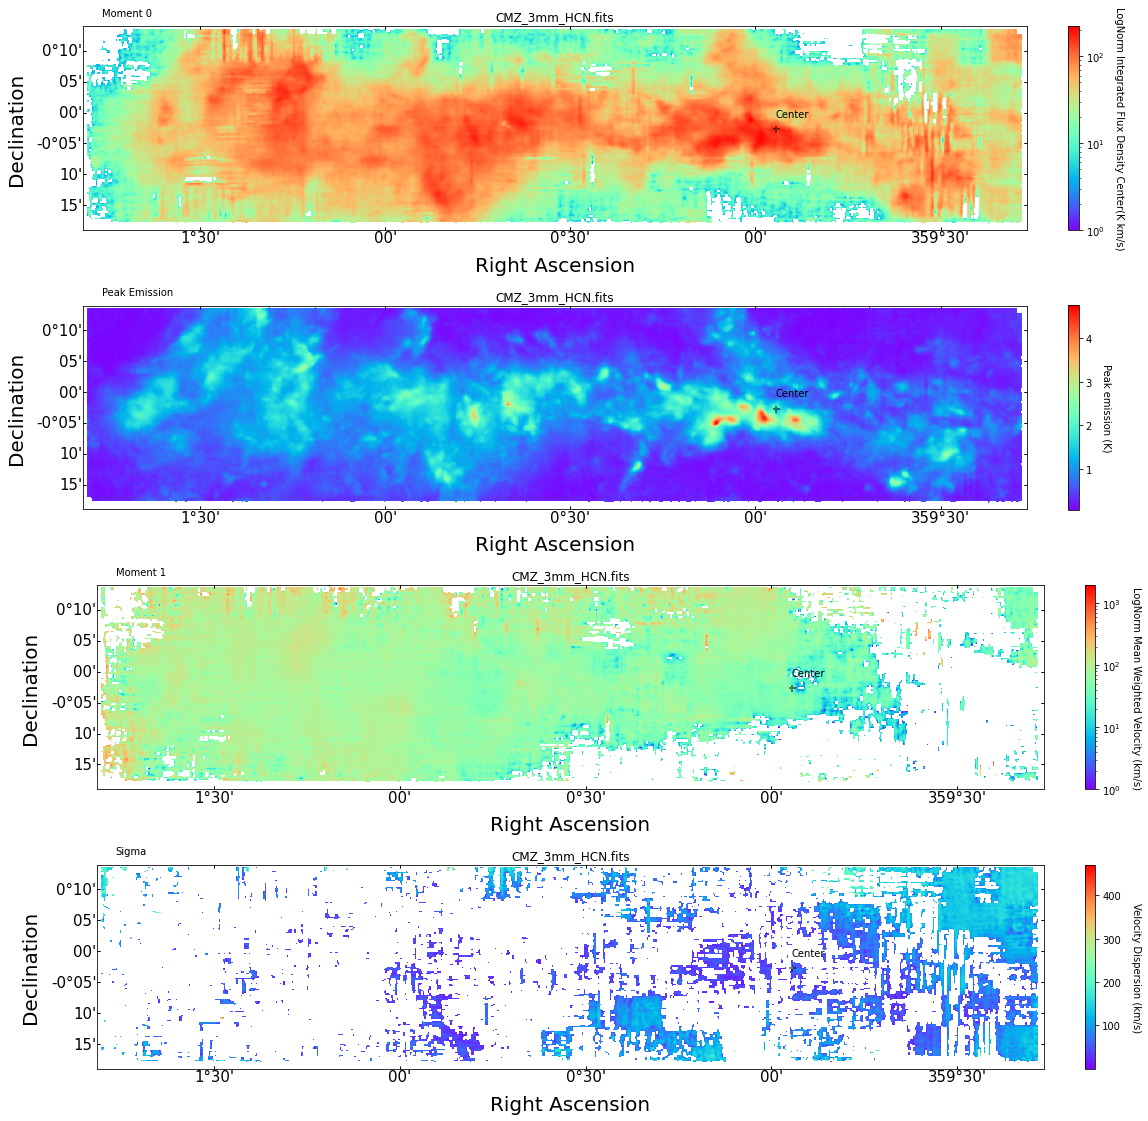

In [72]:
#HCN 4-3


path = 'CMZ_3mm_HCN.fits'

cube = SpectralCube.read(path) #Load the important axes
cheader = fits.getheader(path)  
w1 = WCS(cheader) 
w1 = w1.dropaxis(2)#Get rid of the different slices

cube.allow_huge_operations=True


###### Make zoomed in images
# ex: c = SkyCoord('00h42m30s', '+41d12m00s', frame='icrs')
#Center: 359.94487501 -00.04391769 galcoord, ref: http://simbad.u-strasbg.fr/simbad/sim-id?Ident=Galactic+Centre
center = SkyCoord(l=359.94487501*u.degree,b=-00.04391769*u.degree, frame='galactic')


sc = SpectralCube.read(path)

sc_kms = sc.with_spectral_unit(u.km/u.s,velocity_convention="radio") # change from frequency to velocity

SCP = sc_kms.spectral_slab(-800. *u.km / u.s, 800. *u.km / u.s)  # Extract a subset of the velocities
subcube = SCP.to(u.K)
subcube.allow_huge_operations=True
moment_0_sub  = subcube.moment(order=0,how='slice')            # Calculate the Moment 0 map 
max_map_sub   = subcube.apply_numpy_function(np.nanmax,axis=0) # Calculate the Maximum map 
moment_1_sub  = subcube.moment(order=1,how='slice')            # Calculate the Moment 1 map 
sigma_map_sub = subcube.linewidth_sigma(how='slice')           # Calculate the velocity dispersion map 


#Find Noise 
scW = subcube.wcs[:][:][0]
Np1 = SkyCoord('01d31m00s', '00d00m00s', frame='galactic')#These are away from the sources
Np2 = SkyCoord('01d30m00s', '00d10m00s', frame='galactic')
NraDP1 = [int(scW.world_to_pixel(Np1)[0]),int(scW.world_to_pixel(Np1)[1])]
NraDP2 = [int(scW.world_to_pixel(Np2)[0]),int(scW.world_to_pixel(Np2)[1])]
Nsc1 = subcube[0:int(len(subcube)/8),NraDP1[1]:NraDP2[1],NraDP1[0]:NraDP2[0]] # Make a subcube away from the signals
#Find StandardDev of this noise cube
N1kms = Nsc1.with_spectral_unit(u.km/u.s,velocity_convention="radio")
N1kms.allow_huge_operations=True
N1Kkma = N1kms.to(u.K)
N1Mom  = N1Kkma.moment(order=0,how='slice')    # Calculate the first Moment 0 map 
m1=N1Mom.std()

badpixS = pylab.where(abs(moment_0_sub)<m1*3)                 # Get ready to mask the data based on moment map
#
moment_0_sub.hdu.data[badpixS] = np.nan                          # Mask the moment 1 map
moment_1_sub.hdu.data[badpixS] = np.nan                          # Mask the moment 1 map
sigma_map_sub.hdu.data[badpixS] = np.nan                         # Mask the velocity dispersion map

scWCS = subcube.wcs[:][:][0]


########


fig1 = pylab.figure(1,figsize=(15,15))


######Moment 0 and Max map

ax3 = pylab.subplot(4,1,1,projection=scWCS) 
RA = ax3.coords[0]                                                                  # 
Dec = ax3.coords[1]
im3 = pylab.imshow(moment_0_sub.hdu.data,cmap='rainbow',norm=colors.LogNorm(vmin=1))
y,x = [int(scWCS.world_to_pixel(center)[0]),int(scWCS.world_to_pixel(center)[1])]
pylab.plot(y,x,'+',ms=7,mec='black',mfc='black',mew=2,alpha=.5)
pylab.annotate("Center",(y,x+10))
RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3) 
RA.set_ticklabel(exclude_overlapping=True) 
Dec.set_ticklabel(exclude_overlapping=True)                                                                                     
pylab.xlabel('Right Ascension',fontsize=20,labelpad=1)                               
pylab.ylabel('Declination',fontsize=20,labelpad=1)
ax3.tick_params(axis = 'both', which = 'major', labelsize = 15)    
cb=pylab.colorbar(im3,fraction=0.046,pad=0.04)                                     
cb.set_label(label='LogNorm Integrated Flux Density Center(K km/s)',fontsize=10,rotation=270,labelpad=20) 
cb.ax.tick_params(which = 'major', labelsize = 10)   
pylab.annotate(s='Moment 0',fontsize=10,xy=(0.02,1.05),xycoords="axes fraction")  


ax4 = pylab.subplot(4,1,2, projection=scWCS)
RA = ax4.coords[0]                                                                  # 
Dec = ax4.coords[1]
im4=pylab.imshow(max_map_sub.data,cmap='rainbow')
y,x = [int(scWCS.world_to_pixel(center)[0]),int(scWCS.world_to_pixel(center)[1])]
pylab.plot(y,x,'+',ms=7,mec='black',mfc='black',mew=2,alpha=.5)
pylab.annotate("Center",(y,x+10))
RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3) 
RA.set_ticklabel(exclude_overlapping=True) 
Dec.set_ticklabel(exclude_overlapping=True)                                                                                     
pylab.xlabel('Right Ascension',fontsize=20,labelpad=1)                               
pylab.ylabel('Declination',fontsize=20,labelpad=1) 
ax4.tick_params(axis = 'both', which = 'major', labelsize = 15)    
cb=pylab.colorbar(im4,fraction=0.046,pad=0.04)                                      
cb.set_label(label='Peak emission (K)',fontsize=10,rotation=270,labelpad=20) 
cb.ax.tick_params(which = 'major', labelsize = 10)  
pylab.annotate(s='Peak Emission',fontsize=10,xy=(0.02,1.05),xycoords="axes fraction")  


pylab.tight_layout(w_pad=10,h_pad=5)



#########Moment 1 and Sigma


ax7 = pylab.subplot(4,1,3,projection=scWCS) 
RA = ax7.coords[0]                                                                  # 
Dec = ax7.coords[1]
im7 = pylab.imshow(moment_1_sub.hdu.data,cmap='rainbow',norm=colors.LogNorm(vmin=1))
y,x = [int(scWCS.world_to_pixel(center)[0]),int(scWCS.world_to_pixel(center)[1])]
pylab.plot(y,x,'+',ms=7,mec='black',mfc='black',mew=2,alpha=.5)
pylab.annotate("Center",(y,x+10))
RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3) 
RA.set_ticklabel(exclude_overlapping=True) 
Dec.set_ticklabel(exclude_overlapping=True)                                                                                     
pylab.xlabel('Right Ascension',fontsize=20,labelpad=1)                               
pylab.ylabel('Declination',fontsize=20,labelpad=1)
ax7.tick_params(axis = 'both', which = 'major', labelsize = 15)    
cb=pylab.colorbar(im7,fraction=0.03,pad=0.04)                                    
cb.set_label(label='LogNorm Mean Weighted Velocity (km/s)',fontsize=10,rotation=270,labelpad=20) 
cb.ax.tick_params(which = 'major', labelsize = 10)   
pylab.annotate(s='Moment 1',fontsize=10,xy=(0.02,1.05),xycoords="axes fraction")  


ax8 = pylab.subplot(4,1,4, projection=scWCS)
RA = ax8.coords[0]                                                                  # 
Dec = ax8.coords[1]
im8=pylab.imshow(sigma_map_sub.hdu.data,cmap='rainbow')
y,x = [int(scWCS.world_to_pixel(center)[0]),int(scWCS.world_to_pixel(center)[1])]
pylab.plot(y,x,'+',ms=7,mec='black',mfc='black',mew=2,alpha=.5)
pylab.annotate("Center",(y,x+10))
RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3) 
RA.set_ticklabel(exclude_overlapping=True) 
Dec.set_ticklabel(exclude_overlapping=True)                                                                                     
pylab.xlabel('Right Ascension',fontsize=20,labelpad=1)                               
pylab.ylabel('Declination',fontsize=20,labelpad=1) 
ax8.tick_params(axis = 'both', which = 'major', labelsize = 15)    
cb=pylab.colorbar(im8,fraction=0.03,pad=0.04)                                      
cb.set_label(label='Velocity Dispersion (km/s)',fontsize=10,rotation=270,labelpad=20) 
cb.ax.tick_params(which = 'major', labelsize = 10)  
pylab.annotate(s='Sigma',fontsize=10,xy=(0.02,1.05),xycoords="axes fraction") 
pylab.tight_layout(w_pad=10,h_pad=5)


ax3.set_aspect(aspect=1)
ax4.set_aspect(aspect=1)
ax7.set_aspect(aspect=1)
ax8.set_aspect(aspect=1)

ax3.set_title('CMZ_3mm_HCN.fits')
ax4.set_title("CMZ_3mm_HCN.fits")
ax7.set_title("CMZ_3mm_HCN.fits")
ax8.set_title("CMZ_3mm_HCN.fits")

fig1.savefig(bbox_inches='tight',fname="CMZ_3mm_HCN_4-3_Integrated_Full_Note.jpeg")




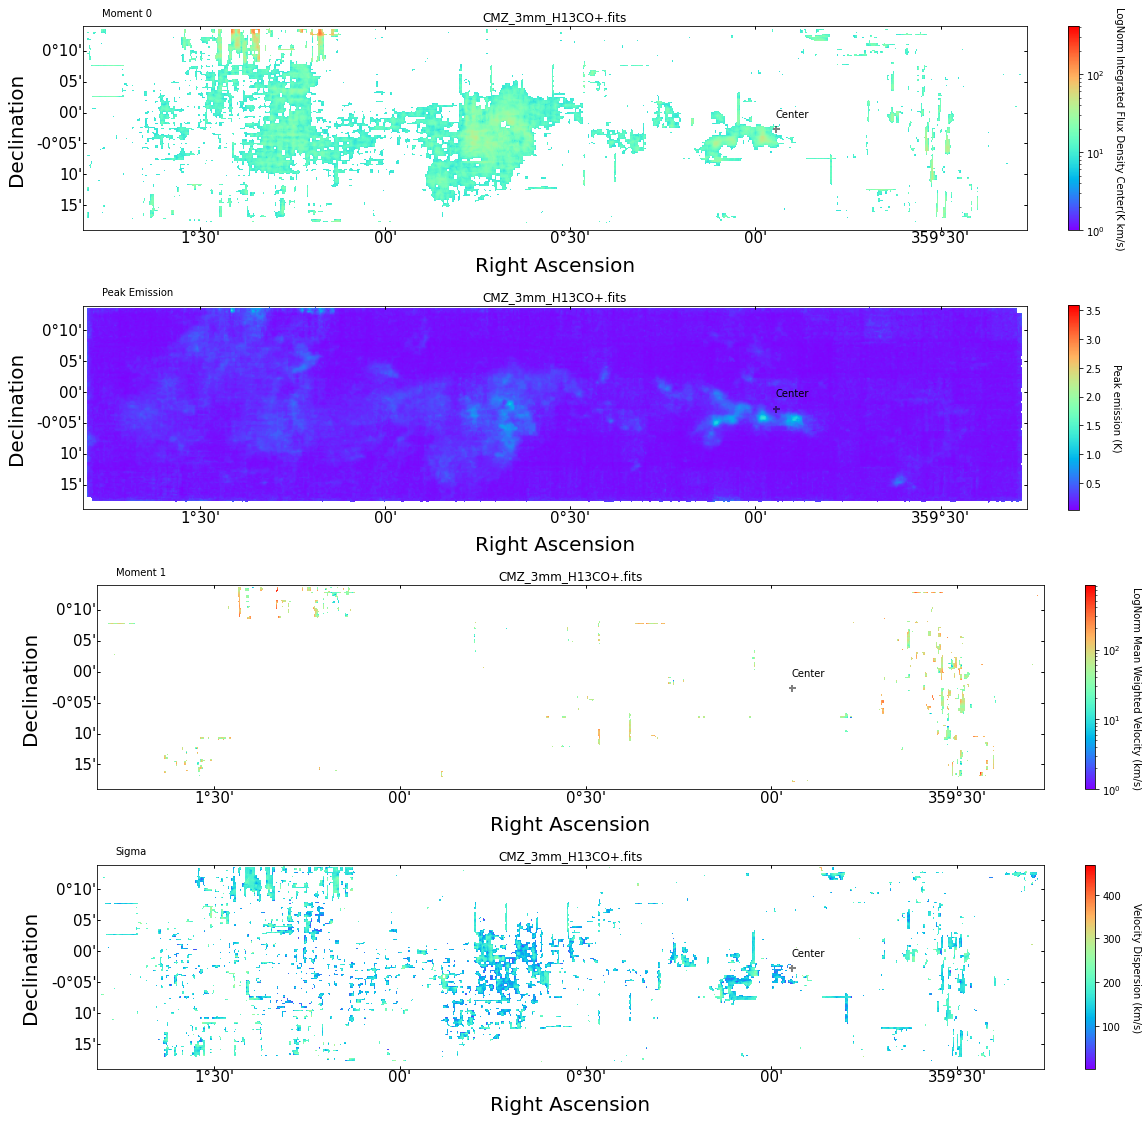

In [73]:
#H13CO+ 4-3


path = 'CMZ_3mm_H13CO+.fits'  

cube = SpectralCube.read(path) #Load the important axes
cheader = fits.getheader(path)  
w1 = WCS(cheader) 
w1 = w1.dropaxis(2)#Get rid of the different slices

cube.allow_huge_operations=True


###### Make zoomed in images
# ex: c = SkyCoord('00h42m30s', '+41d12m00s', frame='icrs')
#Center: 359.94487501 -00.04391769 galcoord, ref: http://simbad.u-strasbg.fr/simbad/sim-id?Ident=Galactic+Centre
center = SkyCoord(l=359.94487501*u.degree,b=-00.04391769*u.degree, frame='galactic')


sc = SpectralCube.read(path)

sc_kms = sc.with_spectral_unit(u.km/u.s,velocity_convention="radio") # change from frequency to velocity

SCP = sc_kms.spectral_slab(-800. *u.km / u.s, 800. *u.km / u.s)  # Extract a subset of the velocities
subcube = SCP.to(u.K)
subcube.allow_huge_operations=True
moment_0_sub  = subcube.moment(order=0,how='slice')            # Calculate the Moment 0 map 
max_map_sub   = subcube.apply_numpy_function(np.nanmax,axis=0) # Calculate the Maximum map 
moment_1_sub  = subcube.moment(order=1,how='slice')            # Calculate the Moment 1 map 
sigma_map_sub = subcube.linewidth_sigma(how='slice')           # Calculate the velocity dispersion map 


#Find Noise 
scW = subcube.wcs[:][:][0]
Np1 = SkyCoord('01d31m00s', '00d00m00s', frame='galactic')#These are away from the sources
Np2 = SkyCoord('01d30m00s', '00d10m00s', frame='galactic')
NraDP1 = [int(scW.world_to_pixel(Np1)[0]),int(scW.world_to_pixel(Np1)[1])]
NraDP2 = [int(scW.world_to_pixel(Np2)[0]),int(scW.world_to_pixel(Np2)[1])]
Nsc1 = subcube[0:int(len(subcube)/8),NraDP1[1]:NraDP2[1],NraDP1[0]:NraDP2[0]] # Make a subcube away from the signals
#Find StandardDev of this noise cube
N1kms = Nsc1.with_spectral_unit(u.km/u.s,velocity_convention="radio")
N1kms.allow_huge_operations=True
N1Kkma = N1kms.to(u.K)
N1Mom  = N1Kkma.moment(order=0,how='slice')    # Calculate the first Moment 0 map 
m1=N1Mom.std()

badpixS = pylab.where(abs(moment_0_sub)<m1*3)                 # Get ready to mask the data based on moment map
#
moment_0_sub.hdu.data[badpixS] = np.nan                          # Mask the moment 1 map
moment_1_sub.hdu.data[badpixS] = np.nan                          # Mask the moment 1 map
sigma_map_sub.hdu.data[badpixS] = np.nan                         # Mask the velocity dispersion map

scWCS = subcube.wcs[:][:][0]


########


fig1 = pylab.figure(1,figsize=(15,15))


######Moment 0 and Max map

ax3 = pylab.subplot(4,1,1,projection=scWCS) 
RA = ax3.coords[0]                                                                  # 
Dec = ax3.coords[1]
im3 = pylab.imshow(moment_0_sub.hdu.data,cmap='rainbow',norm=colors.LogNorm(vmin=1))
y,x = [int(scWCS.world_to_pixel(center)[0]),int(scWCS.world_to_pixel(center)[1])]
pylab.plot(y,x,'+',ms=7,mec='black',mfc='black',mew=2,alpha=.5)
pylab.annotate("Center",(y,x+10))
RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3) 
RA.set_ticklabel(exclude_overlapping=True) 
Dec.set_ticklabel(exclude_overlapping=True)                                                                                     
pylab.xlabel('Right Ascension',fontsize=20,labelpad=1)                               
pylab.ylabel('Declination',fontsize=20,labelpad=1)
ax3.tick_params(axis = 'both', which = 'major', labelsize = 15)    
cb=pylab.colorbar(im3,fraction=0.046,pad=0.04)                                     
cb.set_label(label='LogNorm Integrated Flux Density Center(K km/s)',fontsize=10,rotation=270,labelpad=20) 
cb.ax.tick_params(which = 'major', labelsize = 10)   
pylab.annotate(s='Moment 0',fontsize=10,xy=(0.02,1.05),xycoords="axes fraction")  


ax4 = pylab.subplot(4,1,2, projection=scWCS)
RA = ax4.coords[0]                                                                  # 
Dec = ax4.coords[1]
im4=pylab.imshow(max_map_sub.data,cmap='rainbow')
y,x = [int(scWCS.world_to_pixel(center)[0]),int(scWCS.world_to_pixel(center)[1])]
pylab.plot(y,x,'+',ms=7,mec='black',mfc='black',mew=2,alpha=.5)
pylab.annotate("Center",(y,x+10))
RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3) 
RA.set_ticklabel(exclude_overlapping=True) 
Dec.set_ticklabel(exclude_overlapping=True)                                                                                     
pylab.xlabel('Right Ascension',fontsize=20,labelpad=1)                               
pylab.ylabel('Declination',fontsize=20,labelpad=1) 
ax4.tick_params(axis = 'both', which = 'major', labelsize = 15)    
cb=pylab.colorbar(im4,fraction=0.046,pad=0.04)                                      
cb.set_label(label='Peak emission (K)',fontsize=10,rotation=270,labelpad=20) 
cb.ax.tick_params(which = 'major', labelsize = 10)  
pylab.annotate(s='Peak Emission',fontsize=10,xy=(0.02,1.05),xycoords="axes fraction")  


pylab.tight_layout(w_pad=10,h_pad=5)



#########Moment 1 and Sigma


ax7 = pylab.subplot(4,1,3,projection=scWCS) 
RA = ax7.coords[0]                                                                  # 
Dec = ax7.coords[1]
im7 = pylab.imshow(moment_1_sub.hdu.data,cmap='rainbow',norm=colors.LogNorm(vmin=1))
y,x = [int(scWCS.world_to_pixel(center)[0]),int(scWCS.world_to_pixel(center)[1])]
pylab.plot(y,x,'+',ms=7,mec='black',mfc='black',mew=2,alpha=.5)
pylab.annotate("Center",(y,x+10))
RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3) 
RA.set_ticklabel(exclude_overlapping=True) 
Dec.set_ticklabel(exclude_overlapping=True)                                                                                     
pylab.xlabel('Right Ascension',fontsize=20,labelpad=1)                               
pylab.ylabel('Declination',fontsize=20,labelpad=1)
ax7.tick_params(axis = 'both', which = 'major', labelsize = 15)    
cb=pylab.colorbar(im7,fraction=0.03,pad=0.04)                                    
cb.set_label(label='LogNorm Mean Weighted Velocity (km/s)',fontsize=10,rotation=270,labelpad=20) 
cb.ax.tick_params(which = 'major', labelsize = 10)   
pylab.annotate(s='Moment 1',fontsize=10,xy=(0.02,1.05),xycoords="axes fraction")  


ax8 = pylab.subplot(4,1,4, projection=scWCS)
RA = ax8.coords[0]                                                                  # 
Dec = ax8.coords[1]
im8=pylab.imshow(sigma_map_sub.hdu.data,cmap='rainbow')
y,x = [int(scWCS.world_to_pixel(center)[0]),int(scWCS.world_to_pixel(center)[1])]
pylab.plot(y,x,'+',ms=7,mec='black',mfc='black',mew=2,alpha=.5)
pylab.annotate("Center",(y,x+10))
RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3) 
RA.set_ticklabel(exclude_overlapping=True) 
Dec.set_ticklabel(exclude_overlapping=True)                                                                                     
pylab.xlabel('Right Ascension',fontsize=20,labelpad=1)                               
pylab.ylabel('Declination',fontsize=20,labelpad=1) 
ax8.tick_params(axis = 'both', which = 'major', labelsize = 15)    
cb=pylab.colorbar(im8,fraction=0.03,pad=0.04)                                      
cb.set_label(label='Velocity Dispersion (km/s)',fontsize=10,rotation=270,labelpad=20) 
cb.ax.tick_params(which = 'major', labelsize = 10)  
pylab.annotate(s='Sigma',fontsize=10,xy=(0.02,1.05),xycoords="axes fraction") 
pylab.tight_layout(w_pad=10,h_pad=5)


ax3.set_aspect(aspect=1)
ax4.set_aspect(aspect=1)
ax7.set_aspect(aspect=1)
ax8.set_aspect(aspect=1)

ax3.set_title('CMZ_3mm_H13CO+.fits')
ax4.set_title('CMZ_3mm_H13CO+.fits')
ax7.set_title('CMZ_3mm_H13CO+.fits')
ax8.set_title('CMZ_3mm_H13CO+.fits')

fig1.savefig(bbox_inches='tight',fname="CMZ_3mm_H13COp_4-3_Integrated_Full_Note.jpeg")

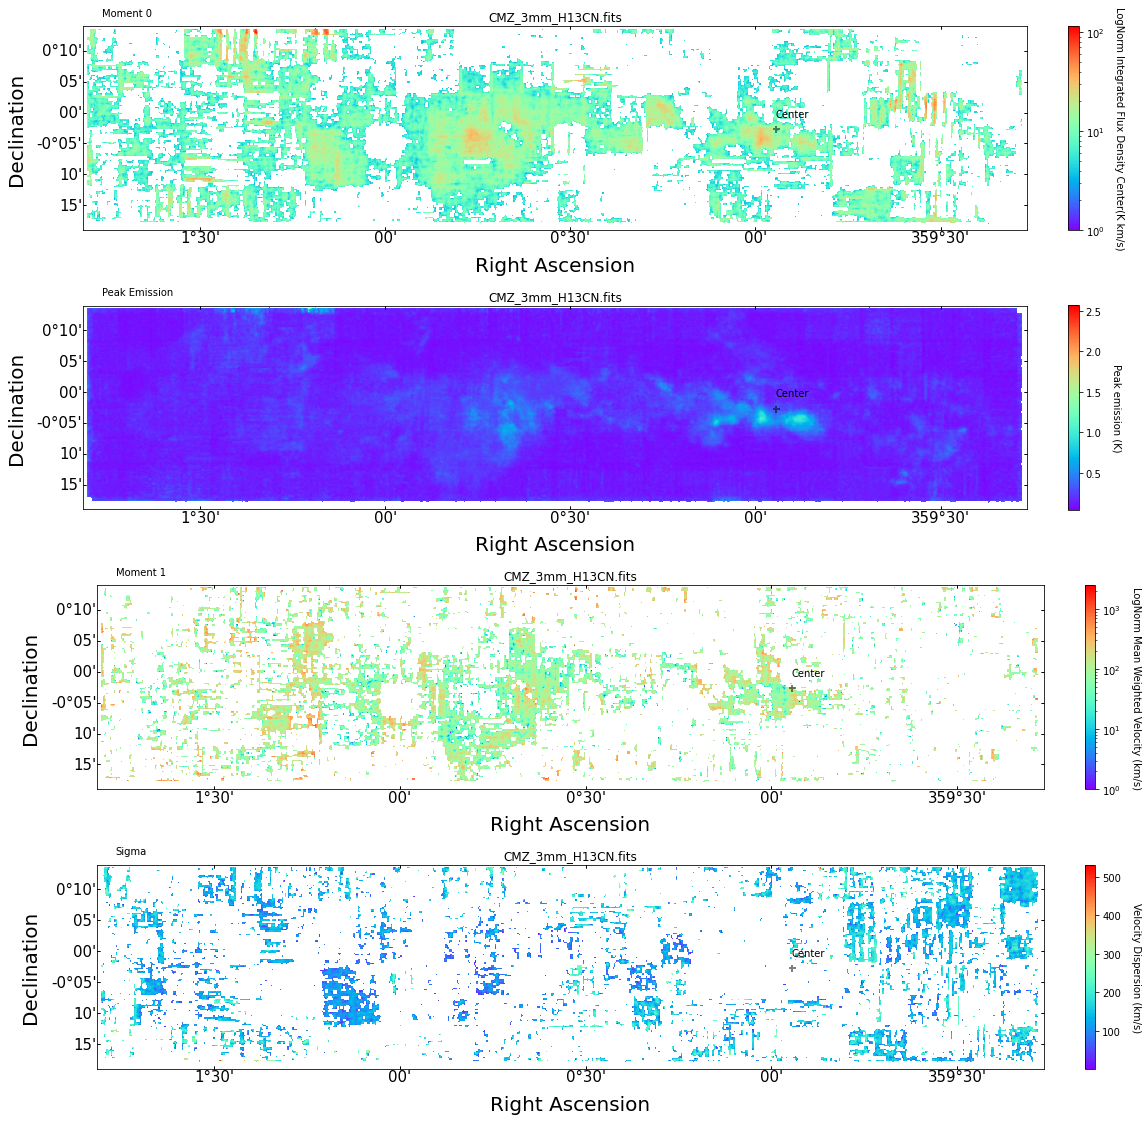

In [74]:
#H13CN_J1-0

path = 'CMZ_3mm_H13CN.fits'

cube = SpectralCube.read(path) #Load the important axes
cheader = fits.getheader(path)  
w1 = WCS(cheader) 
w1 = w1.dropaxis(2)#Get rid of the different slices

cube.allow_huge_operations=True


###### Make zoomed in images
# ex: c = SkyCoord('00h42m30s', '+41d12m00s', frame='icrs')
#Center: 359.94487501 -00.04391769 galcoord, ref: http://simbad.u-strasbg.fr/simbad/sim-id?Ident=Galactic+Centre
center = SkyCoord(l=359.94487501*u.degree,b=-00.04391769*u.degree, frame='galactic')


sc = SpectralCube.read(path)

sc_kms = sc.with_spectral_unit(u.km/u.s,velocity_convention="radio") # change from frequency to velocity

SCP = sc_kms.spectral_slab(-800. *u.km / u.s, 800. *u.km / u.s)  # Extract a subset of the velocities
subcube = SCP.to(u.K)
subcube.allow_huge_operations=True


subcube.allow_huge_operations=True
moment_0_sub  = subcube.moment(order=0,how='slice')            # Calculate the Moment 0 map 
max_map_sub   = subcube.apply_numpy_function(np.nanmax,axis=0) # Calculate the Maximum map 
moment_1_sub  = subcube.moment(order=1,how='slice')            # Calculate the Moment 1 map 
sigma_map_sub = subcube.linewidth_sigma(how='slice')           # Calculate the velocity dispersion map 


#Find Noise 
scW = subcube.wcs[:][:][0]
Np1 = SkyCoord('01d31m00s', '00d00m00s', frame='galactic')#These are away from the sources
Np2 = SkyCoord('01d30m00s', '00d10m00s', frame='galactic')
NraDP1 = [int(scW.world_to_pixel(Np1)[0]),int(scW.world_to_pixel(Np1)[1])]
NraDP2 = [int(scW.world_to_pixel(Np2)[0]),int(scW.world_to_pixel(Np2)[1])]
Nsc1 = subcube[0:int(len(subcube)/8),NraDP1[1]:NraDP2[1],NraDP1[0]:NraDP2[0]] # Make a subcube away from the signals
#Find StandardDev of this noise cube
N1kms = Nsc1.with_spectral_unit(u.km/u.s,velocity_convention="radio")
N1kms.allow_huge_operations=True
N1Kkma = N1kms.to(u.K)
N1Mom  = N1Kkma.moment(order=0,how='slice')    # Calculate the first Moment 0 map 
m1=N1Mom.std()

badpixS = pylab.where(abs(moment_0_sub)<m1*3)                 # Get ready to mask the data based on moment map
#
moment_0_sub.hdu.data[badpixS] = np.nan                          # Mask the moment 1 map
moment_1_sub.hdu.data[badpixS] = np.nan                          # Mask the moment 1 map
sigma_map_sub.hdu.data[badpixS] = np.nan                         # Mask the velocity dispersion map

scWCS = subcube.wcs[:][:][0]


########


fig1 = pylab.figure(1,figsize=(15,15))


######Moment 0 and Max map

ax3 = pylab.subplot(4,1,1,projection=scWCS) 
RA = ax3.coords[0]                                                                  # 
Dec = ax3.coords[1]
im3 = pylab.imshow(moment_0_sub.hdu.data,cmap='rainbow',norm=colors.LogNorm(vmin=1))
y,x = [int(scWCS.world_to_pixel(center)[0]),int(scWCS.world_to_pixel(center)[1])]
pylab.plot(y,x,'+',ms=7,mec='black',mfc='black',mew=2,alpha=.5)
pylab.annotate("Center",(y,x+10))
RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3) 
RA.set_ticklabel(exclude_overlapping=True) 
Dec.set_ticklabel(exclude_overlapping=True)                                                                                     
pylab.xlabel('Right Ascension',fontsize=20,labelpad=1)                               
pylab.ylabel('Declination',fontsize=20,labelpad=1)
ax3.tick_params(axis = 'both', which = 'major', labelsize = 15)    
cb=pylab.colorbar(im3,fraction=0.046,pad=0.04)                                     
cb.set_label(label='LogNorm Integrated Flux Density Center(K km/s)',fontsize=10,rotation=270,labelpad=20) 
cb.ax.tick_params(which = 'major', labelsize = 10)   
pylab.annotate(s='Moment 0',fontsize=10,xy=(0.02,1.05),xycoords="axes fraction")  


ax4 = pylab.subplot(4,1,2, projection=scWCS)
RA = ax4.coords[0]                                                                  # 
Dec = ax4.coords[1]
im4=pylab.imshow(max_map_sub.data,cmap='rainbow')
y,x = [int(scWCS.world_to_pixel(center)[0]),int(scWCS.world_to_pixel(center)[1])]
pylab.plot(y,x,'+',ms=7,mec='black',mfc='black',mew=2,alpha=.5)
pylab.annotate("Center",(y,x+10))
RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3) 
RA.set_ticklabel(exclude_overlapping=True) 
Dec.set_ticklabel(exclude_overlapping=True)                                                                                     
pylab.xlabel('Right Ascension',fontsize=20,labelpad=1)                               
pylab.ylabel('Declination',fontsize=20,labelpad=1) 
ax4.tick_params(axis = 'both', which = 'major', labelsize = 15)    
cb=pylab.colorbar(im4,fraction=0.046,pad=0.04)                                      
cb.set_label(label='Peak emission (K)',fontsize=10,rotation=270,labelpad=20) 
cb.ax.tick_params(which = 'major', labelsize = 10)  
pylab.annotate(s='Peak Emission',fontsize=10,xy=(0.02,1.05),xycoords="axes fraction")  


pylab.tight_layout(w_pad=10,h_pad=5)



#########Moment 1 and Sigma


ax7 = pylab.subplot(4,1,3,projection=scWCS) 
RA = ax7.coords[0]                                                                  # 
Dec = ax7.coords[1]
im7 = pylab.imshow(moment_1_sub.hdu.data,cmap='rainbow',norm=colors.LogNorm(vmin=1))
y,x = [int(scWCS.world_to_pixel(center)[0]),int(scWCS.world_to_pixel(center)[1])]
pylab.plot(y,x,'+',ms=7,mec='black',mfc='black',mew=2,alpha=.5)
pylab.annotate("Center",(y,x+10))
RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3) 
RA.set_ticklabel(exclude_overlapping=True) 
Dec.set_ticklabel(exclude_overlapping=True)                                                                                     
pylab.xlabel('Right Ascension',fontsize=20,labelpad=1)                               
pylab.ylabel('Declination',fontsize=20,labelpad=1)
ax7.tick_params(axis = 'both', which = 'major', labelsize = 15)    
cb=pylab.colorbar(im7,fraction=0.03,pad=0.04)                                    
cb.set_label(label='LogNorm Mean Weighted Velocity (km/s)',fontsize=10,rotation=270,labelpad=20) 
cb.ax.tick_params(which = 'major', labelsize = 10)   
pylab.annotate(s='Moment 1',fontsize=10,xy=(0.02,1.05),xycoords="axes fraction")  


ax8 = pylab.subplot(4,1,4, projection=scWCS)
RA = ax8.coords[0]                                                                  # 
Dec = ax8.coords[1]
im8=pylab.imshow(sigma_map_sub.hdu.data,cmap='rainbow')
y,x = [int(scWCS.world_to_pixel(center)[0]),int(scWCS.world_to_pixel(center)[1])]
pylab.plot(y,x,'+',ms=7,mec='black',mfc='black',mew=2,alpha=.5)
pylab.annotate("Center",(y,x+10))
RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3) 
RA.set_ticklabel(exclude_overlapping=True) 
Dec.set_ticklabel(exclude_overlapping=True)                                                                                     
pylab.xlabel('Right Ascension',fontsize=20,labelpad=1)                               
pylab.ylabel('Declination',fontsize=20,labelpad=1) 
ax8.tick_params(axis = 'both', which = 'major', labelsize = 15)    
cb=pylab.colorbar(im8,fraction=0.03,pad=0.04)                                      
cb.set_label(label='Velocity Dispersion (km/s)',fontsize=10,rotation=270,labelpad=20) 
cb.ax.tick_params(which = 'major', labelsize = 10)  
pylab.annotate(s='Sigma',fontsize=10,xy=(0.02,1.05),xycoords="axes fraction") 
pylab.tight_layout(w_pad=10,h_pad=5)



ax3.set_aspect(aspect=1)
ax4.set_aspect(aspect=1)
ax7.set_aspect(aspect=1)
ax8.set_aspect(aspect=1)

ax3.set_title('CMZ_3mm_H13CN.fits')
ax4.set_title('CMZ_3mm_H13CN.fits')
ax7.set_title('CMZ_3mm_H13CN.fits')
ax8.set_title('CMZ_3mm_H13CN.fits')
fig1.savefig(bbox_inches='tight',fname="'CMZ_3mm_H13CN_Integrated_Full_Note.jpeg")


# Part 3: Image Ratios

H13CN StandardDev:  2.691566261335012 K km / s HCN StandardDev:  2.1441413385398365 K km / s


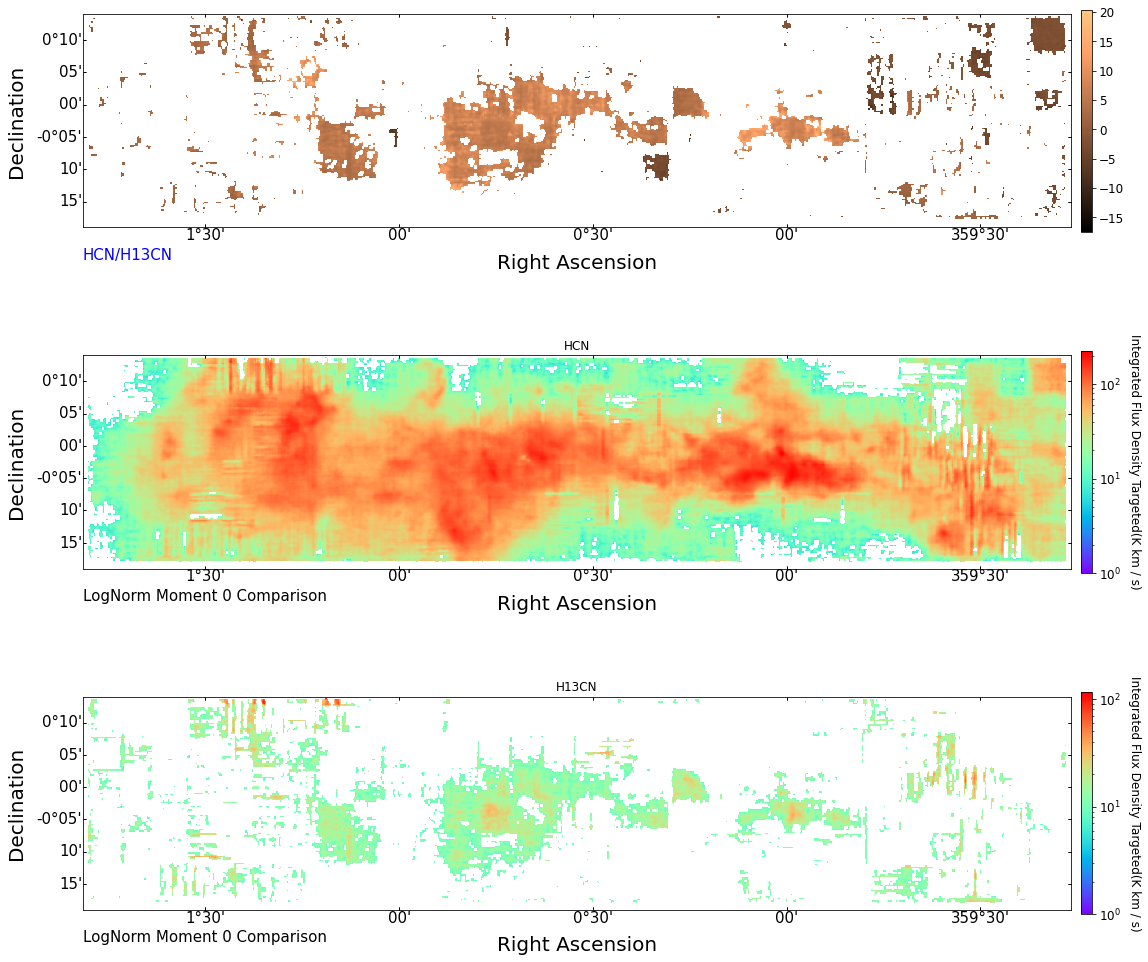

In [13]:


what = "HCN/H13CN"
top = "HCN"
bot="H13CN"
#####Zoom in

sc2B = SpectralCube.read('CMZ_3mm_HCN.fits')    #Top
sc1B = SpectralCube.read('CMZ_3mm_H13CN.fits')  #Bot


#Find Noise 1 
scW = sc1B.wcs[:][:][0]
Np1 = SkyCoord('01d31m00s', '00d00m00s', frame='galactic')#These are away from the sources
Np2 = SkyCoord('01d30m00s', '00d10m00s', frame='galactic')
NraDP1 = [int(scW.world_to_pixel(Np1)[0]),int(scW.world_to_pixel(Np1)[1])]
NraDP2 = [int(scW.world_to_pixel(Np2)[0]),int(scW.world_to_pixel(Np2)[1])]
Nsc1 = sc1B[0:int(len(sc1B)/3),NraDP1[1]:NraDP2[1],NraDP1[0]:NraDP2[0]] # Make a subcube away from the signals
#Find StandardDev of this noise cube
N1kms = Nsc1.with_spectral_unit(u.km/u.s,velocity_convention="radio")
N1kms.allow_huge_operations=True
N1Kkma = N1kms.to(u.K)
N1Mom  = N1Kkma.moment(order=0,how='slice')    # Calculate the first Moment 0 map 
m1=N1Mom.std()

#Find Noise 2
scW = sc2B.wcs[:][:][0]
Np1 = SkyCoord('01d31m00s', '00d00m00s', frame='galactic')#These are away from the sources
Np2 = SkyCoord('01d30m00s', '00d10m00s', frame='galactic')
NraDP1 = [int(scW.world_to_pixel(Np1)[0]),int(scW.world_to_pixel(Np1)[1])]
NraDP2 = [int(scW.world_to_pixel(Np2)[0]),int(scW.world_to_pixel(Np2)[1])]
Nsc2 = sc2B[0:int(len(sc2B)/3),NraDP1[1]:NraDP2[1],NraDP1[0]:NraDP2[0]] # Make a subcube away from the signals
#Find StandardDev of this noise cube
N2kms = Nsc2.with_spectral_unit(u.km/u.s,velocity_convention="radio")
N2kms.allow_huge_operations=True
N2Kkma = N2kms.to(u.K)
N2Mom  = N2Kkma.moment(order=0,how='slice')    # Calculate the first Moment 0 map 
m2=N2Mom.std()

print(bot,"StandardDev: ",str(m1),top,"StandardDev: ",m2)
#####

sc1_kms = sc1B.with_spectral_unit(u.km/u.s,velocity_convention="radio")
sc1_kms.allow_huge_operations=True
sc1_K_kms = sc1_kms.to(u.K)
sc2_kms = sc2B.with_spectral_unit(u.km/u.s,velocity_convention="radio")
sc2_kms.allow_huge_operations=True
sc2_K_kms = sc2_kms.to(u.K)
sc1_moment0  = sc1_K_kms.moment(order=0,how='slice')    # Calculate the first Moment 0 map 
sc2_moment0  = sc2_K_kms.moment(order=0,how='slice')    # Calculate the second Moment 0 map 



badpixS = pylab.where(abs(sc1_moment0)<m1*3)                 # Get ready to mask the data based on moment map
sc1_moment0.hdu.data[badpixS] = np.nan                          # Mask the moment 0 map under 3 sigma
badpixS = pylab.where(abs(sc2_moment0)<m2*3)                 # Get ready to mask the data based on moment map
sc2_moment0.hdu.data[badpixS] = np.nan                          # Mask the moment 0 map under 3 sigma
sc1_moment0_reproject, footprint = reproject_interp(sc1_moment0.hdu,sc2_moment0.header)
                                                        # Now that images are same size, compute ratio of moment maps
ratio = sc2_moment0.hdu.data/sc1_moment0_reproject

fig1 = pylab.figure(1,figsize=(15,15))
scWCS=sc2_moment0.wcs
ax1 = pylab.subplot(3,1,1,projection=scWCS)

im1 = pylab.imshow(ratio,cmap='copper')
RA = ax1.coords[0]                                                                  
Dec = ax1.coords[1] 
RA.set_ticklabel(exclude_overlapping=True)
Dec.set_ticklabel(exclude_overlapping=True)
RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3)                                                                                    
pylab.xlabel('Right Ascension',fontsize=20,labelpad=1)                               
pylab.ylabel('Declination',fontsize=20,labelpad=1)
ax1.tick_params(axis = 'both', which = 'major', labelsize = 15)    
cb=pylab.colorbar(im1,fraction=0.011,pad=0.01)
cb.ax.tick_params(which = 'major', labelsize = 12)   
pylab.annotate(s=what,fontsize=15,xy=(.0,-.15),xycoords="axes fraction",c="Blue");  
pylab.tight_layout(h_pad=4)
######Moment 0 
scWCS=sc2_moment0.wcs
ax2 = pylab.subplot(3,1,2, projection=scWCS)
RA = ax2.coords[0]                                                                  # 
Dec = ax2.coords[1] 
RA.set_ticklabel(exclude_overlapping=True)
Dec.set_ticklabel(exclude_overlapping=True)
im2=pylab.imshow(sc2_moment0.data,cmap='rainbow',norm=colors.LogNorm(vmin=1))
RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3) 
RA.set_ticklabel(exclude_overlapping=True) 
Dec.set_ticklabel(exclude_overlapping=True)                                                                                     
pylab.xlabel('Right Ascension',fontsize=20,labelpad=1)                               
pylab.ylabel('Declination',fontsize=20,labelpad=1) 
ax2.tick_params(axis = 'both', which = 'major', labelsize = 15)    
cb=pylab.colorbar(im2,fraction=0.011,pad=0.01)                                      
cb.set_label(label='Integrated Flux Density Targeted(K km / s)',fontsize=12,rotation=270,labelpad=20) 
cb.ax.tick_params(which = 'major', labelsize = 12)  
pylab.annotate(s='LogNorm Moment 0 Comparison',fontsize=15,xy=(.0,-.15),xycoords="axes fraction")  
pylab.tight_layout(h_pad=4)
ax2.set_title(top)

scWCS=sc1_moment0.wcs
ax3 = pylab.subplot(3,1,3, projection=scWCS)
RA = ax3.coords[0]                                                                  # 
Dec = ax3.coords[1] 
RA.set_ticklabel(exclude_overlapping=True)
Dec.set_ticklabel(exclude_overlapping=True) 
im3=pylab.imshow(sc1_moment0.data,cmap='rainbow',norm=colors.LogNorm(vmin=1))
RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3) 
RA.set_ticklabel(exclude_overlapping=True) 
Dec.set_ticklabel(exclude_overlapping=True)                                                                                     
pylab.xlabel('Right Ascension',fontsize=20,labelpad=1)                               
pylab.ylabel('Declination',fontsize=20,labelpad=1) 
ax3.tick_params(axis = 'both', which = 'major', labelsize = 15)    
cb=pylab.colorbar(im3,fraction=0.011,pad=0.01)                                      
cb.set_label(label='Integrated Flux Density Targeted(K km / s)',fontsize=12,rotation=270,labelpad=20) 
cb.ax.tick_params(which = 'major', labelsize = 12)  
pylab.annotate(s='LogNorm Moment 0 Comparison',fontsize=15,xy=(.0,-.15),xycoords="axes fraction")  
pylab.tight_layout(h_pad=4)
ax3.set_title(bot)


fig1.savefig(bbox_inches='tight',fname="CMZ_HCN_Over_H13CN.jpeg")

H13CO+ StandardDev:  4.011937106229702 K km / s HCO+ StandardDev:  2.9731386414923877 K km / s


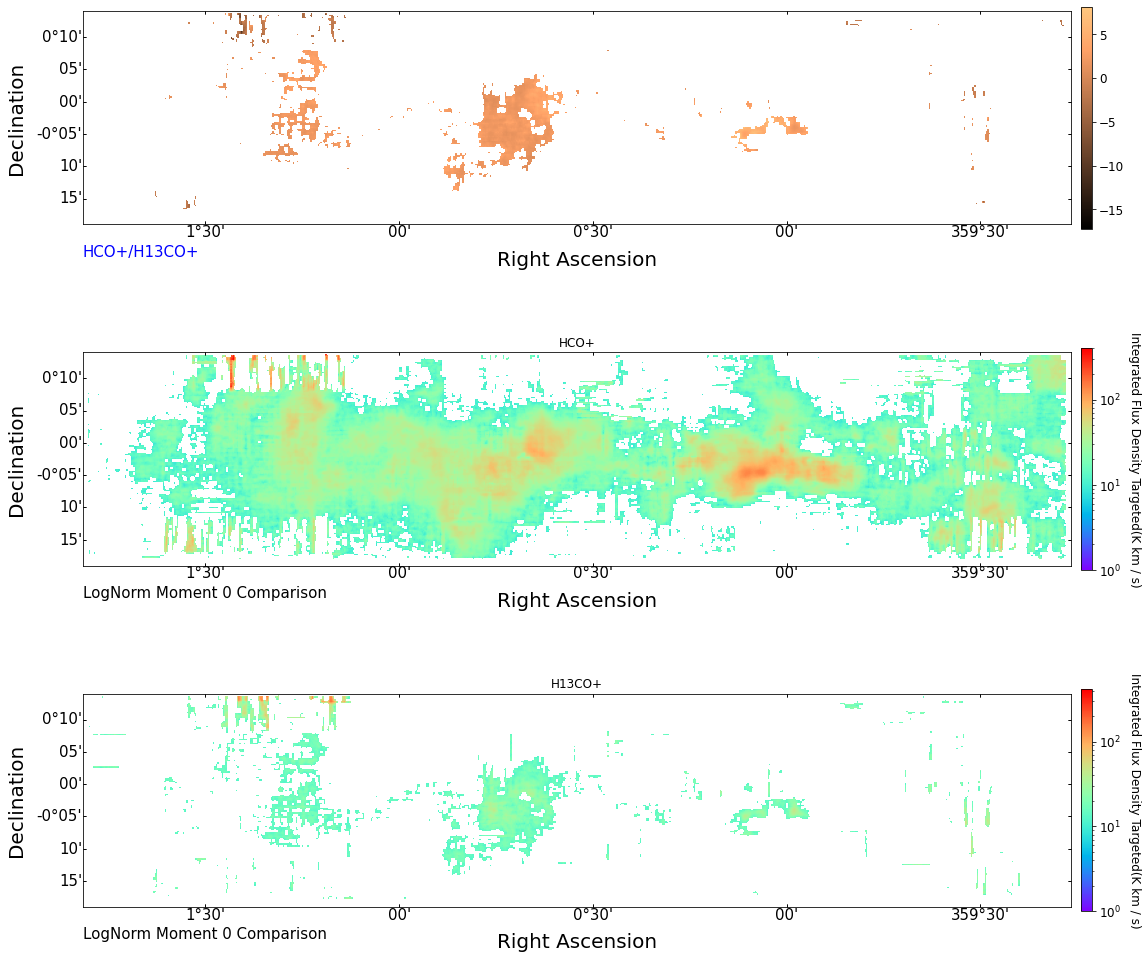

In [14]:


what = "HCO+/H13CO+"
top = "HCO+"
bot="H13CO+"
#####Zoom in

sc2B = SpectralCube.read('CMZ_3mm_HCO+.fits')    #Top
sc1B = SpectralCube.read('CMZ_3mm_H13CO+.fits')  #Bot


#Find Noise 1 
scW = sc1B.wcs[:][:][0]
Np1 = SkyCoord('01d31m00s', '00d00m00s', frame='galactic')#These are away from the sources
Np2 = SkyCoord('01d30m00s', '00d10m00s', frame='galactic')
NraDP1 = [int(scW.world_to_pixel(Np1)[0]),int(scW.world_to_pixel(Np1)[1])]
NraDP2 = [int(scW.world_to_pixel(Np2)[0]),int(scW.world_to_pixel(Np2)[1])]
Nsc1 = sc1B[0:int(len(sc1B)/3),NraDP1[1]:NraDP2[1],NraDP1[0]:NraDP2[0]] # Make a subcube away from the signals
#Find StandardDev of this noise cube
N1kms = Nsc1.with_spectral_unit(u.km/u.s,velocity_convention="radio")
N1kms.allow_huge_operations=True
N1Kkma = N1kms.to(u.K)
N1Mom  = N1Kkma.moment(order=0,how='slice')    # Calculate the first Moment 0 map 
m1=N1Mom.std()

#Find Noise 2
scW = sc2B.wcs[:][:][0]
Np1 = SkyCoord('01d31m00s', '00d00m00s', frame='galactic')#These are away from the sources
Np2 = SkyCoord('01d30m00s', '00d10m00s', frame='galactic')
NraDP1 = [int(scW.world_to_pixel(Np1)[0]),int(scW.world_to_pixel(Np1)[1])]
NraDP2 = [int(scW.world_to_pixel(Np2)[0]),int(scW.world_to_pixel(Np2)[1])]
Nsc2 = sc2B[0:int(len(sc2B)/3),NraDP1[1]:NraDP2[1],NraDP1[0]:NraDP2[0]] # Make a subcube away from the signals
#Find StandardDev of this noise cube
N2kms = Nsc2.with_spectral_unit(u.km/u.s,velocity_convention="radio")
N2kms.allow_huge_operations=True
N2Kkma = N2kms.to(u.K)
N2Mom  = N2Kkma.moment(order=0,how='slice')    # Calculate the first Moment 0 map 
m2=N2Mom.std()

print(bot,"StandardDev: ",str(m1),top,"StandardDev: ",m2)
#####

sc1_kms = sc1B.with_spectral_unit(u.km/u.s,velocity_convention="radio")
sc1_kms.allow_huge_operations=True
sc1_K_kms = sc1_kms.to(u.K)
sc2_kms = sc2B.with_spectral_unit(u.km/u.s,velocity_convention="radio")
sc2_kms.allow_huge_operations=True
sc2_K_kms = sc2_kms.to(u.K)
sc1_moment0  = sc1_K_kms.moment(order=0,how='slice')    # Calculate the first Moment 0 map 
sc2_moment0  = sc2_K_kms.moment(order=0,how='slice')    # Calculate the second Moment 0 map 



badpixS = pylab.where(abs(sc1_moment0)<m1*3)                 # Get ready to mask the data based on moment map
sc1_moment0.hdu.data[badpixS] = np.nan                          # Mask the moment 0 map under 3 sigma
badpixS = pylab.where(abs(sc2_moment0)<m2*3)                 # Get ready to mask the data based on moment map
sc2_moment0.hdu.data[badpixS] = np.nan                          # Mask the moment 0 map under 3 sigma
sc1_moment0_reproject, footprint = reproject_interp(sc1_moment0.hdu,sc2_moment0.header)
                                                        # Now that images are same size, compute ratio of moment maps
ratio = sc2_moment0.hdu.data/sc1_moment0_reproject

fig1 = pylab.figure(1,figsize=(15,15))
scWCS=sc2_moment0.wcs
ax1 = pylab.subplot(3,1,1,projection=scWCS)

im1 = pylab.imshow(ratio,cmap='copper')
RA = ax1.coords[0]                                                                  
Dec = ax1.coords[1] 
RA.set_ticklabel(exclude_overlapping=True)
Dec.set_ticklabel(exclude_overlapping=True)
RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3)                                                                                    
pylab.xlabel('Right Ascension',fontsize=20,labelpad=1)                               
pylab.ylabel('Declination',fontsize=20,labelpad=1)
ax1.tick_params(axis = 'both', which = 'major', labelsize = 15)    
cb=pylab.colorbar(im1,fraction=0.011,pad=0.01)
cb.ax.tick_params(which = 'major', labelsize = 12)   
pylab.annotate(s=what,fontsize=15,xy=(.0,-.15),xycoords="axes fraction",c="Blue");  
pylab.tight_layout(h_pad=4)
######Moment 0 
scWCS=sc2_moment0.wcs
ax2 = pylab.subplot(3,1,2, projection=scWCS)
RA = ax2.coords[0]                                                                  # 
Dec = ax2.coords[1] 
RA.set_ticklabel(exclude_overlapping=True)
Dec.set_ticklabel(exclude_overlapping=True)
im2=pylab.imshow(sc2_moment0.data,cmap='rainbow',norm=colors.LogNorm(vmin=1))
RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3) 
RA.set_ticklabel(exclude_overlapping=True) 
Dec.set_ticklabel(exclude_overlapping=True)                                                                                     
pylab.xlabel('Right Ascension',fontsize=20,labelpad=1)                               
pylab.ylabel('Declination',fontsize=20,labelpad=1) 
ax2.tick_params(axis = 'both', which = 'major', labelsize = 15)    
cb=pylab.colorbar(im2,fraction=0.011,pad=0.01)                                      
cb.set_label(label='Integrated Flux Density Targeted(K km / s)',fontsize=12,rotation=270,labelpad=20) 
cb.ax.tick_params(which = 'major', labelsize = 12)  
pylab.annotate(s='LogNorm Moment 0 Comparison',fontsize=15,xy=(.0,-.15),xycoords="axes fraction")  
pylab.tight_layout(h_pad=4)
ax2.set_title(top)

scWCS=sc1_moment0.wcs
ax3 = pylab.subplot(3,1,3, projection=scWCS)
RA = ax3.coords[0]                                                                  # 
Dec = ax3.coords[1] 
RA.set_ticklabel(exclude_overlapping=True)
Dec.set_ticklabel(exclude_overlapping=True) 
im3=pylab.imshow(sc1_moment0.data,cmap='rainbow',norm=colors.LogNorm(vmin=1))
RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3) 
RA.set_ticklabel(exclude_overlapping=True) 
Dec.set_ticklabel(exclude_overlapping=True)                                                                                     
pylab.xlabel('Right Ascension',fontsize=20,labelpad=1)                               
pylab.ylabel('Declination',fontsize=20,labelpad=1) 
ax3.tick_params(axis = 'both', which = 'major', labelsize = 15)    
cb=pylab.colorbar(im3,fraction=0.011,pad=0.01)                                      
cb.set_label(label='Integrated Flux Density Targeted(K km / s)',fontsize=12,rotation=270,labelpad=20) 
cb.ax.tick_params(which = 'major', labelsize = 12)  
pylab.annotate(s='LogNorm Moment 0 Comparison',fontsize=15,xy=(.0,-.15),xycoords="axes fraction")  
pylab.tight_layout(h_pad=4)
ax3.set_title(bot)


fig1.savefig(bbox_inches='tight',fname="CMZ_HCOp_Over_H13COp.jpeg")

H13CO+ StandardDev:  4.011937106229702 K km / s H13CN StandardDev:  2.691566261335012 K km / s


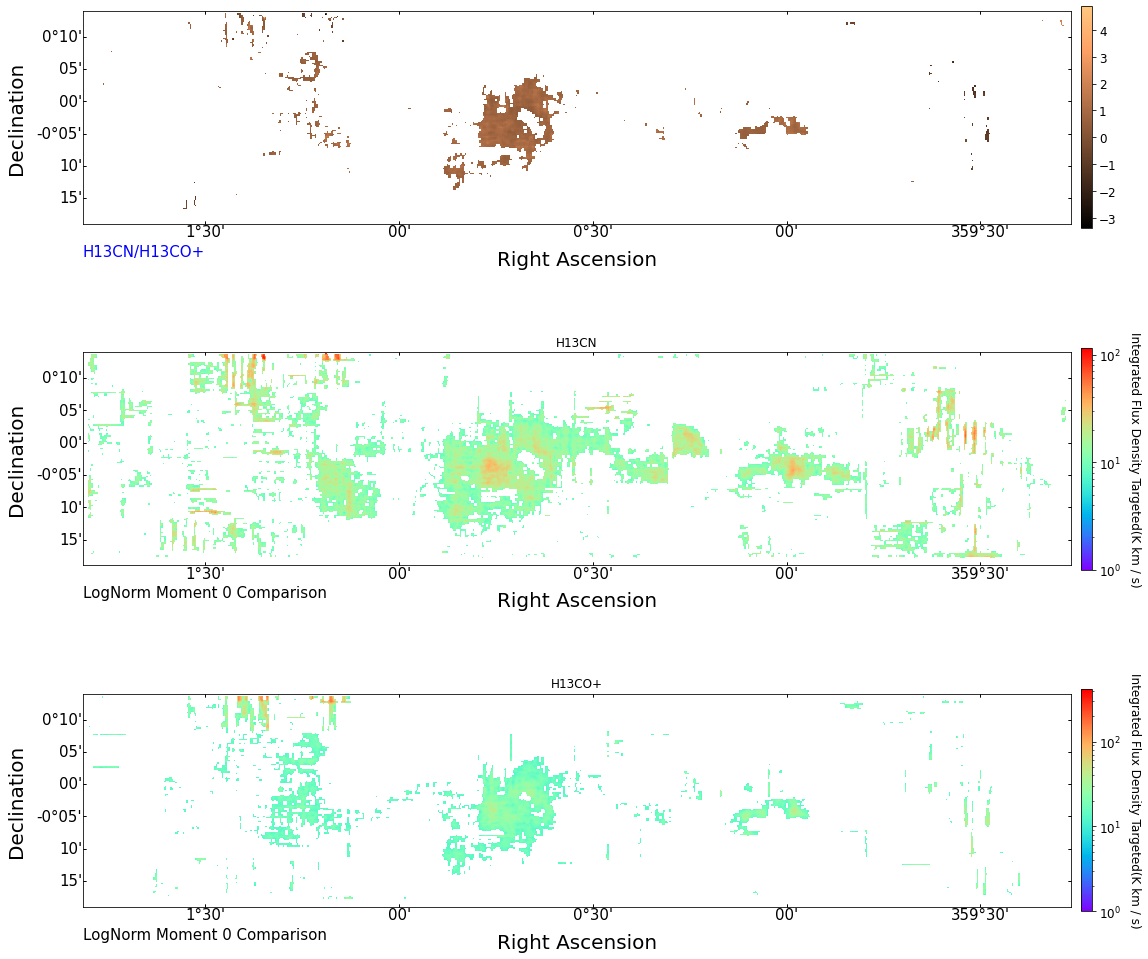

In [15]:


what = "H13CN/H13CO+"
top = "H13CN"
bot="H13CO+"
#####Zoom in

sc2B = SpectralCube.read('CMZ_3mm_H13CN.fits')    #Top
sc1B = SpectralCube.read('CMZ_3mm_H13CO+.fits')  #Bot


#Find Noise 1 
scW = sc1B.wcs[:][:][0]
Np1 = SkyCoord('01d31m00s', '00d00m00s', frame='galactic')#These are away from the sources
Np2 = SkyCoord('01d30m00s', '00d10m00s', frame='galactic')
NraDP1 = [int(scW.world_to_pixel(Np1)[0]),int(scW.world_to_pixel(Np1)[1])]
NraDP2 = [int(scW.world_to_pixel(Np2)[0]),int(scW.world_to_pixel(Np2)[1])]
Nsc1 = sc1B[0:int(len(sc1B)/3),NraDP1[1]:NraDP2[1],NraDP1[0]:NraDP2[0]] # Make a subcube away from the signals
#Find StandardDev of this noise cube
N1kms = Nsc1.with_spectral_unit(u.km/u.s,velocity_convention="radio")
N1kms.allow_huge_operations=True
N1Kkma = N1kms.to(u.K)
N1Mom  = N1Kkma.moment(order=0,how='slice')    # Calculate the first Moment 0 map 
m1=N1Mom.std()

#Find Noise 2
scW = sc2B.wcs[:][:][0]
Np1 = SkyCoord('01d31m00s', '00d00m00s', frame='galactic')#These are away from the sources
Np2 = SkyCoord('01d30m00s', '00d10m00s', frame='galactic')
NraDP1 = [int(scW.world_to_pixel(Np1)[0]),int(scW.world_to_pixel(Np1)[1])]
NraDP2 = [int(scW.world_to_pixel(Np2)[0]),int(scW.world_to_pixel(Np2)[1])]
Nsc2 = sc2B[0:int(len(sc2B)/3),NraDP1[1]:NraDP2[1],NraDP1[0]:NraDP2[0]] # Make a subcube away from the signals
#Find StandardDev of this noise cube
N2kms = Nsc2.with_spectral_unit(u.km/u.s,velocity_convention="radio")
N2kms.allow_huge_operations=True
N2Kkma = N2kms.to(u.K)
N2Mom  = N2Kkma.moment(order=0,how='slice')    # Calculate the first Moment 0 map 
m2=N2Mom.std()

print(bot,"StandardDev: ",str(m1),top,"StandardDev: ",m2)
#####

sc1_kms = sc1B.with_spectral_unit(u.km/u.s,velocity_convention="radio")
sc1_kms.allow_huge_operations=True
sc1_K_kms = sc1_kms.to(u.K)
sc2_kms = sc2B.with_spectral_unit(u.km/u.s,velocity_convention="radio")
sc2_kms.allow_huge_operations=True
sc2_K_kms = sc2_kms.to(u.K)
sc1_moment0  = sc1_K_kms.moment(order=0,how='slice')    # Calculate the first Moment 0 map 
sc2_moment0  = sc2_K_kms.moment(order=0,how='slice')    # Calculate the second Moment 0 map 



badpixS = pylab.where(abs(sc1_moment0)<m1*3)                 # Get ready to mask the data based on moment map
sc1_moment0.hdu.data[badpixS] = np.nan                          # Mask the moment 0 map under 3 sigma
badpixS = pylab.where(abs(sc2_moment0)<m2*3)                 # Get ready to mask the data based on moment map
sc2_moment0.hdu.data[badpixS] = np.nan                          # Mask the moment 0 map under 3 sigma
sc1_moment0_reproject, footprint = reproject_interp(sc1_moment0.hdu,sc2_moment0.header)
                                                        # Now that images are same size, compute ratio of moment maps
ratio = sc2_moment0.hdu.data/sc1_moment0_reproject

fig1 = pylab.figure(1,figsize=(15,15))
scWCS=sc2_moment0.wcs
ax1 = pylab.subplot(3,1,1,projection=scWCS)

im1 = pylab.imshow(ratio,cmap='copper')
RA = ax1.coords[0]                                                                  
Dec = ax1.coords[1] 
RA.set_ticklabel(exclude_overlapping=True)
Dec.set_ticklabel(exclude_overlapping=True)
RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3)                                                                                    
pylab.xlabel('Right Ascension',fontsize=20,labelpad=1)                               
pylab.ylabel('Declination',fontsize=20,labelpad=1)
ax1.tick_params(axis = 'both', which = 'major', labelsize = 15)    
cb=pylab.colorbar(im1,fraction=0.011,pad=0.01)
cb.ax.tick_params(which = 'major', labelsize = 12)   
pylab.annotate(s=what,fontsize=15,xy=(.0,-.15),xycoords="axes fraction",c="Blue");  
pylab.tight_layout(h_pad=4)
######Moment 0 
scWCS=sc2_moment0.wcs
ax2 = pylab.subplot(3,1,2, projection=scWCS)
RA = ax2.coords[0]                                                                  # 
Dec = ax2.coords[1] 
RA.set_ticklabel(exclude_overlapping=True)
Dec.set_ticklabel(exclude_overlapping=True)
im2=pylab.imshow(sc2_moment0.data,cmap='rainbow',norm=colors.LogNorm(vmin=1))
RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3) 
RA.set_ticklabel(exclude_overlapping=True) 
Dec.set_ticklabel(exclude_overlapping=True)                                                                                     
pylab.xlabel('Right Ascension',fontsize=20,labelpad=1)                               
pylab.ylabel('Declination',fontsize=20,labelpad=1) 
ax2.tick_params(axis = 'both', which = 'major', labelsize = 15)    
cb=pylab.colorbar(im2,fraction=0.011,pad=0.01)                                      
cb.set_label(label='Integrated Flux Density Targeted(K km / s)',fontsize=12,rotation=270,labelpad=20) 
cb.ax.tick_params(which = 'major', labelsize = 12)  
pylab.annotate(s='LogNorm Moment 0 Comparison',fontsize=15,xy=(.0,-.15),xycoords="axes fraction")  
pylab.tight_layout(h_pad=4)
ax2.set_title(top)

scWCS=sc1_moment0.wcs
ax3 = pylab.subplot(3,1,3, projection=scWCS)
RA = ax3.coords[0]                                                                  # 
Dec = ax3.coords[1] 
RA.set_ticklabel(exclude_overlapping=True)
Dec.set_ticklabel(exclude_overlapping=True) 
im3=pylab.imshow(sc1_moment0.data,cmap='rainbow',norm=colors.LogNorm(vmin=1))
RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3) 
RA.set_ticklabel(exclude_overlapping=True) 
Dec.set_ticklabel(exclude_overlapping=True)                                                                                     
pylab.xlabel('Right Ascension',fontsize=20,labelpad=1)                               
pylab.ylabel('Declination',fontsize=20,labelpad=1) 
ax3.tick_params(axis = 'both', which = 'major', labelsize = 15)    
cb=pylab.colorbar(im3,fraction=0.011,pad=0.01)                                      
cb.set_label(label='Integrated Flux Density Targeted(K km / s)',fontsize=12,rotation=270,labelpad=20) 
cb.ax.tick_params(which = 'major', labelsize = 12)  
pylab.annotate(s='LogNorm Moment 0 Comparison',fontsize=15,xy=(.0,-.15),xycoords="axes fraction")  
pylab.tight_layout(h_pad=4)
ax3.set_title(bot)


fig1.savefig(bbox_inches='tight',fname="CMZ_H13CN_Over_H13COp.jpeg")

HCO+ StandardDev:  4.011937106229702 K km / s H13CN StandardDev:  2.691566261335012 K km / s


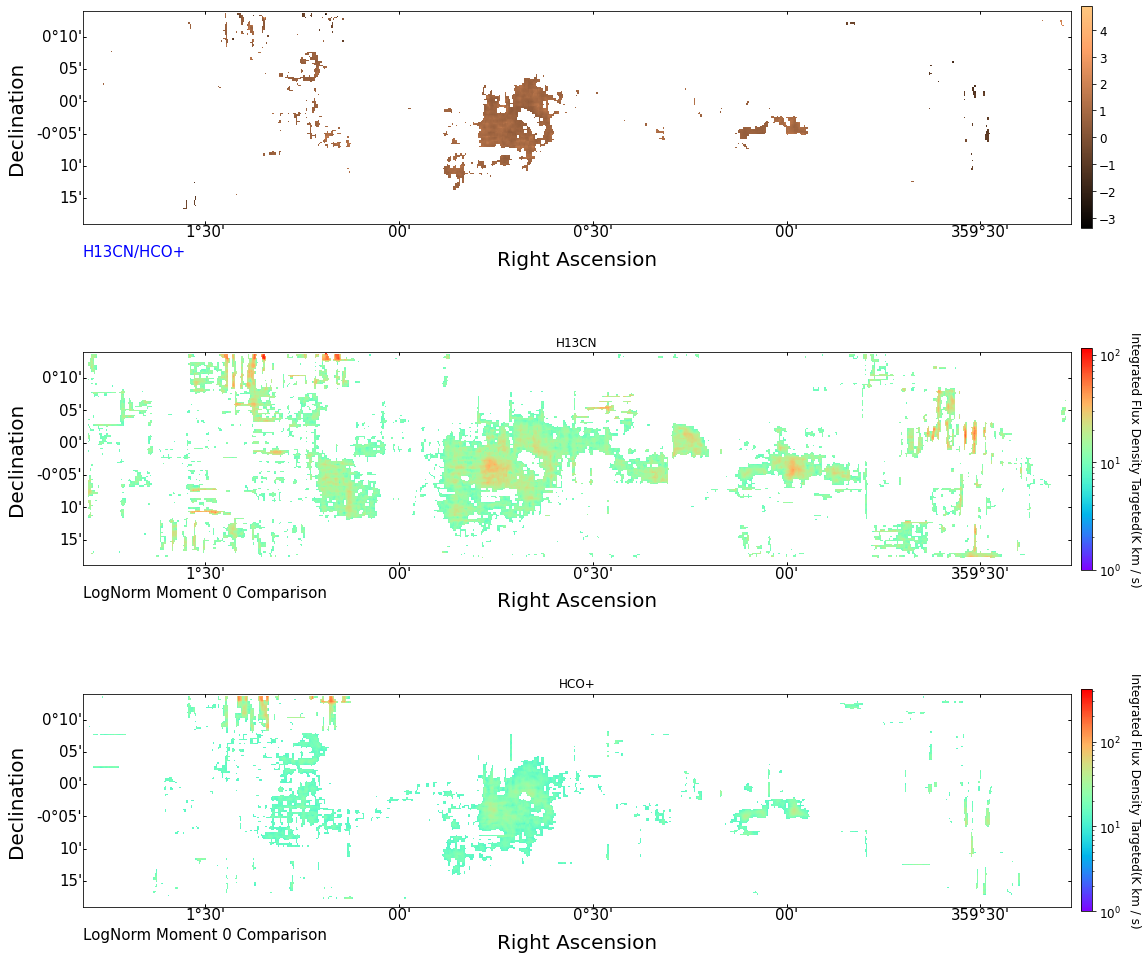

In [16]:

what = "H13CN/HCO+"
top = "H13CN"
bot="HCO+"
#####Zoom in

sc1 = SpectralCube.read('CMZ_3mm_HCO+.fits')   
sc2 = SpectralCube.read('CMZ_3mm_H13CN.fits')


#Find Noise 1 
scW = sc1B.wcs[:][:][0]
Np1 = SkyCoord('01d31m00s', '00d00m00s', frame='galactic')#These are away from the sources
Np2 = SkyCoord('01d30m00s', '00d10m00s', frame='galactic')
NraDP1 = [int(scW.world_to_pixel(Np1)[0]),int(scW.world_to_pixel(Np1)[1])]
NraDP2 = [int(scW.world_to_pixel(Np2)[0]),int(scW.world_to_pixel(Np2)[1])]
Nsc1 = sc1B[0:int(len(sc1B)/3),NraDP1[1]:NraDP2[1],NraDP1[0]:NraDP2[0]] # Make a subcube away from the signals
#Find StandardDev of this noise cube
N1kms = Nsc1.with_spectral_unit(u.km/u.s,velocity_convention="radio")
N1kms.allow_huge_operations=True
N1Kkma = N1kms.to(u.K)
N1Mom  = N1Kkma.moment(order=0,how='slice')    # Calculate the first Moment 0 map 
m1=N1Mom.std()

#Find Noise 2
scW = sc2B.wcs[:][:][0]
Np1 = SkyCoord('01d31m00s', '00d00m00s', frame='galactic')#These are away from the sources
Np2 = SkyCoord('01d30m00s', '00d10m00s', frame='galactic')
NraDP1 = [int(scW.world_to_pixel(Np1)[0]),int(scW.world_to_pixel(Np1)[1])]
NraDP2 = [int(scW.world_to_pixel(Np2)[0]),int(scW.world_to_pixel(Np2)[1])]
Nsc2 = sc2B[0:int(len(sc2B)/3),NraDP1[1]:NraDP2[1],NraDP1[0]:NraDP2[0]] # Make a subcube away from the signals
#Find StandardDev of this noise cube
N2kms = Nsc2.with_spectral_unit(u.km/u.s,velocity_convention="radio")
N2kms.allow_huge_operations=True
N2Kkma = N2kms.to(u.K)
N2Mom  = N2Kkma.moment(order=0,how='slice')    # Calculate the first Moment 0 map 
m2=N2Mom.std()

print(bot,"StandardDev: ",str(m1),top,"StandardDev: ",m2)
#####

sc1_kms = sc1B.with_spectral_unit(u.km/u.s,velocity_convention="radio")
sc1_kms.allow_huge_operations=True
sc1_K_kms = sc1_kms.to(u.K)
sc2_kms = sc2B.with_spectral_unit(u.km/u.s,velocity_convention="radio")
sc2_kms.allow_huge_operations=True
sc2_K_kms = sc2_kms.to(u.K)
sc1_moment0  = sc1_K_kms.moment(order=0,how='slice')    # Calculate the first Moment 0 map 
sc2_moment0  = sc2_K_kms.moment(order=0,how='slice')    # Calculate the second Moment 0 map 



badpixS = pylab.where(abs(sc1_moment0)<m1*3)                 # Get ready to mask the data based on moment map
sc1_moment0.hdu.data[badpixS] = np.nan                          # Mask the moment 0 map under 3 sigma
badpixS = pylab.where(abs(sc2_moment0)<m2*3)                 # Get ready to mask the data based on moment map
sc2_moment0.hdu.data[badpixS] = np.nan                          # Mask the moment 0 map under 3 sigma
sc1_moment0_reproject, footprint = reproject_interp(sc1_moment0.hdu,sc2_moment0.header)
                                                        # Now that images are same size, compute ratio of moment maps
ratio = sc2_moment0.hdu.data/sc1_moment0_reproject

fig1 = pylab.figure(1,figsize=(15,15))
scWCS=sc2_moment0.wcs
ax1 = pylab.subplot(3,1,1,projection=scWCS)

im1 = pylab.imshow(ratio,cmap='copper')
RA = ax1.coords[0]                                                                  
Dec = ax1.coords[1] 
RA.set_ticklabel(exclude_overlapping=True)
Dec.set_ticklabel(exclude_overlapping=True)
RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3)                                                                                    
pylab.xlabel('Right Ascension',fontsize=20,labelpad=1)                               
pylab.ylabel('Declination',fontsize=20,labelpad=1)
ax1.tick_params(axis = 'both', which = 'major', labelsize = 15)    
cb=pylab.colorbar(im1,fraction=0.011,pad=0.01)
cb.ax.tick_params(which = 'major', labelsize = 12)   
pylab.annotate(s=what,fontsize=15,xy=(.0,-.15),xycoords="axes fraction",c="Blue");  
pylab.tight_layout(h_pad=4)
######Moment 0 
scWCS=sc2_moment0.wcs
ax2 = pylab.subplot(3,1,2, projection=scWCS)
RA = ax2.coords[0]                                                                  # 
Dec = ax2.coords[1] 
RA.set_ticklabel(exclude_overlapping=True)
Dec.set_ticklabel(exclude_overlapping=True)
im2=pylab.imshow(sc2_moment0.data,cmap='rainbow',norm=colors.LogNorm(vmin=1))
RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3) 
RA.set_ticklabel(exclude_overlapping=True) 
Dec.set_ticklabel(exclude_overlapping=True)                                                                                     
pylab.xlabel('Right Ascension',fontsize=20,labelpad=1)                               
pylab.ylabel('Declination',fontsize=20,labelpad=1) 
ax2.tick_params(axis = 'both', which = 'major', labelsize = 15)    
cb=pylab.colorbar(im2,fraction=0.011,pad=0.01)                                      
cb.set_label(label='Integrated Flux Density Targeted(K km / s)',fontsize=12,rotation=270,labelpad=20) 
cb.ax.tick_params(which = 'major', labelsize = 12)  
pylab.annotate(s='LogNorm Moment 0 Comparison',fontsize=15,xy=(.0,-.15),xycoords="axes fraction")  
pylab.tight_layout(h_pad=4)
ax2.set_title(top)

scWCS=sc1_moment0.wcs
ax3 = pylab.subplot(3,1,3, projection=scWCS)
RA = ax3.coords[0]                                                                  # 
Dec = ax3.coords[1] 
RA.set_ticklabel(exclude_overlapping=True)
Dec.set_ticklabel(exclude_overlapping=True) 
im3=pylab.imshow(sc1_moment0.data,cmap='rainbow',norm=colors.LogNorm(vmin=1))
RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3) 
RA.set_ticklabel(exclude_overlapping=True) 
Dec.set_ticklabel(exclude_overlapping=True)                                                                                     
pylab.xlabel('Right Ascension',fontsize=20,labelpad=1)                               
pylab.ylabel('Declination',fontsize=20,labelpad=1) 
ax3.tick_params(axis = 'both', which = 'major', labelsize = 15)    
cb=pylab.colorbar(im3,fraction=0.011,pad=0.01)                                      
cb.set_label(label='Integrated Flux Density Targeted(K km / s)',fontsize=12,rotation=270,labelpad=20) 
cb.ax.tick_params(which = 'major', labelsize = 12)  
pylab.annotate(s='LogNorm Moment 0 Comparison',fontsize=15,xy=(.0,-.15),xycoords="axes fraction")  
pylab.tight_layout(h_pad=4)
ax3.set_title(bot)


fig1.savefig(bbox_inches='tight',fname="CMZ_H13CN_Over_HCO_Plus.jpeg")

HCO+ StandardDev:  2.9731386414923877 K km / s HCN StandardDev:  2.1441413385398365 K km / s


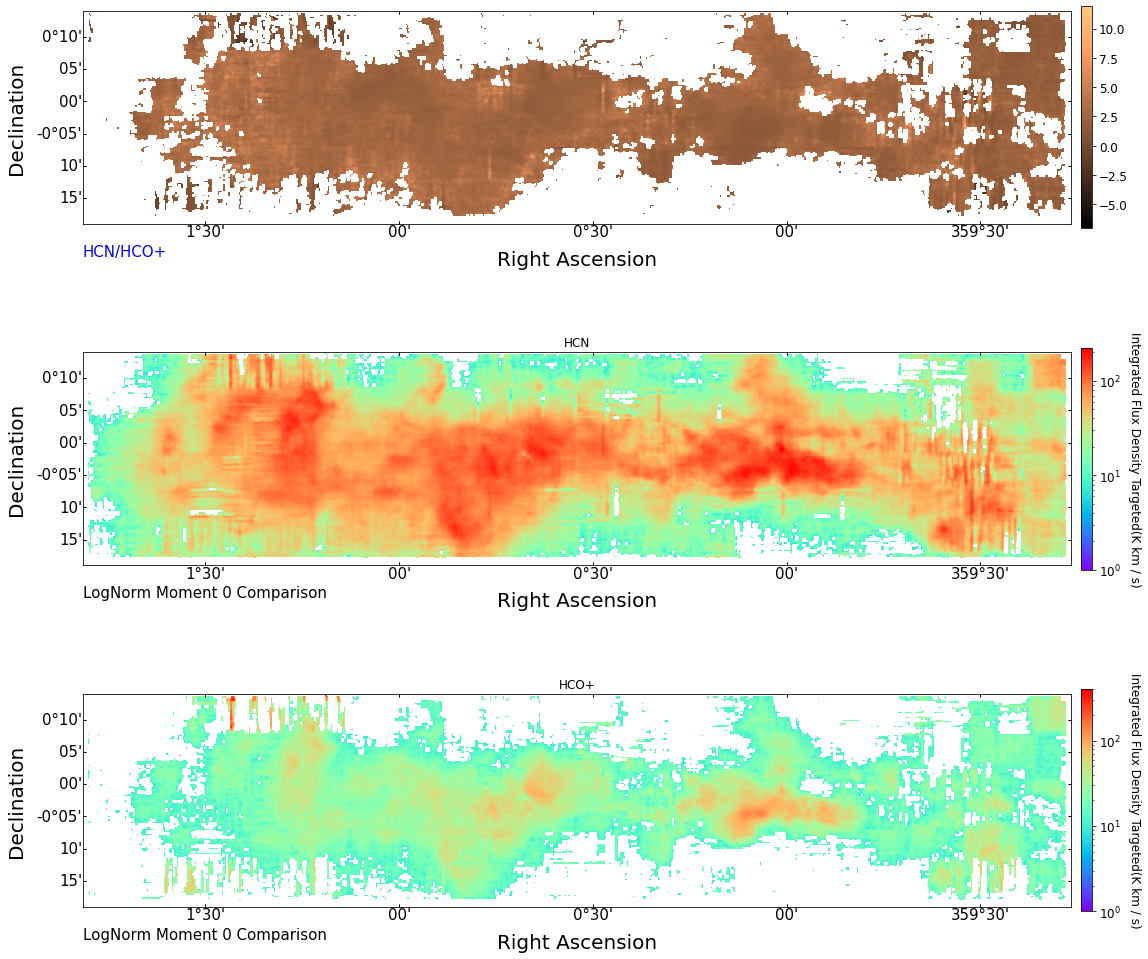

In [17]:

what = "HCN/HCO+"
top = "HCN"
bot="HCO+"
#####Zoom in

sc1B = SpectralCube.read('CMZ_3mm_HCO+.fits')
sc2B = SpectralCube.read('CMZ_3mm_HCN.fits') 
#Find Noise 1 
scW = sc1B.wcs[:][:][0]
Np1 = SkyCoord('01d31m00s', '00d00m00s', frame='galactic')#These are away from the sources
Np2 = SkyCoord('01d30m00s', '00d10m00s', frame='galactic')
NraDP1 = [int(scW.world_to_pixel(Np1)[0]),int(scW.world_to_pixel(Np1)[1])]
NraDP2 = [int(scW.world_to_pixel(Np2)[0]),int(scW.world_to_pixel(Np2)[1])]
Nsc1 = sc1B[0:int(len(sc1B)/3),NraDP1[1]:NraDP2[1],NraDP1[0]:NraDP2[0]] # Make a subcube away from the signals
#Find StandardDev of this noise cube
N1kms = Nsc1.with_spectral_unit(u.km/u.s,velocity_convention="radio")
N1kms.allow_huge_operations=True
N1Kkma = N1kms.to(u.K)
N1Mom  = N1Kkma.moment(order=0,how='slice')    # Calculate the first Moment 0 map 
m1=N1Mom.std()

#Find Noise 2
scW = sc2B.wcs[:][:][0]
Np1 = SkyCoord('01d31m00s', '00d00m00s', frame='galactic')#These are away from the sources
Np2 = SkyCoord('01d30m00s', '00d10m00s', frame='galactic')
NraDP1 = [int(scW.world_to_pixel(Np1)[0]),int(scW.world_to_pixel(Np1)[1])]
NraDP2 = [int(scW.world_to_pixel(Np2)[0]),int(scW.world_to_pixel(Np2)[1])]
Nsc2 = sc2B[0:int(len(sc2B)/3),NraDP1[1]:NraDP2[1],NraDP1[0]:NraDP2[0]] # Make a subcube away from the signals
#Find StandardDev of this noise cube
N2kms = Nsc2.with_spectral_unit(u.km/u.s,velocity_convention="radio")
N2kms.allow_huge_operations=True
N2Kkma = N2kms.to(u.K)
N2Mom  = N2Kkma.moment(order=0,how='slice')    # Calculate the first Moment 0 map 
m2=N2Mom.std()

print(bot,"StandardDev: ",str(m1),top,"StandardDev: ",m2)
#####

sc1_kms = sc1B.with_spectral_unit(u.km/u.s,velocity_convention="radio")
sc1_kms.allow_huge_operations=True
sc1_K_kms = sc1_kms.to(u.K)
sc2_kms = sc2B.with_spectral_unit(u.km/u.s,velocity_convention="radio")
sc2_kms.allow_huge_operations=True
sc2_K_kms = sc2_kms.to(u.K)
sc1_moment0  = sc1_K_kms.moment(order=0,how='slice')    # Calculate the first Moment 0 map 
sc2_moment0  = sc2_K_kms.moment(order=0,how='slice')    # Calculate the second Moment 0 map 



badpixS = pylab.where(abs(sc1_moment0)<m1*3)                 # Get ready to mask the data based on moment map
sc1_moment0.hdu.data[badpixS] = np.nan                          # Mask the moment 0 map under 3 sigma
badpixS = pylab.where(abs(sc2_moment0)<m2*3)                 # Get ready to mask the data based on moment map
sc2_moment0.hdu.data[badpixS] = np.nan                          # Mask the moment 0 map under 3 sigma
sc1_moment0_reproject, footprint = reproject_interp(sc1_moment0.hdu,sc2_moment0.header)
                                                        # Now that images are same size, compute ratio of moment maps
ratio = sc2_moment0.hdu.data/sc1_moment0_reproject

fig1 = pylab.figure(1,figsize=(15,15))
scWCS=sc2_moment0.wcs
ax1 = pylab.subplot(3,1,1,projection=scWCS)

im1 = pylab.imshow(ratio,cmap='copper')
RA = ax1.coords[0]                                                                  
Dec = ax1.coords[1] 
RA.set_ticklabel(exclude_overlapping=True)
Dec.set_ticklabel(exclude_overlapping=True)
RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3)                                                                                    
pylab.xlabel('Right Ascension',fontsize=20,labelpad=1)                               
pylab.ylabel('Declination',fontsize=20,labelpad=1)
ax1.tick_params(axis = 'both', which = 'major', labelsize = 15)    
cb=pylab.colorbar(im1,fraction=0.011,pad=0.01)
cb.ax.tick_params(which = 'major', labelsize = 12)   
pylab.annotate(s=what,fontsize=15,xy=(.0,-.15),xycoords="axes fraction",c="Blue");  
pylab.tight_layout(h_pad=4)
######Moment 0 
scWCS=sc2_moment0.wcs
ax2 = pylab.subplot(3,1,2, projection=scWCS)
RA = ax2.coords[0]                                                                  # 
Dec = ax2.coords[1] 
RA.set_ticklabel(exclude_overlapping=True)
Dec.set_ticklabel(exclude_overlapping=True)
im2=pylab.imshow(sc2_moment0.data,cmap='rainbow',norm=colors.LogNorm(vmin=1))
RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3) 
RA.set_ticklabel(exclude_overlapping=True) 
Dec.set_ticklabel(exclude_overlapping=True)                                                                                     
pylab.xlabel('Right Ascension',fontsize=20,labelpad=1)                               
pylab.ylabel('Declination',fontsize=20,labelpad=1) 
ax2.tick_params(axis = 'both', which = 'major', labelsize = 15)    
cb=pylab.colorbar(im2,fraction=0.011,pad=0.01)                                      
cb.set_label(label='Integrated Flux Density Targeted(K km / s)',fontsize=12,rotation=270,labelpad=20) 
cb.ax.tick_params(which = 'major', labelsize = 12)  
pylab.annotate(s='LogNorm Moment 0 Comparison',fontsize=15,xy=(.0,-.15),xycoords="axes fraction")  
pylab.tight_layout(h_pad=4)
ax2.set_title(top)

scWCS=sc1_moment0.wcs
ax3 = pylab.subplot(3,1,3, projection=scWCS)
RA = ax3.coords[0]                                                                  # 
Dec = ax3.coords[1] 
RA.set_ticklabel(exclude_overlapping=True)
Dec.set_ticklabel(exclude_overlapping=True) 
im3=pylab.imshow(sc1_moment0.data,cmap='rainbow',norm=colors.LogNorm(vmin=1))
RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3) 
RA.set_ticklabel(exclude_overlapping=True) 
Dec.set_ticklabel(exclude_overlapping=True)                                                                                     
pylab.xlabel('Right Ascension',fontsize=20,labelpad=1)                               
pylab.ylabel('Declination',fontsize=20,labelpad=1) 
ax3.tick_params(axis = 'both', which = 'major', labelsize = 15)    
cb=pylab.colorbar(im3,fraction=0.011,pad=0.01)                                      
cb.set_label(label='Integrated Flux Density Targeted(K km / s)',fontsize=12,rotation=270,labelpad=20) 
cb.ax.tick_params(which = 'major', labelsize = 12)  
pylab.annotate(s='LogNorm Moment 0 Comparison',fontsize=15,xy=(.0,-.15),xycoords="axes fraction")  
pylab.tight_layout(h_pad=4)
ax3.set_title(bot)


fig1.savefig(bbox_inches='tight',fname="CMZ_HCN_Over_HCO_Plus.jpeg")

# Part 4: Channel Maps

In [ ]:


#####Zoom in

sc = SpectralCube.read('CMZ_3mm_HCO+.fits') 


cen_p1 = SkyCoord('00h47m34.2s', '-25d17m31s', frame='icrs')
cen_p2 = SkyCoord('00h47m31.8s', '-25d17m07s', frame='icrs')

scW = sc.wcs[:][:][0]
raDP1 = [int(scW.world_to_pixel(cen_p1)[0]),int(scW.world_to_pixel(cen_p1)[1])]
raDP2 = [int(scW.world_to_pixel(cen_p2)[0]),int(scW.world_to_pixel(cen_p2)[1])]

scN = sc[:,raDP1[1]:raDP2[1],raDP1[0]:raDP2[0]] # Make a subcube based on position
scW = scN.wcs[:][:][0]
#####

SC_KMS = scN.with_spectral_unit(u.km/u.s,velocity_convention="radio")
SC_KMS.allow_huge_operations=True
SC_K_KMS = SC_KMS.to(u.K)


SC_K_KMS_slab = SC_K_KMS.spectral_slab(-100. *u.km / u.s, 500. *u.km / u.s)  # Extract a subset of the velocities
SC_Bin = SC_K_KMS_slab.downsample_axis(8,axis=0) # Here we use downsampling to bin (average)the data 
                                                # into coarse bins (broad channels) with width ~ 11 km/s    

vel, dec, ra = SC_Bin.world[:,0,0]           # For plotting purposes, I want to know the average velocity
                                                # for each of these new averaged channels

fig1 = pylab.figure(1,figsize=(15,15))

                                            
for i in np.arange(0,len(SC_Bin.hdu.data)):                       # Now we loop through each slice (averaged channels) 
    ax = pylab.subplot(10,5,i+1,projection=scW) # We plot them in a grid
    #Create e^intesity plots
    im = pylab.imshow(np.exp(SC_Bin.hdu.data[i]),cmap='rainbow',norm=colors.LogNorm(vmin=np.exp(-20),vmax=np.exp(20)))
    
    RA = ax.coords[0]                                                                  
    Dec = ax.coords[1]
    RA.set_ticks(size=-1)                                                                                      
    Dec.set_ticks(size=-1) 
    RA.set_ticklabel(exclude_overlapping=True)
    Dec.set_ticklabel(exclude_overlapping=True) 
    pylab.text(10,25,s="%i km/s"%(vel.value[i]),fontsize=10) # Print the velocity of each averaged channel
    cb=pylab.colorbar(im,fraction=0.035,pad=0.01) 
    if i==len(SC_Bin.hdu.data)-1:
        pylab.xlabel("Right Ascension")
        pylab.ylabel("Declination",labelpad=-2)
    else:
        pylab.xlabel(" ")
        pylab.ylabel(" ") 
    pylab.tight_layout(w_pad=5,h_pad=1)




fig1.savefig(bbox_inches='tight',fname="NGC253.HCO+_4-3_CM.jpeg")

In [ ]:


#####Zoom in

sc = SpectralCube.read('CMZ_3mm_HCN.fits') 


cen_p1 = SkyCoord('00h47m34.2s', '-25d17m31s', frame='icrs')
cen_p2 = SkyCoord('00h47m31.8s', '-25d17m07s', frame='icrs')
scW = sc.wcs[:][:][0]
raDP1 = [int(scW.world_to_pixel(cen_p1)[0]),int(scW.world_to_pixel(cen_p1)[1])]
raDP2 = [int(scW.world_to_pixel(cen_p2)[0]),int(scW.world_to_pixel(cen_p2)[1])]

scN = sc[:,raDP1[1]:raDP2[1],raDP1[0]:raDP2[0]] # Make a subcube based on position
scW = scN.wcs[:][:][0]
#####

SC_KMS = scN.with_spectral_unit(u.km/u.s,velocity_convention="radio")
SC_KMS.allow_huge_operations=True
SC_K_KMS = SC_KMS.to(u.K)


SC_K_KMS_slab = SC_K_KMS.spectral_slab(-100. *u.km / u.s, 500. *u.km / u.s)  # Extract a subset of the velocities
SC_Bin = SC_K_KMS_slab.downsample_axis(8,axis=0) # Here we use downsampling to bin (average)the data 
                                                # into coarse bins (broad channels) with width ~ 11 km/s    

vel, dec, ra = SC_Bin.world[:,0,0]           # For plotting purposes, I want to know the average velocity
                                                # for each of these new averaged channels

fig1 = pylab.figure(1,figsize=(15,15))

                                            
for i in np.arange(0,len(SC_Bin.hdu.data)):                       # Now we loop through each slice (averaged channels) 
    ax = pylab.subplot(10,5,i+1,projection=scW) # We plot them in a grid
    #Create e^intesity plots
    im = pylab.imshow(np.exp(SC_Bin.hdu.data[i]),cmap='rainbow',norm=colors.LogNorm(vmin=np.exp(-20),vmax=np.exp(20)))
    
    RA = ax.coords[0]                                                                  
    Dec = ax.coords[1]
    RA.set_ticks(size=-1)                                                                                      
    Dec.set_ticks(size=-1) 
    RA.set_ticklabel(exclude_overlapping=True)
    Dec.set_ticklabel(exclude_overlapping=True) 
    pylab.text(10,25,s="%i km/s"%(vel.value[i]),fontsize=10) # Print the velocity of each averaged channel
    cb=pylab.colorbar(im,fraction=0.035,pad=0.01) 
    if i==len(SC_Bin.hdu.data)-1:
        pylab.xlabel("Right Ascension")
        pylab.ylabel("Declination",labelpad=-2)
    else:
        pylab.xlabel(" ")
        pylab.ylabel(" ") 
    pylab.tight_layout(w_pad=5,h_pad=1)



fig1.savefig(bbox_inches='tight',fname="NGC253.HCN_4-3_CM.jpeg")

In [ ]:


#####Zoom in

sc = SpectralCube.read('CMZ_3mm_H13CN.fits') 


cen_p1 = SkyCoord('00h47m34.2s', '-25d17m31s', frame='icrs')
cen_p2 = SkyCoord('00h47m31.8s', '-25d17m07s', frame='icrs')

scW = sc.wcs[:][:][0]

raDP1 = [int(scW.world_to_pixel(cen_p1)[0]),int(scW.world_to_pixel(cen_p1)[1])]
raDP2 = [int(scW.world_to_pixel(cen_p2)[0]),int(scW.world_to_pixel(cen_p2)[1])]

scN = sc[:,raDP1[1]:raDP2[1],raDP1[0]:raDP2[0]] # Make a subcube based on position
scW = scN.wcs[:][:][0]
#####

SC_KMS = scN.with_spectral_unit(u.km/u.s,velocity_convention="radio")
SC_KMS.allow_huge_operations=True
SC_K_KMS = SC_KMS.to(u.K)


SC_K_KMS_slab = SC_K_KMS.spectral_slab(-100. *u.km / u.s, 500. *u.km / u.s)  # Extract a subset of the velocities
SC_Bin = SC_K_KMS_slab.downsample_axis(8,axis=0) # Here we use downsampling to bin (average)the data 
                                                # into coarse bins (broad channels) with width ~ 11 km/s    

vel, dec, ra = SC_Bin.world[:,0,0]           # For plotting purposes, I want to know the average velocity
                                                # for each of these new averaged channels

fig1 = pylab.figure(1,figsize=(15,15))

                                            
for i in np.arange(0,len(SC_Bin.hdu.data)):                       # Now we loop through each slice (averaged channels) 
    ax = pylab.subplot(10,5,i+1,projection=scW) # We plot them in a grid
    #Create e^intesity plots
    im = pylab.imshow(np.exp(SC_Bin.hdu.data[i]),cmap='rainbow',norm=colors.LogNorm(vmin=np.exp(-1),vmax=np.exp(1)))
    
    RA = ax.coords[0]                                                                  
    Dec = ax.coords[1]
    RA.set_ticks(size=-1)                                                                                      
    Dec.set_ticks(size=-1) 
    RA.set_ticklabel(exclude_overlapping=True)
    Dec.set_ticklabel(exclude_overlapping=True) 
    pylab.text(10,25,s="%i km/s"%(vel.value[i]),fontsize=10) # Print the velocity of each averaged channel
    cb=pylab.colorbar(im,fraction=0.035,pad=0.01) 
    if i==len(SC_Bin.hdu.data)-1:
        pylab.xlabel("Right Ascension")
        pylab.ylabel("Declination",labelpad=-2)
        
    else:
        pylab.xlabel(" ")
        pylab.ylabel(" ") 
    pylab.tight_layout(w_pad=5.2,h_pad=1)



fig1.savefig(bbox_inches='tight',fname="NGC253.H13CN_4-3_CM.jpeg")

In [ ]:


#####Zoom in

sc = SpectralCube.read('HCN_J1-0.cube.fits') 


cen_p1 = SkyCoord('00h47m34.2s', '-25d17m31s', frame='icrs')
cen_p2 = SkyCoord('00h47m31.8s', '-25d17m07s', frame='icrs')

scW = sc.wcs[:][:][0]
raDP1 = [int(scW.world_to_pixel(cen_p1)[0]),int(scW.world_to_pixel(cen_p1)[1])]
raDP2 = [int(scW.world_to_pixel(cen_p2)[0]),int(scW.world_to_pixel(cen_p2)[1])]

scN = sc[:,raDP1[1]:raDP2[1],raDP1[0]:raDP2[0]] # Make a subcube based on position
scW = scN.wcs[:][:][0]
#####

SC_KMS = scN.with_spectral_unit(u.km/u.s,velocity_convention="radio")
SC_KMS.allow_huge_operations=True
SC_K_KMS = SC_KMS.to(u.K)


SC_K_KMS_slab = SC_K_KMS.spectral_slab(-100. *u.km / u.s, 500. *u.km / u.s)  # Extract a subset of the velocities
SC_Bin = SC_K_KMS_slab.downsample_axis(8,axis=0) # Here we use downsampling to bin (average)the data 
                                                # into coarse bins (broad channels) with width ~ 11 km/s    

vel, dec, ra = SC_Bin.world[:,0,0]           # For plotting purposes, I want to know the average velocity
                                                # for each of these new averaged channels

fig1 = pylab.figure(1,figsize=(15,15))

                                            
for i in np.arange(0,len(SC_Bin.hdu.data)):                       # Now we loop through each slice (averaged channels) 
    ax = pylab.subplot(10,5,i+1,projection=scW) # We plot them in a grid
    #Create e^intesity plots
    im = pylab.imshow(np.exp(SC_Bin.hdu.data[i]),cmap='rainbow',norm=colors.LogNorm(vmin=np.exp(-3),vmax=np.exp(12)))
    
    RA = ax.coords[0]                                                                  
    Dec = ax.coords[1]
    RA.set_ticks(size=-1)                                                                                      
    Dec.set_ticks(size=-1) 
    RA.set_ticklabel(exclude_overlapping=True)
    Dec.set_ticklabel(exclude_overlapping=True) 
    pylab.text(10,25,s="%i km/s"%(vel.value[i]),fontsize=10) # Print the velocity of each averaged channel
    cb=pylab.colorbar(im,fraction=0.035,pad=0.01) 
    if i==len(SC_Bin.hdu.data)-1:
        pylab.xlabel("Right Ascension")
        pylab.ylabel("Declination",labelpad=-2)
    else:
        pylab.xlabel(" ")
        pylab.ylabel(" ") 
    pylab.tight_layout(w_pad=5,h_pad=1)



fig1.savefig(bbox_inches='tight',fname="NGC253.HCN_J1_CM.jpeg")

In [ ]:


#####Zoom in

sc = SpectralCube.read('HCOp_J1-0.cube.fits') 


cen_p1 = SkyCoord('00h47m34.2s', '-25d17m31s', frame='icrs')
cen_p2 = SkyCoord('00h47m31.8s', '-25d17m07s', frame='icrs')
scW = sc.wcs[:][:][0]

raDP1 = [int(scW.world_to_pixel(cen_p1)[0]),int(scW.world_to_pixel(cen_p1)[1])]
raDP2 = [int(scW.world_to_pixel(cen_p2)[0]),int(scW.world_to_pixel(cen_p2)[1])]

scN = sc[:,raDP1[1]:raDP2[1],raDP1[0]:raDP2[0]] # Make a subcube based on position
scW = scN.wcs[:][:][0]
#####

SC_KMS = scN.with_spectral_unit(u.km/u.s,velocity_convention="radio")
SC_KMS.allow_huge_operations=True
SC_K_KMS = SC_KMS.to(u.K)


SC_K_KMS_slab = SC_K_KMS.spectral_slab(-100. *u.km / u.s, 500. *u.km / u.s)  # Extract a subset of the velocities
SC_Bin = SC_K_KMS_slab.downsample_axis(8,axis=0) # Here we use downsampling to bin (average)the data 
                                                # into coarse bins (broad channels) with width ~ 11 km/s    

vel, dec, ra = SC_Bin.world[:,0,0]           # For plotting purposes, I want to know the average velocity
                                                # for each of these new averaged channels

fig1 = pylab.figure(1,figsize=(15,15))

                                            
for i in np.arange(0,len(SC_Bin.hdu.data)):                       # Now we loop through each slice (averaged channels) 
    ax = pylab.subplot(10,5,i+1,projection=scW) # We plot them in a grid
    #Create e^intesity plots
    im = pylab.imshow(np.exp(SC_Bin.hdu.data[i]),cmap='rainbow',norm=colors.LogNorm(vmin=np.exp(-3),vmax=np.exp(15)))
    
    RA = ax.coords[0]                                                                  
    Dec = ax.coords[1]
    RA.set_ticks(size=-1)                                                                                      
    Dec.set_ticks(size=-1) 
    RA.set_ticklabel(exclude_overlapping=True)
    Dec.set_ticklabel(exclude_overlapping=True) 
    pylab.text(10,25,s="%i km/s"%(vel.value[i]),fontsize=10) # Print the velocity of each averaged channel
    cb=pylab.colorbar(im,fraction=0.035,pad=0.01) 
    if i==len(SC_Bin.hdu.data)-1:
        pylab.xlabel("Right Ascension")
        pylab.ylabel("Declination",labelpad=-2)
    else:
        pylab.xlabel(" ")
        pylab.ylabel(" ") 
    pylab.tight_layout(w_pad=5,h_pad=1)



fig1.savefig(bbox_inches='tight',fname="NGC253.HCO+_1-0_CM.jpeg")

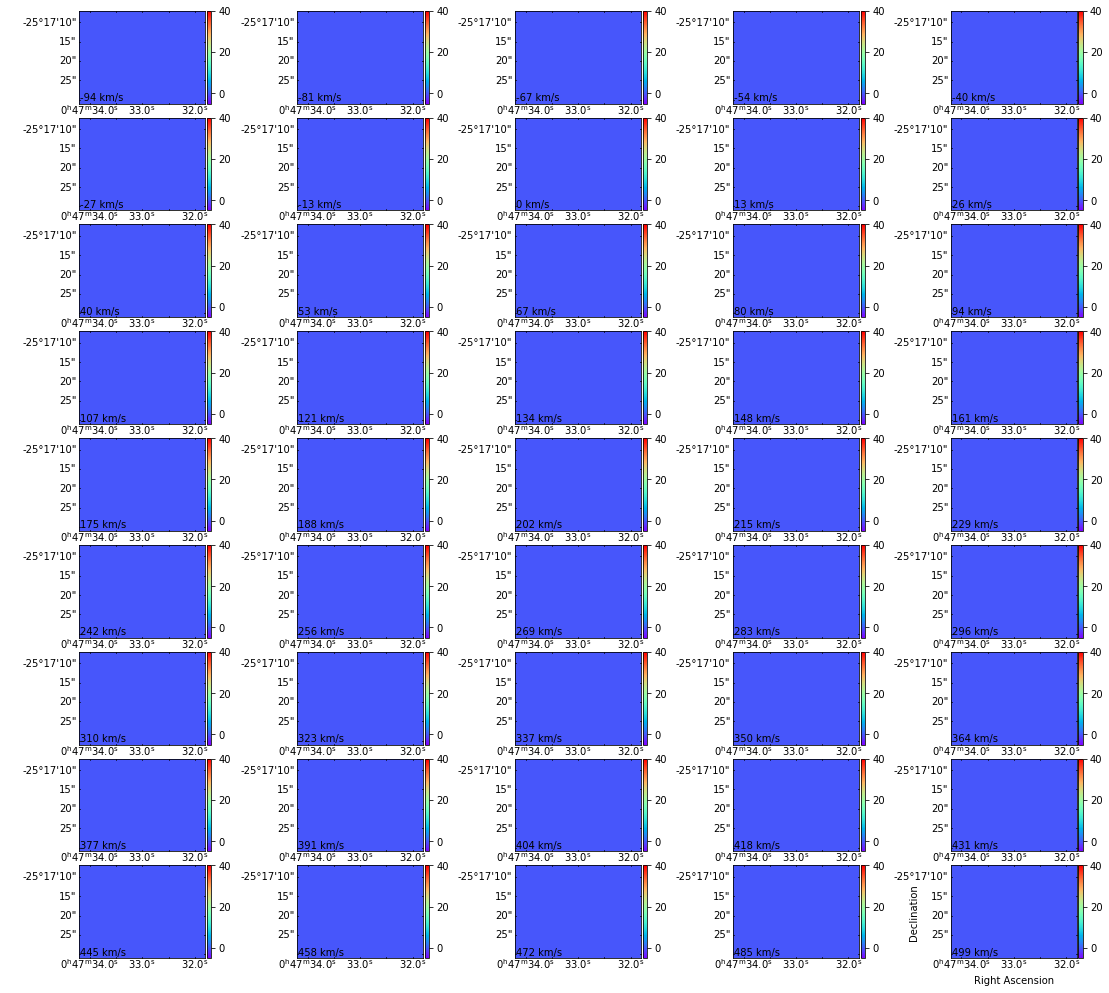

In [11]:




#H13CO+_J1-0, 86.754330 GHz, ref: https://iopscience.iop.org/article/10.1086/497881/pdf


#_and_SiO_J2-1 86.846998 GHz

# Use this to find freq range: regpix.meta['restfreq'] = [100 * u.GHz] # rest frequency 


#Here we specify the frequency and range of velocities (up to 320 m/s) and make a cube with only the H13CO+ data

path = 'H13COp_J1-0_SiO_J2-1.cube.fits'

cubeB = SpectralCube.read(path)


regpix = regions.RectanglePixelRegion(regions.PixCoord(int(cubeB.shape[1]/2), int(cubeB.shape[1]/2)), width=int(cubeB.shape[1]-1), height=int(cubeB.shape[1]-1))  
regpix.meta['range'] = [-50 * u.km/u.s, 550 * u.km/u.s] # spectral range 
regpix.meta['restfreq'] = 86.75428840*u.GHz # rest frequency of H13CO+ J1-0
#print(type(regpix.meta['restfreq']))
regpix.meta['veltype'] = 'OPTICAL' # velocity convention 
scb = cubeB.subcube_from_regions([regpix])  #Make the subcube with the specified frequency

sc = scb.with_spectral_unit(u.km/u.s,velocity_convention="radio",rest_value=86.75428840*u.GHz)
cen_p1 = SkyCoord('00h47m34.2s', '-25d17m31s', frame='icrs')
cen_p2 = SkyCoord('00h47m31.8s', '-25d17m07s', frame='icrs')
scW = cubeB.wcs[:][:][0]
raDP1 = [int(scW.world_to_pixel(cen_p1)[0]),int(scW.world_to_pixel(cen_p1)[1])]
raDP2 = [int(scW.world_to_pixel(cen_p2)[0]),int(scW.world_to_pixel(cen_p2)[1])]


scN = cubeB[:,raDP1[1]:raDP2[1],raDP1[0]:raDP2[0]] # Make a subcube based on position


scW = scN.wcs[:][:][0]

#####

SC_KMS = scN.with_spectral_unit(u.km/u.s,velocity_convention="radio")
SC_KMS.allow_huge_operations=True
SC_K_KMS = SC_KMS#.to(u.K)
SC_K_KMS.write("H13CO_Plus_1_0.fits",overwrite=True)

SC_K_KMS_slab = SC_K_KMS.spectral_slab(-100. *u.km / u.s, 500. *u.km / u.s)  # Extract a subset of the velocities
SC_Bin = SC_K_KMS_slab.downsample_axis(4,axis=0) # Here we use downsampling to bin (average)the data 
                                                # into coarse bins (broad channels) with width ~ 11 km/s    

vel, dec, ra = SC_Bin.world[:,0,0]           # For plotting purposes, I want to know the average velocity
                                                # for each of these new averaged channels
fig1 = pylab.figure(1,figsize=(15,15))
for i in np.arange(0,len(SC_Bin.hdu.data)):                       # Now we loop through each slice (averaged channels) 
    ax = pylab.subplot(10,5,i+1,projection=scW) # We plot them in a grid
    #Create e^intesity plots
    im = pylab.imshow(SC_Bin.hdu.data[i],cmap='rainbow',vmin=-5,vmax=40)
    
    RA = ax.coords[0]                                                                  
    Dec = ax.coords[1]
    RA.set_ticks(size=-1)                                                                                      
    Dec.set_ticks(size=-1) 
    RA.set_ticklabel(exclude_overlapping=True)
    Dec.set_ticklabel(exclude_overlapping=True) 
    pylab.text(10,25,s="%i km/s"%(vel.value[i]),fontsize=10) # Print the velocity of each averaged channel
    cb=pylab.colorbar(im,fraction=0.035,pad=0.01) 
    if i==len(SC_Bin.hdu.data)-1:
        pylab.xlabel("Right Ascension")
        pylab.ylabel("Declination",labelpad=-2)
    else:
        pylab.xlabel(" ")
        pylab.ylabel(" ") 
    pylab.tight_layout(w_pad=5,h_pad=1)



fig1.savefig(bbox_inches='tight',fname="NGC253.H13CO+_J1-0_CM.jpeg")

ValueError: num must be 1 <= num <= 50, not 51

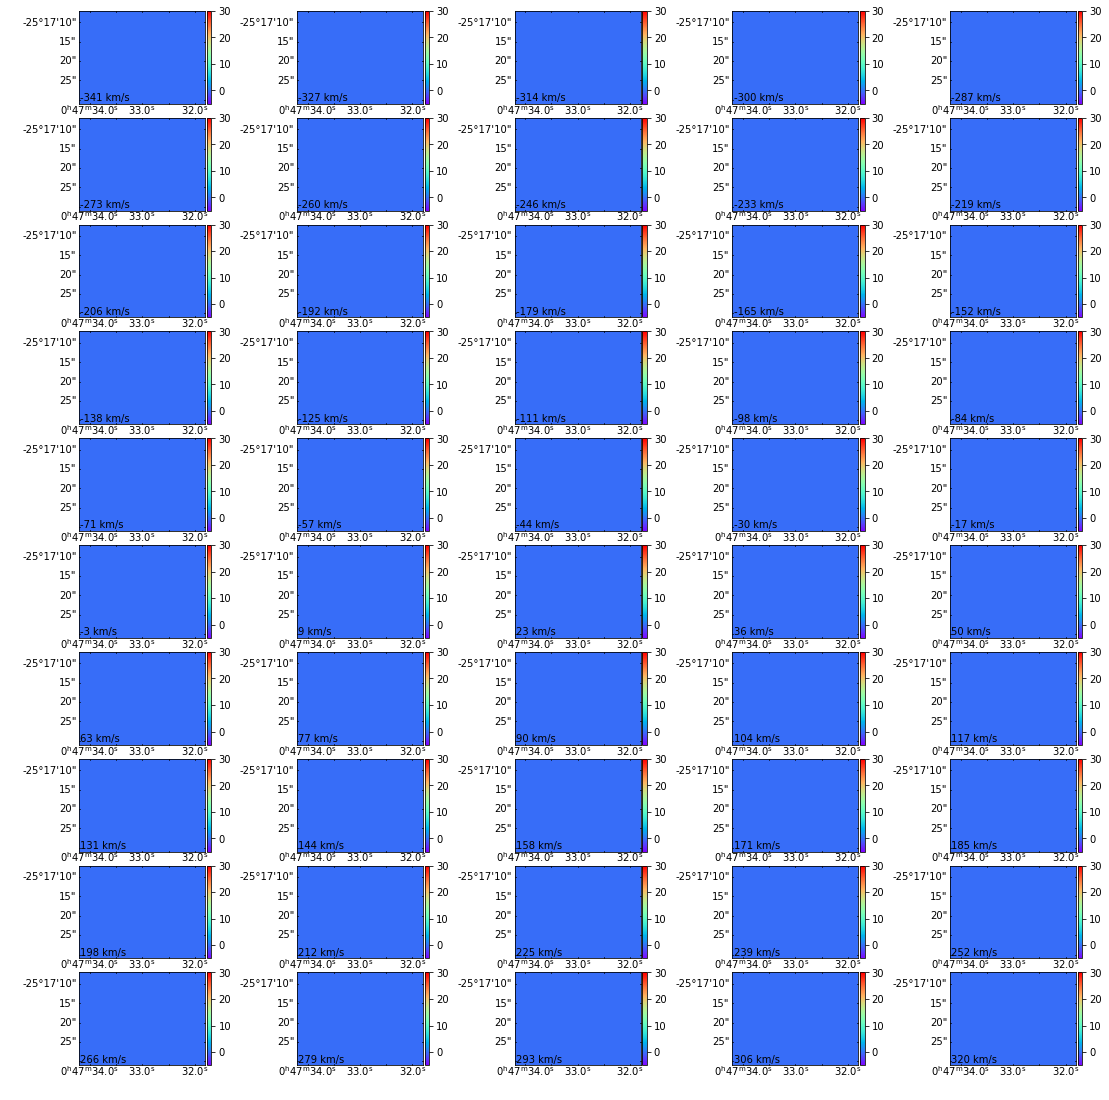

In [10]:
#H13CO+_J1-0, 86.754330 GHz, ref: https://iopscience.iop.org/article/10.1086/497881/pdf


#_and_SiO_J2-1 86.846998 GHz

# Use this to find freq range: regpix.meta['restfreq'] = [100 * u.GHz] # rest frequency 


#Here we specify the frequency and range of velocities (up to 320 m/s) and make a cube with only the H13CO+ data

path = 'H13COp_J1-0_SiO_J2-1.cube.fits'

cubeB = SpectralCube.read(path)


regpix = regions.RectanglePixelRegion(regions.PixCoord(int(cubeB.shape[1]/2), int(cubeB.shape[1]/2)), width=int(cubeB.shape[1]-1), height=int(cubeB.shape[1]-1))  
regpix.meta['range'] = [-50 * u.km/u.s, 550 * u.km/u.s] # spectral range 
regpix.meta['restfreq'] = 86.84696000*u.GHz # rest frequency of SiOJ2-1
#print(type(regpix.meta['restfreq']))
regpix.meta['veltype'] = 'OPTICAL' # velocity convention 
scb = cubeB.subcube_from_regions([regpix])  #Make the subcube with the specified frequency

sc = scb.with_spectral_unit(u.km/u.s,velocity_convention="radio",rest_value=86.84696000*u.GHz)
cen_p1 = SkyCoord('00h47m34.2s', '-25d17m31s', frame='icrs')
cen_p2 = SkyCoord('00h47m31.8s', '-25d17m07s', frame='icrs')
scW = cubeB.wcs[:][:][0]
raDP1 = [int(scW.world_to_pixel(cen_p1)[0]),int(scW.world_to_pixel(cen_p1)[1])]
raDP2 = [int(scW.world_to_pixel(cen_p2)[0]),int(scW.world_to_pixel(cen_p2)[1])]


scN = cubeB[:,raDP1[1]:raDP2[1],raDP1[0]:raDP2[0]] # Make a subcube based on position


scW = scN.wcs[:][:][0]

#####

SC_KMS = scN.with_spectral_unit(u.km/u.s,velocity_convention="radio")
SC_KMS.allow_huge_operations=True
SC_K_KMS = SC_KMS#.to(u.K)
SC_K_KMS.write("SiO_2_1.fits",overwrite=True)

SC_K_KMS_slab = SC_K_KMS.spectral_slab(-500. *u.km / u.s, 500. *u.km / u.s)  # Extract a subset of the velocities
SC_Bin = SC_K_KMS_slab.downsample_axis(4,axis=0) # Here we use downsampling to bin (average)the data 
                                                # into coarse bins (broad channels) with width ~ 11 km/s    

vel, dec, ra = SC_Bin.world[:,0,0]           # For plotting purposes, I want to know the average velocity
                                                # for each of these new averaged channels
fig1 = pylab.figure(1,figsize=(15,15))
for i in np.arange(0,len(SC_Bin.hdu.data)):                       # Now we loop through each slice (averaged channels) 
    ax = pylab.subplot(10,5,i+1,projection=scW) # We plot them in a grid
    #Create e^intesity plots
    im = pylab.imshow(SC_Bin.hdu.data[i],cmap='rainbow',vmin=-5,vmax=30)
    
    RA = ax.coords[0]                                                                  
    Dec = ax.coords[1]
    RA.set_ticks(size=-1)                                                                                      
    Dec.set_ticks(size=-1) 
    RA.set_ticklabel(exclude_overlapping=True)
    Dec.set_ticklabel(exclude_overlapping=True) 
    pylab.text(10,25,s="%i km/s"%(vel.value[i]),fontsize=10) # Print the velocity of each averaged channel
    cb=pylab.colorbar(im,fraction=0.035,pad=0.01) 
    if i==len(SC_Bin.hdu.data)-1:
        pylab.xlabel("Right Ascension")
        pylab.ylabel("Declination",labelpad=-2)
    else:
        pylab.xlabel(" ")
        pylab.ylabel(" ") 
    pylab.tight_layout(w_pad=5,h_pad=1)



fig1.savefig(bbox_inches='tight',fname="NGC253.SiO_J2-1_CM.jpeg")

In [ ]:


#####Zoom in

sc = SpectralCube.read('H13CN_J1-0.cube.fits') 


cen_p1 = SkyCoord('00h47m34.2s', '-25d17m31s', frame='icrs')
cen_p2 = SkyCoord('00h47m31.8s', '-25d17m07s', frame='icrs')

scW = sc.wcs[:][:][0]

raDP1 = [int(scW.world_to_pixel(cen_p1)[0]),int(scW.world_to_pixel(cen_p1)[1])]
raDP2 = [int(scW.world_to_pixel(cen_p2)[0]),int(scW.world_to_pixel(cen_p2)[1])]

scN = sc[:,raDP1[1]:raDP2[1],raDP1[0]:raDP2[0]] # Make a subcube based on position
scW = scN.wcs[:][:][0]
#####

SC_KMS = scN.with_spectral_unit(u.km/u.s,velocity_convention="radio")
SC_KMS.allow_huge_operations=True
SC_K_KMS = SC_KMS.to(u.K)


SC_K_KMS_slab = SC_K_KMS.spectral_slab(-100. *u.km / u.s, 500. *u.km / u.s)  # Extract a subset of the velocities
SC_Bin = SC_K_KMS_slab.downsample_axis(8,axis=0) # Here we use downsampling to bin (average)the data 
                                                # into coarse bins (broad channels) with width ~ 11 km/s    

vel, dec, ra = SC_Bin.world[:,0,0]           # For plotting purposes, I want to know the average velocity
                                                # for each of these new averaged channels
fig1 = pylab.figure(1,figsize=(15,15))
for i in np.arange(0,len(SC_Bin.hdu.data)):                       # Now we loop through each slice (averaged channels) 
    ax = pylab.subplot(10,5,i+1,projection=scW) # We plot them in a grid
    #Create e^intesity plots
    im = pylab.imshow(SC_Bin.hdu.data[i],cmap='rainbow',vmin=-.2,vmax=3)
    
    RA = ax.coords[0]                                                                  
    Dec = ax.coords[1]
    RA.set_ticks(size=-1)                                                                                      
    Dec.set_ticks(size=-1) 
    RA.set_ticklabel(exclude_overlapping=True)
    Dec.set_ticklabel(exclude_overlapping=True) 
    pylab.text(10,25,s="%i km/s"%(vel.value[i]),fontsize=10) # Print the velocity of each averaged channel
    cb=pylab.colorbar(im,fraction=0.035,pad=0.01) 
    if i==len(SC_Bin.hdu.data)-1:
        pylab.xlabel("Right Ascension")
        pylab.ylabel("Declination",labelpad=-2)
    else:
        pylab.xlabel(" ")
        pylab.ylabel(" ") 
    pylab.tight_layout(w_pad=5.3,h_pad=1)



fig1.savefig(bbox_inches='tight',fname="NGC253.H13CN_1-0_CM.jpeg")

In [ ]:


#####Zoom in

sc = SpectralCube.read('ngc253_co32_hires_common.fits') 


cen_p1 = SkyCoord('00h47m34.2s', '-25d17m31s', frame='icrs')
cen_p2 = SkyCoord('00h47m31.8s', '-25d17m07s', frame='icrs')
scW = sc.wcs[:][:][0]

raDP1 = [int(scW.world_to_pixel(cen_p1)[0]),int(scW.world_to_pixel(cen_p1)[1])]
raDP2 = [int(scW.world_to_pixel(cen_p2)[0]),int(scW.world_to_pixel(cen_p2)[1])]

scN = sc[:,raDP1[1]:raDP2[1],raDP1[0]:raDP2[0]] # Make a subcube based on position
scW = scN.wcs[:][:][0]
#####

SC_KMS = scN.with_spectral_unit(u.km/u.s,velocity_convention="radio")
SC_KMS.allow_huge_operations=True
SC_K_KMS = SC_KMS.to(u.K)


SC_K_KMS_slab = SC_K_KMS.spectral_slab(-200. *u.km / u.s, 700. *u.km / u.s)  # Extract a subset of the velocities
SC_Bin = SC_K_KMS_slab.downsample_axis(4,axis=0) # Here we use downsampling to bin (average)the data 
                                                # into coarse bins (broad channels) with width ~ 11 km/s    

vel, dec, ra = SC_Bin.world[:,0,0]           # For plotting purposes, I want to know the average velocity
                                                # for each of these new averaged channels
fig1 = pylab.figure(1,figsize=(15,15))
for i in np.arange(0,len(SC_Bin.hdu.data)):                       # Now we loop through each slice (averaged channels) 
    ax = pylab.subplot(10,5,i+1,projection=scW) # We plot them in a grid
    #Create e^intesity plots
    im = pylab.imshow(SC_Bin.hdu.data[i],cmap='rainbow',vmin=-5,vmax=50)
    
    RA = ax.coords[0]                                                                  
    Dec = ax.coords[1]
    RA.set_ticks(size=-1)                                                                                      
    Dec.set_ticks(size=-1) 
    RA.set_ticklabel(exclude_overlapping=True)
    Dec.set_ticklabel(exclude_overlapping=True) 
    pylab.text(10,25,s="%i km/s"%(vel.value[i]),fontsize=10) # Print the velocity of each averaged channel
    cb=pylab.colorbar(im,fraction=0.035,pad=0.01) 
    if i==len(SC_Bin.hdu.data)-1:
        pylab.xlabel("Right Ascension")
        pylab.ylabel("Declination",labelpad=-2)
    else:
        pylab.xlabel(" ")
        pylab.ylabel(" ") 
    pylab.tight_layout(w_pad=5,h_pad=1)



fig1.savefig(bbox_inches='tight',fname="NGC253.CO_3-2_CM.jpeg")

# Part 5: PV Plots

In [ ]:
sc = SpectralCube.read('CMZ_3mm_HCO+.fits') 


cen_p1 = SkyCoord('00h47m34.2s', '-25d17m31s', frame='icrs')
cen_p2 = SkyCoord('00h47m31.8s', '-25d17m07s', frame='icrs')

scW = sc.wcs[:][:][0]

raDP1 = [int(scW.world_to_pixel(cen_p1)[0]),int(scW.world_to_pixel(cen_p1)[1])]
raDP2 = [int(scW.world_to_pixel(cen_p2)[0]),int(scW.world_to_pixel(cen_p2)[1])]

Dec_slice = int((raDP2[1]+raDP1[1])/2)                                    
    
scN = sc[:,:,raDP1[0]:raDP2[0]] # Make a subcube based on position
scW = scN.wcs[:][:][0]
#####

SC_KMS = scN.with_spectral_unit(u.km/u.s,velocity_convention="radio")
SC_KMS.allow_huge_operations=True
SC_K_KMS = SC_KMS.to(u.K)


SC_K_KMS_slab = SC_K_KMS.spectral_slab(100 *u.km / u.s, 400. *u.km / u.s)  # Extract a subset of the velocities

    
    
    
    
fig = pylab.figure(1,figsize=(10, 10))         # Initiate a figure and axis object with WCS projection information



# Here we have specified to plot the longitude along the x axis
                                            # We also plot only the Declination slice we have chosen, 
                                            # and plot the velocity along the y axis
ax = fig.add_subplot(111, projection=SC_K_KMS_slab.wcs, slices=('x', Dec_slice, 'y'))
RA = ax.coords[0]
Dec = ax.coords[1]
velo = ax.coords[2]

im = ax.imshow(SC_K_KMS_slab[:,Dec_slice,:].data)  # Display the image slice 
ax.set_aspect(aspect=2)

                                            # Add axes labels
ax.set_ylabel("LSR Velocity (m/s)", fontsize=16)
ax.set_xlabel("Right Ascension", fontsize=8)
velo.set_ticks(size=-2)                                                                                      
RA.set_ticks(size=-2)
                            
Dec.set_ticks_visible(False)                # Don't show a "Declination" axis because we have eliminated it
Dec.set_ticklabel_visible(False) 

                                            # Do add a colorbar
cbar = pylab.colorbar(im, pad=.07, orientation='horizontal')
cbar.set_label('Brightness Temperature (K)', size=16)

ax.set_title("NGC253.HCO+_4-3.pbcor.fits")
fig.savefig(bbox_inches='tight',fname="NGC253.HCO+_4-3_PV.jpeg")

In [ ]:
sc = SpectralCube.read('CMZ_3mm_HCN.fits') 


cen_p1 = SkyCoord('00h47m34.2s', '-25d17m31s', frame='icrs')
cen_p2 = SkyCoord('00h47m31.8s', '-25d17m07s', frame='icrs')

scW = sc.wcs[:][:][0]

raDP1 = [int(scW.world_to_pixel(cen_p1)[0]),int(scW.world_to_pixel(cen_p1)[1])]
raDP2 = [int(scW.world_to_pixel(cen_p2)[0]),int(scW.world_to_pixel(cen_p2)[1])]

Dec_slice = int((raDP2[1]+raDP1[1])/2)                                    
    
scN = sc[:,:,raDP1[0]:raDP2[0]] # Make a subcube based on position
scW = scN.wcs[:][:][0]
#####

SC_KMS = scN.with_spectral_unit(u.km/u.s,velocity_convention="radio")
SC_KMS.allow_huge_operations=True
SC_K_KMS = SC_KMS.to(u.K)


SC_K_KMS_slab = SC_K_KMS.spectral_slab(100 *u.km / u.s, 400. *u.km / u.s)  # Extract a subset of the velocities

    
    
    
    
fig = pylab.figure(1,figsize=(10, 10))         # Initiate a figure and axis object with WCS projection information



# Here we have specified to plot the longitude along the x axis
                                            # We also plot only the Declination slice we have chosen, 
                                            # and plot the velocity along the y axis
ax = fig.add_subplot(111, projection=SC_K_KMS_slab.wcs, slices=('x', Dec_slice, 'y'))
RA = ax.coords[0]
Dec = ax.coords[1]
velo = ax.coords[2]

im = ax.imshow(SC_K_KMS_slab[:,Dec_slice,:].data)  # Display the image slice 
ax.set_aspect(aspect=2)

                                            # Add axes labels
ax.set_ylabel("LSR Velocity (m/s)", fontsize=16)
ax.set_xlabel("Right Ascension", fontsize=8)
velo.set_ticks(size=-2)                                                                                      
RA.set_ticks(size=-2)
                            
Dec.set_ticks_visible(False)                # Don't show a "Declination" axis because we have eliminated it
Dec.set_ticklabel_visible(False) 

                                            # Do add a colorbar
cbar = pylab.colorbar(im, pad=.07, orientation='horizontal')
cbar.set_label('Brightness Temperature (K)', size=16)

ax.set_title("NGC253.HCN_4-3.pbcor.fits")
fig.savefig(bbox_inches='tight',fname="NGC253.HCN_4-3_PV.jpeg")

In [ ]:
sc = SpectralCube.read('CMZ_3mm_H13CN.fits') 


cen_p1 = SkyCoord('00h47m34.2s', '-25d17m31s', frame='icrs')
cen_p2 = SkyCoord('00h47m31.8s', '-25d17m07s', frame='icrs')

scW = sc.wcs[:][:][0]

raDP1 = [int(scW.world_to_pixel(cen_p1)[0]),int(scW.world_to_pixel(cen_p1)[1])]
raDP2 = [int(scW.world_to_pixel(cen_p2)[0]),int(scW.world_to_pixel(cen_p2)[1])]

Dec_slice = int((raDP2[1]+raDP1[1])/2)                                    
    
scN = sc[:,:,raDP1[0]:raDP2[0]] # Make a subcube based on position
scW = scN.wcs[:][:][0]
#####

SC_KMS = scN.with_spectral_unit(u.km/u.s,velocity_convention="radio")
SC_KMS.allow_huge_operations=True
SC_K_KMS = SC_KMS.to(u.K)


SC_K_KMS_slab = SC_K_KMS.spectral_slab(100 *u.km / u.s, 400. *u.km / u.s)  # Extract a subset of the velocities

    
    
    
    
fig = pylab.figure(1,figsize=(10, 10))         # Initiate a figure and axis object with WCS projection information



# Here we have specified to plot the longitude along the x axis
                                            # We also plot only the Declination slice we have chosen, 
                                            # and plot the velocity along the y axis
ax = fig.add_subplot(111, projection=SC_K_KMS_slab.wcs, slices=('x', Dec_slice, 'y'))
RA = ax.coords[0]
Dec = ax.coords[1]
velo = ax.coords[2]

im = ax.imshow(SC_K_KMS_slab[:,Dec_slice,:].data)  # Display the image slice 
ax.set_aspect(aspect=2)

                                            # Add axes labels
ax.set_ylabel("LSR Velocity (m/s)", fontsize=16)
ax.set_xlabel("Right Ascension", fontsize=8)
velo.set_ticks(size=-2)                                                                                      
RA.set_ticks(size=-2)
                            
Dec.set_ticks_visible(False)                # Don't show a "Declination" axis because we have eliminated it
Dec.set_ticklabel_visible(False) 

                                            # Do add a colorbar
cbar = pylab.colorbar(im, pad=.07, orientation='horizontal')
cbar.set_label('Brightness Temperature (K)', size=16)

ax.set_title("NGC253.H13CN_4-3.pbcor.fits")
fig.savefig(bbox_inches='tight',fname="NGC253.H13CN_4-3_PV.jpeg")

In [ ]:
sc = SpectralCube.read('HCN_J1-0.cube.fits') 


cen_p1 = SkyCoord('00h47m34.2s', '-25d17m31s', frame='icrs')
cen_p2 = SkyCoord('00h47m31.8s', '-25d17m07s', frame='icrs')

scW = sc.wcs[:][:][0]

raDP1 = [int(scW.world_to_pixel(cen_p1)[0]),int(scW.world_to_pixel(cen_p1)[1])]
raDP2 = [int(scW.world_to_pixel(cen_p2)[0]),int(scW.world_to_pixel(cen_p2)[1])]

Dec_slice = int((raDP2[1]+raDP1[1])/2)                                    
    
scN = sc[:,:,raDP1[0]:raDP2[0]] # Make a subcube based on position
scW = scN.wcs[:][:][0]
#####

SC_KMS = scN.with_spectral_unit(u.km/u.s,velocity_convention="radio")
SC_KMS.allow_huge_operations=True
SC_K_KMS = SC_KMS.to(u.K)

SC_K_KMS_slab = SC_K_KMS.spectral_slab(100 *u.km / u.s, 400. *u.km / u.s)  # Extract a subset of the velocities

    
    
    
    
fig = pylab.figure(1,figsize=(10, 10))         # Initiate a figure and axis object with WCS projection information



# Here we have specified to plot the longitude along the x axis
                                            # We also plot only the Declination slice we have chosen, 
                                            # and plot the velocity along the y axis
ax = fig.add_subplot(111, projection=SC_K_KMS_slab.wcs, slices=('x', Dec_slice, 'y'))
RA = ax.coords[0]
Dec = ax.coords[1]
velo = ax.coords[2]

im = ax.imshow(SC_K_KMS_slab[:,Dec_slice,:].data)  # Display the image slice 
ax.set_aspect(aspect=1)

                                            # Add axes labels
ax.set_ylabel("LSR Velocity (m/s)", fontsize=16)
ax.set_xlabel("Right Ascension", fontsize=8)
velo.set_ticks(size=-2)                                                                                      
RA.set_ticks(size=-2)
                            
Dec.set_ticks_visible(False)                # Don't show a "Declination" axis because we have eliminated it
Dec.set_ticklabel_visible(False) 

                                            # Do add a colorbar
cbar = pylab.colorbar(im, pad=.07, orientation='horizontal')
cbar.set_label('Brightness Temperature (K)', size=16)

ax.set_title("NGC253.HCN_1-0.pbcor.fits")
fig.savefig(bbox_inches='tight',fname="NGC253.HCN_1-0_PV.jpeg")

In [ ]:
#H13CO+_J1-0, 86.754330 GHz, ref: https://iopscience.iop.org/article/10.1086/497881/pdf


#_and_SiO_J2-1 86.846998 GHz

# Use this to find freq range: regpix.meta['restfreq'] = [100 * u.GHz] # rest frequency 


#Here we specify the frequency and range of velocities (up to 320 m/s) and make a cube with only the H13CO+ data

path = 'H13COp_J1-0_SiO_J2-1.cube.fits'

cubeB = SpectralCube.read(path)


regpix = regions.RectanglePixelRegion(regions.PixCoord(int(cubeB.shape[1]/2), int(cubeB.shape[1]/2)), width=int(cubeB.shape[1]-1), height=int(cubeB.shape[1]-1))  
regpix.meta['range'] = [100 * u.km/u.s, 300 * u.km/u.s] # spectral range 
regpix.meta['restfreq'] = 86.754330*u.GHz # rest frequency of H13CO+
#print(type(regpix.meta['restfreq']))
regpix.meta['veltype'] = 'OPTICAL' # velocity convention 
scb = cubeB.subcube_from_regions([regpix])  #Make the subcube with the specified frequency
cube = scb.with_spectral_unit(u.km/u.s,velocity_convention="radio",rest_value=86.754330*u.GHz)
cen_p1 = SkyCoord('00h47m34.2s', '-25d17m31s', frame='icrs')
cen_p2 = SkyCoord('00h47m31.8s', '-25d17m07s', frame='icrs')
scW = cube.wcs[:][:][0]
raDP1 = [int(scW.world_to_pixel(cen_p1)[0]),int(scW.world_to_pixel(cen_p1)[1])]
raDP2 = [int(scW.world_to_pixel(cen_p2)[0]),int(scW.world_to_pixel(cen_p2)[1])]

Dec_slice = int((raDP2[1]+raDP1[1])/2)   

scN = cube[:,raDP1[1]:raDP2[1],:] # Make a subcube based on position

#####

SC_KMS = scN.with_spectral_unit(u.km/u.s,velocity_convention="radio")
SC_KMS.allow_huge_operations=True
SC_K_KMS = SC_KMS.to(u.K)


SC_K_KMS_slab = SC_K_KMS.spectral_slab(100 *u.km / u.s, 400. *u.km / u.s)  # Extract a subset of the velocities

    
    
    
    
fig = pylab.figure(1,figsize=(10, 10))         # Initiate a figure and axis object with WCS projection information



# Here we have specified to plot the longitude along the x axis
                                            # We also plot only the Declination slice we have chosen, 
                                            # and plot the velocity along the y axis
ax = fig.add_subplot(111, projection=SC_K_KMS_slab.wcs, slices=('x', Dec_slice, 'y'))
RA = ax.coords[0]
Dec = ax.coords[1]
velo = ax.coords[2]

im = ax.imshow(SC_K_KMS_slab[:,Dec_slice,:].data)  # Display the image slice 
ax.set_aspect(aspect=4)

                                            # Add axes labels
ax.set_ylabel("LSR Velocity (m/s)", fontsize=16)
ax.set_xlabel("Right Ascension", fontsize=8)
velo.set_ticks(size=-2)                                                                                      
RA.set_ticks(size=-2)
                            
Dec.set_ticks_visible(False)                # Don't show a "Declination" axis because we have eliminated it
Dec.set_ticklabel_visible(False) 

                                            # Do add a colorbar
cbar = pylab.colorbar(im, pad=.07, orientation='horizontal')
cbar.set_label('Brightness Temperature (K)', size=16)

ax.set_title("H13COp_J1-0_SiO_J2-1.cube.fits (H13CO+)")
fig.savefig(bbox_inches='tight',fname="NGC253.H13CO+_1-0_PV.jpeg")

In [ ]:
#H13CO+_J1-0, 86.754330 GHz, ref: https://iopscience.iop.org/article/10.1086/497881/pdf


#_and_SiO_J2-1 86.846998 GHz

# Use this to find freq range: regpix.meta['restfreq'] = [100 * u.GHz] # rest frequency 


#Here we specify the frequency and range of velocities (up to 320 m/s) and make a cube with only the H13CO+ data

path = 'H13COp_J1-0_SiO_J2-1.cube.fits'

cubeB = SpectralCube.read(path)


regpix = regions.RectanglePixelRegion(regions.PixCoord(int(cubeB.shape[1]/2), int(cubeB.shape[1]/2)), width=int(cubeB.shape[1]-1), height=int(cubeB.shape[1]-1))  
regpix.meta['range'] = [100 * u.km/u.s, 300 * u.km/u.s] # spectral range 
regpix.meta['restfreq'] = 86.846998*u.GHz # rest frequency of SiOJ2-1
#print(type(regpix.meta['restfreq']))
regpix.meta['veltype'] = 'OPTICAL' # velocity convention 
scb = cubeB.subcube_from_regions([regpix])  #Make the subcube with the specified frequency
cube = scb.with_spectral_unit(u.km/u.s,velocity_convention="radio",rest_value=86.846998*u.GHz)
cen_p1 = SkyCoord('00h47m34.2s', '-25d17m31s', frame='icrs')
cen_p2 = SkyCoord('00h47m31.8s', '-25d17m07s', frame='icrs')
scW = cube.wcs[:][:][0]
raDP1 = [int(scW.world_to_pixel(cen_p1)[0]),int(scW.world_to_pixel(cen_p1)[1])]
raDP2 = [int(scW.world_to_pixel(cen_p2)[0]),int(scW.world_to_pixel(cen_p2)[1])]

Dec_slice = int((raDP2[1]+raDP1[1])/2)   

scN = cube[:,raDP1[1]:raDP2[1],:] # Make a subcube based on position

#####

SC_KMS = scN.with_spectral_unit(u.km/u.s,velocity_convention="radio")
SC_KMS.allow_huge_operations=True
SC_K_KMS = SC_KMS.to(u.K)


SC_K_KMS_slab = SC_K_KMS.spectral_slab(-100. *u.km / u.s, 500. *u.km / u.s)  # Extract a subset of the velocities


fig = pylab.figure(1,figsize=(10, 10))         # Initiate a figure and axis object with WCS projection information



# Here we have specified to plot the longitude along the x axis
                                            # We also plot only the Declination slice we have chosen, 
                                            # and plot the velocity along the y axis
ax = fig.add_subplot(111, projection=SC_K_KMS_slab.wcs, slices=('x', Dec_slice, 'y'))
RA = ax.coords[0]
Dec = ax.coords[1]
velo = ax.coords[2]

im = ax.imshow(SC_K_KMS_slab[:,Dec_slice,:].data)  # Display the image slice 
ax.set_aspect(aspect=8)

                                            # Add axes labels
ax.set_ylabel("LSR Velocity (m/s)", fontsize=16)
ax.set_xlabel("Right Ascension", fontsize=8)
velo.set_ticks(size=-2)                                                                                      
RA.set_ticks(size=-2)
                            
Dec.set_ticks_visible(False)                # Don't show a "Declination" axis because we have eliminated it
Dec.set_ticklabel_visible(False) 

                                            # Do add a colorbar
cbar = pylab.colorbar(im, pad=.07, orientation='horizontal')
cbar.set_label('Brightness Temperature (K)', size=16)

ax.set_title("H13COp_J1-0_SiO_J2-1.cube.fits (SiO)")
fig.savefig(bbox_inches='tight',fname="NGC253.SiO_2-1_PV.jpeg")

In [ ]:
sc = SpectralCube.read('H13CN_J1-0.cube.fits') 


cen_p1 = SkyCoord('00h47m34.2s', '-25d17m31s', frame='icrs')
cen_p2 = SkyCoord('00h47m31.8s', '-25d17m07s', frame='icrs')

scW = sc.wcs[:][:][0]

raDP1 = [int(scW.world_to_pixel(cen_p1)[0]),int(scW.world_to_pixel(cen_p1)[1])]
raDP2 = [int(scW.world_to_pixel(cen_p2)[0]),int(scW.world_to_pixel(cen_p2)[1])]

Dec_slice = int((raDP2[1]+raDP1[1])/2)                                    
    
scN = sc[:,:,raDP1[0]:raDP2[0]] # Make a subcube based on position
scW = scN.wcs[:][:][0]
#####

SC_KMS = scN.with_spectral_unit(u.km/u.s,velocity_convention="radio")
SC_KMS.allow_huge_operations=True
SC_K_KMS = SC_KMS.to(u.K)


SC_K_KMS_slab = SC_K_KMS.spectral_slab(-100. *u.km / u.s, 500. *u.km / u.s)  # Extract a subset of the velocities

    
    
    
    
fig = pylab.figure(1,figsize=(10, 10))         # Initiate a figure and axis object with WCS projection information



# Here we have specified to plot the longitude along the x axis
                                            # We also plot only the Declination slice we have chosen, 
                                            # and plot the velocity along the y axis
ax = fig.add_subplot(111, projection=SC_K_KMS_slab.wcs, slices=('x', Dec_slice, 'y'))
RA = ax.coords[0]
Dec = ax.coords[1]
velo = ax.coords[2]

im = ax.imshow(SC_K_KMS_slab[:,Dec_slice,:].data)  # Display the image slice 
ax.set_aspect(aspect=2)

                                            # Add axes labels
ax.set_ylabel("LSR Velocity (m/s)", fontsize=16)
ax.set_xlabel("Right Ascension", fontsize=8)
velo.set_ticks(size=-2)                                                                                      
RA.set_ticks(size=-2)
                            
Dec.set_ticks_visible(False)                # Don't show a "Declination" axis because we have eliminated it
Dec.set_ticklabel_visible(False) 

                                            # Do add a colorbar
cbar = pylab.colorbar(im, pad=.07, orientation='horizontal')
cbar.set_label('Brightness Temperature (K)', size=16)

ax.set_title("NGC253.H13CN_1-0.pbcor.fits")
fig.savefig(bbox_inches='tight',fname="NGC253.H13CN_1-0_PV.jpeg")

In [ ]:
sc = SpectralCube.read('ngc253_co32_hires_common.fits') 


cen_p1 = SkyCoord('00h47m34.2s', '-25d17m31s', frame='icrs')
cen_p2 = SkyCoord('00h47m31.8s', '-25d17m07s', frame='icrs')

scW = sc.wcs[:][:][0]

raDP1 = [int(scW.world_to_pixel(cen_p1)[0]),int(scW.world_to_pixel(cen_p1)[1])]
raDP2 = [int(scW.world_to_pixel(cen_p2)[0]),int(scW.world_to_pixel(cen_p2)[1])]

Dec_slice = int((raDP2[1]+raDP1[1])/2)                                    
    
scN = sc[:,:,raDP1[0]:raDP2[0]] # Make a subcube based on position
scW = scN.wcs[:][:][0]
#####

SC_KMS = scN.with_spectral_unit(u.km/u.s,velocity_convention="radio")
SC_KMS.allow_huge_operations=True
SC_K_KMS = SC_KMS.to(u.K)


SC_K_KMS_slab = SC_K_KMS.spectral_slab(-100. *u.km / u.s, 500. *u.km / u.s)  # Extract a subset of the velocities

    
    
    
    
fig = pylab.figure(1,figsize=(10, 10))         # Initiate a figure and axis object with WCS projection information



# Here we have specified to plot the longitude along the x axis
                                            # We also plot only the Declination slice we have chosen, 
                                            # and plot the velocity along the y axis
ax = fig.add_subplot(111, projection=SC_K_KMS_slab.wcs, slices=('x', Dec_slice, 'y'))
RA = ax.coords[0]
Dec = ax.coords[1]
velo = ax.coords[2]

im = ax.imshow(SC_K_KMS_slab[:,Dec_slice,:].data)  # Display the image slice 
ax.set_aspect(aspect=1)

                                            # Add axes labels
ax.set_ylabel("LSR Velocity (m/s)", fontsize=16)
ax.set_xlabel("Right Ascension", fontsize=8)
velo.set_ticks(size=-2)                                                                                      
RA.set_ticks(size=-2)
                            
Dec.set_ticks_visible(False)                # Don't show a "Declination" axis because we have eliminated it
Dec.set_ticklabel_visible(False) 

                                            # Do add a colorbar
cbar = pylab.colorbar(im, pad=.07, orientation='horizontal')
cbar.set_label('Brightness Temperature (K)', size=16)

ax.set_title("NGC253.CO_3-2.pbcor.fits")
fig.savefig(bbox_inches='tight',fname="NGC253.CO_3-2_PV.jpeg")

# Part 6: Reporojection

In [20]:
files = pylab.array(['CMZ_3mm_HCO+.fits','CMZ_3mm_HCN.fits','CMZ_3mm_H13CN.fits','CMZ_3mm_H13CO+.fits' ])
      



for i,file in enumerate(files):
    
    sc = SpectralCube.read(file) 
    #print(sc)
    if i==0:                                # Find location of brightest emission
        z,xp,yp = pylab.where(sc.hdu.data==np.nanmax(sc.hdu.data)) 
        yRaxDec = sc.wcs[:][:][0].pixel_to_world(yp,xp)
    y, x = sc.wcs[:][:][0].world_to_pixel(yRaxDec)# Gets the pixel for the same Ra/dec of each cube
    #print(x,y)
    #Need to reduce cube size, but it won't work if theyre all the same size sometimes?
    if i ==0:
        subcube = sc[:,int(x)-20:int(x)+20,int(y)-20:int(y)+20] # Make a subcube
    if i ==1:
        subcube = sc[:,int(x)-19:int(x)+19,int(y)-19:int(y)+19] # Make a subcube
    if i ==2:
        subcube = sc[:,int(x)-18:int(x)+18,int(y)-18:int(y)+18] # Make a subcube
    if i ==3:
        subcube = sc[:,int(x)-17:int(x)+17,int(y)-17:int(y)+17] # Make a subcube
    
    #print(subcube)
    
    sc_kms = subcube.with_spectral_unit(u.km/u.s,velocity_convention="radio") # Change units from Hz to km/s
    sc_slab = sc_kms.spectral_slab(-5000. *u.km / u.s, 5000. *u.km / u.s)  # Crop out velocities we don't care about    
    sc_slab.allow_huge_operations=True    
    sc_K_kms = sc_slab.to(u.K)
    print(sc_K_kms)
    
    
    
    if i==0:
        vel, dec, ra = sc_K_kms.world[:,0,0]            # Grab the velocity axis to use for rebinning
        
        #print(type(vel))
        vel = np.linspace(-300,300,1000)*u.km/u.s
        #print(type(vel))
        cmz_HCOp = sc_K_kms
        cmz_HCOpn = cmz_HCOp.spectral_interpolate(spectral_grid=vel) # Match velocities too         
        cmz_HCOpn.write('cmz_HCOp.cube.K-kms.pbcor.fits',overwrite=True)        
        #cmz_HCOp.write('cmz_HCOp.cube.K-kms.pbcor.fits',overwrite=True)        
    if i==1:      
        
        cmz_HCN = sc_K_kms.unmasked_copy()        
        #cmz_HCN.write('NGC253_HCN.cube.reproject.K-kms.pbcor.fits',overwrite=True)
        
    if i==2:
        cmz_H13CN = sc_K_kms.unmasked_copy()       
        
    if i==3:
        
        cmz_H13COp = sc_K_kms.unmasked_copy()
        
        

print("done")

SpectralCube with shape=(332, 40, 40) and unit=K:
 n_x:     40  type_x: GLON-SIN  unit_x: deg    range:   359.554937 deg:  359.684964 deg
 n_y:     40  type_y: GLAT-SIN  unit_y: deg    range:    -0.311663 deg:   -0.181661 deg
 n_s:    332  type_s: VRAD-W2F  unit_s: km / s  range:     -299.880 km / s:     299.846 km / s
SpectralCube with shape=(330, 38, 38) and unit=K:
 n_x:     38  type_x: GLON-SIN  unit_x: deg    range:   359.558271 deg:  359.681630 deg
 n_y:     38  type_y: GLAT-SIN  unit_y: deg    range:    -0.308330 deg:   -0.184994 deg
 n_s:    330  type_s: VRAD-W2F  unit_s: km / s  range:     -300.378 km / s:     299.469 km / s
SpectralCube with shape=(321, 36, 36) and unit=K:
 n_x:     36  type_x: GLON-SIN  unit_x: deg    range:   359.561605 deg:  359.678296 deg
 n_y:     36  type_y: GLAT-SIN  unit_y: deg    range:    -0.304996 deg:   -0.188327 deg
 n_s:    321  type_s: VRAD-W2F  unit_s: km / s  range:     -300.404 km / s:     298.523 km / s
SpectralCube with shape=(323, 34, 34)

In [21]:
cmz_HCN.allow_huge_operations=True
CMZh = cmz_HCOp.header
cmz_HCN_reproject = cmz_HCN.reproject(CMZh,use_memmap=True)         
cmz_HCN_reproject_interp = cmz_HCN_reproject.spectral_interpolate(spectral_grid=vel) # Match velocities too         
cmz_HCN_reproject_interp.write('cmz_HCN.cube.reproject.K-kms.pbcor.fits',overwrite=True)      
        
print("YESA")

YESA


In [22]:

cmz_H13CN.allow_huge_operations=True
CMZh = cmz_HCOp.header
cmz_H13CN_reproject = cmz_H13CN.reproject(CMZh,use_memmap=True)         
cmz_H13CN_reproject_interp = cmz_H13CN_reproject.spectral_interpolate(spectral_grid=vel) # Match velocities too         
cmz_H13CN_reproject_interp.write('cmz_H13CN.cube.reproject.K-kms.pbcor.fits',overwrite=True)      
        
print("YESA")

YESA


In [23]:

cmz_H13COp.allow_huge_operations=True
CMZh = cmz_HCOp.header
cmz_H13COp_reproject = cmz_H13COp.reproject(CMZh,use_memmap=True)         
cmz_H13COp_reproject_interp = cmz_H13COp_reproject.spectral_interpolate(spectral_grid=vel) # Match velocities too 

cmz_H13COp_reproject_interp.write('cmz_H13COp.cube.reproject.K-kms.pbcor.fits',overwrite=True)         
print("YESA")


YESA


In [ ]:
#All the cubes have been reprojected

# Part 7: Spectra

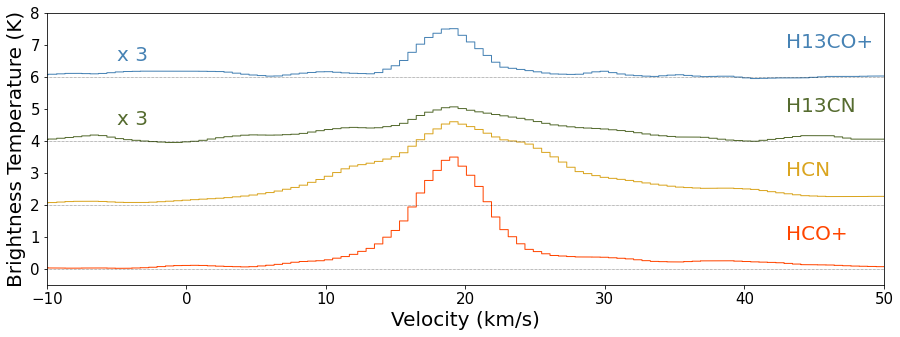

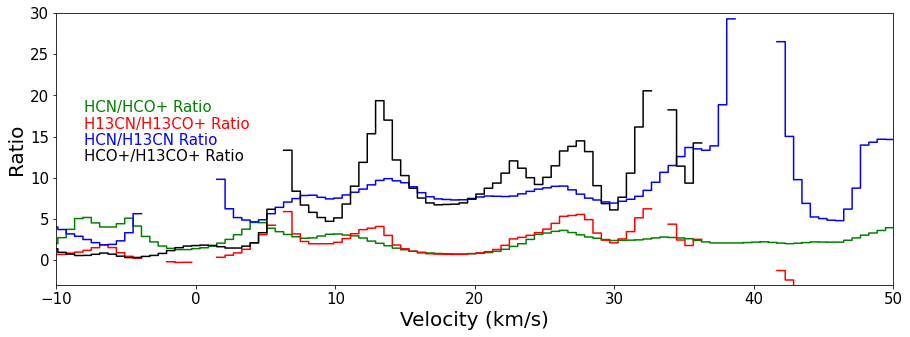

In [3]:
#Plot the first 3 spectra
#cmz_HCOp
#cmz_HCN
#cmz_H13CN
paths = pylab.array(['cmz_HCOp.cube.K-kms.pbcor.fits',
                     'cmz_HCN.cube.reproject.K-kms.pbcor.fits',
                     'cmz_H13CN.cube.reproject.K-kms.pbcor.fits',
                     'cmz_H13COp.cube.reproject.K-kms.pbcor.fits'])

                                            # Image-dependent plotting variables
scale = pylab.array([1,1,3,3])             # This is a factor for multiplying fainter spectra
colors = pylab.array(['OrangeRed','GoldenRod','DarkOliveGreen','SteelBlue'])
mols = pylab.array(['HCO+','HCN','H13CN','H13CO+']) #labels

                                            # Define the figure outside of loop b/c we don't need to do this 4x!
fig6 = pylab.figure(6,figsize=(15,5))
ax6=pylab.subplot() 
    
                                            # Loop through all 4 images
for i, path in enumerate(paths):
     
    
    sc = SpectralCube.read(path)
    vel, dec, ra = sc.world[:,0,0]          # For plotting purposes, I want to know the velocity for each channel
    if i==0:                                # Find location of brightest 13CO emission
        z,xp,yp = pylab.where(sc.hdu.data==np.nanmax(sc.hdu.data)) 
        yRaxDec = sc.wcs[:][:][0].pixel_to_world(yp,xp)
    y, x = sc.wcs[:][:][0].world_to_pixel(yRaxDec)# Gets the pixel for the same Ra/dec of each cube
    
                                            # Extract an average spectrum in a 20x20 pixel box
    
    subcube = sc.hdu.data[:,int(x)-1:int(x)+1,int(y)-1:int(y)+1] # Make a 20x20xN subcube
    spectrum = np.average(subcube,axis=(1,2))                        # Average in RA and Dec to get 1D spectrum


    if i==0:
        spectrum_1 = spectrum.copy()       # save this to calculate a ratio later
    if i==1:
        spectrum_2 = spectrum.copy()       # save this to calculate a ratio later
    if i==2:
        spectrum_3 = spectrum.copy()       # save this to calculate a ratio later
    if i==3:
        spectrum_4 = spectrum.copy()       # save this to calculate a ratio later
                
        
                                            # plot all spectra    
    ax6.plot(vel,spectrum*scale[i]+i*2,lw=1,drawstyle='steps-mid',color=colors[i])
    pylab.xlabel('Velocity (km/s)',fontsize=20)
    pylab.ylabel('Brightness Temperature (K)',fontsize=20)
    pylab.ylim(-.5,8)
    pylab.xlim(-10,50)
    pylab.axhline(i*2,color='black',ls=':',lw=0.5)
    pylab.text(43,i*2+.9,mols[i],color=colors[i],fontsize=20)
    if scale[i]!=1:
        pylab.text(-5,i*2+.5,"x %i"%scale[i],color=colors[i],fontsize=20)
    ax6.tick_params(axis = 'both', which = 'major', labelsize = 15)


                                            # Plot a figure showing the line ratio
                                            # If we hadn't forced all the images to have the same velocity axis
                                            # using spectral_interpolate this would throw a big error!!
                


spectrum_1T=spectrum_1.copy()
spectrum_2T=spectrum_2.copy()
spectrum_3T=spectrum_3.copy()
spectrum_4T=spectrum_4.copy()


badchan13 = pylab.where(abs(spectrum_1) < 0.01)
badchan18 = pylab.where(abs(spectrum_3) < 0.01)
spectrum_1T[badchan13] = np.nan
spectrum_3T[badchan18] = np.nan

badchan12 = pylab.where(abs(spectrum_2) < 0.01)
spectrum_2T[badchan12] = np.nan

badchan4 = pylab.where(abs(spectrum_4) < 0.01)
spectrum_4T[badchan4] = np.nan

fig7 = pylab.figure(7,figsize=(15,5))
ax7=pylab.subplot() 
ax7.plot(vel,spectrum_2T/spectrum_1T,drawstyle='steps-mid',color="Green")
ax7.plot(vel,spectrum_3T/spectrum_4T,drawstyle='steps-mid',color="Red")
ax7.plot(vel,spectrum_2T/spectrum_3T,drawstyle='steps-mid',color="Blue")
ax7.plot(vel,spectrum_1T/spectrum_4T,drawstyle='steps-mid',color="Black")
pylab.ylim(-3,30)
pylab.xlim(-10,50)
pylab.xlabel('Velocity (km/s)',fontsize=20)
pylab.ylabel('Ratio',fontsize=20)
ax7.tick_params(axis = 'both', which = 'major', labelsize = 15)
pylab.text(-8,18,"HCN/HCO+ Ratio",color="Green",fontsize=15)

pylab.text(-8,16,"H13CN/H13CO+ Ratio",color="Red",fontsize=15)
pylab.text(-8,14,"HCN/H13CN Ratio",color="Blue",fontsize=15)
pylab.text(-8,12,"HCO+/H13CO+ Ratio",color="Black",fontsize=15)
fig6.savefig(bbox_inches='tight',fname="CMZ_Spectra.png")
fig7.savefig(bbox_inches='tight',fname="CMZ_Spectra_Ratio.png")


In [2]:
#Spectra's Region, HCOP, HCN, H13CN J4-3


                                            # Define the figure outside of loop b/c we don't need to do this 4x!
fig1 = pylab.figure(figsize=(15,15))




new_path = 'cmz_HCOp.cube.K-kms.pbcor.fits' 
subcubeN = SpectralCube.read(new_path)#Get iamge #[:,int(x)-50:int(x)+50,int(y)-50:int(y)+50] #Create zoomed cube

mom_0_Sub = subcubeN.moment(order=0,how='slice')

scWCS = mom_0_Sub.wcs

y, x = subcubeN.wcs[:][:][0].world_to_pixel(yRaxDec)# Gets the pixel for the same Ra/dec of each cube

ax2 = pylab.subplot(4,1,1,projection=subcubeN.wcs[0]) 
mom_0_Sub = np.nansum(subcubeN,axis=0) 
RA = ax2.coords[0]                                                                  # hi
Dec = ax2.coords[1]
im2 = pylab.imshow(mom_0_Sub,cmap='rainbow')
RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3)    
pylab.plot(y,x,'+',ms=10,mec='black',mfc='black',mew=3.5,alpha=.5)
pylab.annotate("Spectral Subcube location (2x2)",(y,x+5))
pylab.xlabel('Right Ascension',fontsize=10,labelpad=1)                               
pylab.ylabel('Declination',fontsize=10,labelpad=0)
ax2.tick_params(axis = 'both', which = 'major', labelsize = 10)    
cb=pylab.colorbar(im2,fraction=0.046,pad=0.04)                                     
cb.set_label(label='Integrated Flux Density Targeted(K km/s)',fontsize=10,rotation=270,labelpad=20) 
cb.ax.tick_params(which = 'major', labelsize = 10 )   
pylab.annotate(s='Integrated Flux Density Targeted(K km/s)',fontsize=10,xy=(0.02,0.91),xycoords="axes fraction")  
RA.set_ticklabel(exclude_overlapping=True)
Dec.set_ticklabel(exclude_overlapping=True)
ax2.set_title("NGC253.HCO+_4-3.pbcor.fits")
pylab.tight_layout(w_pad=13,h_pad=1)
fig1.savefig(bbox_inches='tight',fname="NGC253_HCO+_With_Lines_Pos_4-3_Integrated.jpeg")



#Spectra's Region, other lines





new_path = 'cmz_H13CN_0.cube.reproject.K-kms.pbcor.fits' 
subcubeN = SpectralCube.read(new_path)#Get iamge #[:,int(x)-50:int(x)+50,int(y)-50:int(y)+50] #Create zoomed cube

mom_0_Sub = subcubeN.moment(order=0,how='slice')

scWCS = mom_0_Sub.wcs

y, x = subcubeN.wcs[:][:][0].world_to_pixel(yRaxDec2)# Gets the pixel for the same Ra/dec of each cube

ax3 = pylab.subplot(4,1,2,projection=subcubeN.wcs[0]) 
mom_0_Sub = np.nansum(subcubeN,axis=0) 
RA = ax3.coords[0]                                                                  # hi
Dec = ax3.coords[1]
im3 = pylab.imshow(mom_0_Sub,cmap='rainbow')
RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3)    
pylab.plot(y,x,'+',ms=10,mec='black',mfc='black',mew=2.5,alpha=.5)
pylab.annotate("Spectral Subcube location (10x10)",(y,x+5))
pylab.xlabel('Right Ascension',fontsize=10,labelpad=1)                               
pylab.ylabel('Declination',fontsize=10,labelpad=0)
ax3.tick_params(axis = 'both', which = 'major', labelsize = 20)    
cb=pylab.colorbar(im3,fraction=0.046,pad=0.04)                                     
cb.set_label(label='Integrated Flux Density Targeted(K km/s)',fontsize=10,rotation=270,labelpad=20) 
cb.ax.tick_params(which = 'major', labelsize = 10)   
pylab.annotate(s='Integrated Flux Density Targeted(K km/s)',fontsize=10,xy=(0.02,0.91),xycoords="axes fraction")  
RA.set_ticklabel(exclude_overlapping=True)
Dec.set_ticklabel(exclude_overlapping=True)
pylab.tight_layout(w_pad=13,h_pad=1)
ax3.set_title('cmz_H13CN_0.cube.reproject.K-kms.pbcor.fits' )


fig1.savefig(bbox_inches='tight',fname="CMZ_Lines_Pos_Integrated.jpeg")



NameError: name 'yRaxDec' is not defined

<Figure size 1080x1080 with 0 Axes>

# Part 8: Dendograms

0.035025764256715775 0.035025764256715775 nan cmz_HCOp.cube.K-kms.pbcor.fits
() (1, 165, 765)
0.04132842272520065 0.04132842272520065 nan cmz_HCN.cube.reproject.K-kms.pbcor.fits
() (1, 165, 765)
0.030129004269838333 0.030129004269838333 nan cmz_H13CN.cube.reproject.K-kms.pbcor.fits
() (2, 165, 765)
0.03939056023955345 0.03939056023955345 nan cmz_H13COp.cube.reproject.K-kms.pbcor.fits
() (1, 165, 765)
1
2
3
4
4 4 4 4
(332, 165, 765)
(332, 165, 765)
(332, 165, 765)
(332, 165, 765)
(3, 0) 332
(3, 14464907) 332
(3, 10535835) 332
(3, 8192951) 332
(332, 165, 765)
(332, 165, 765)


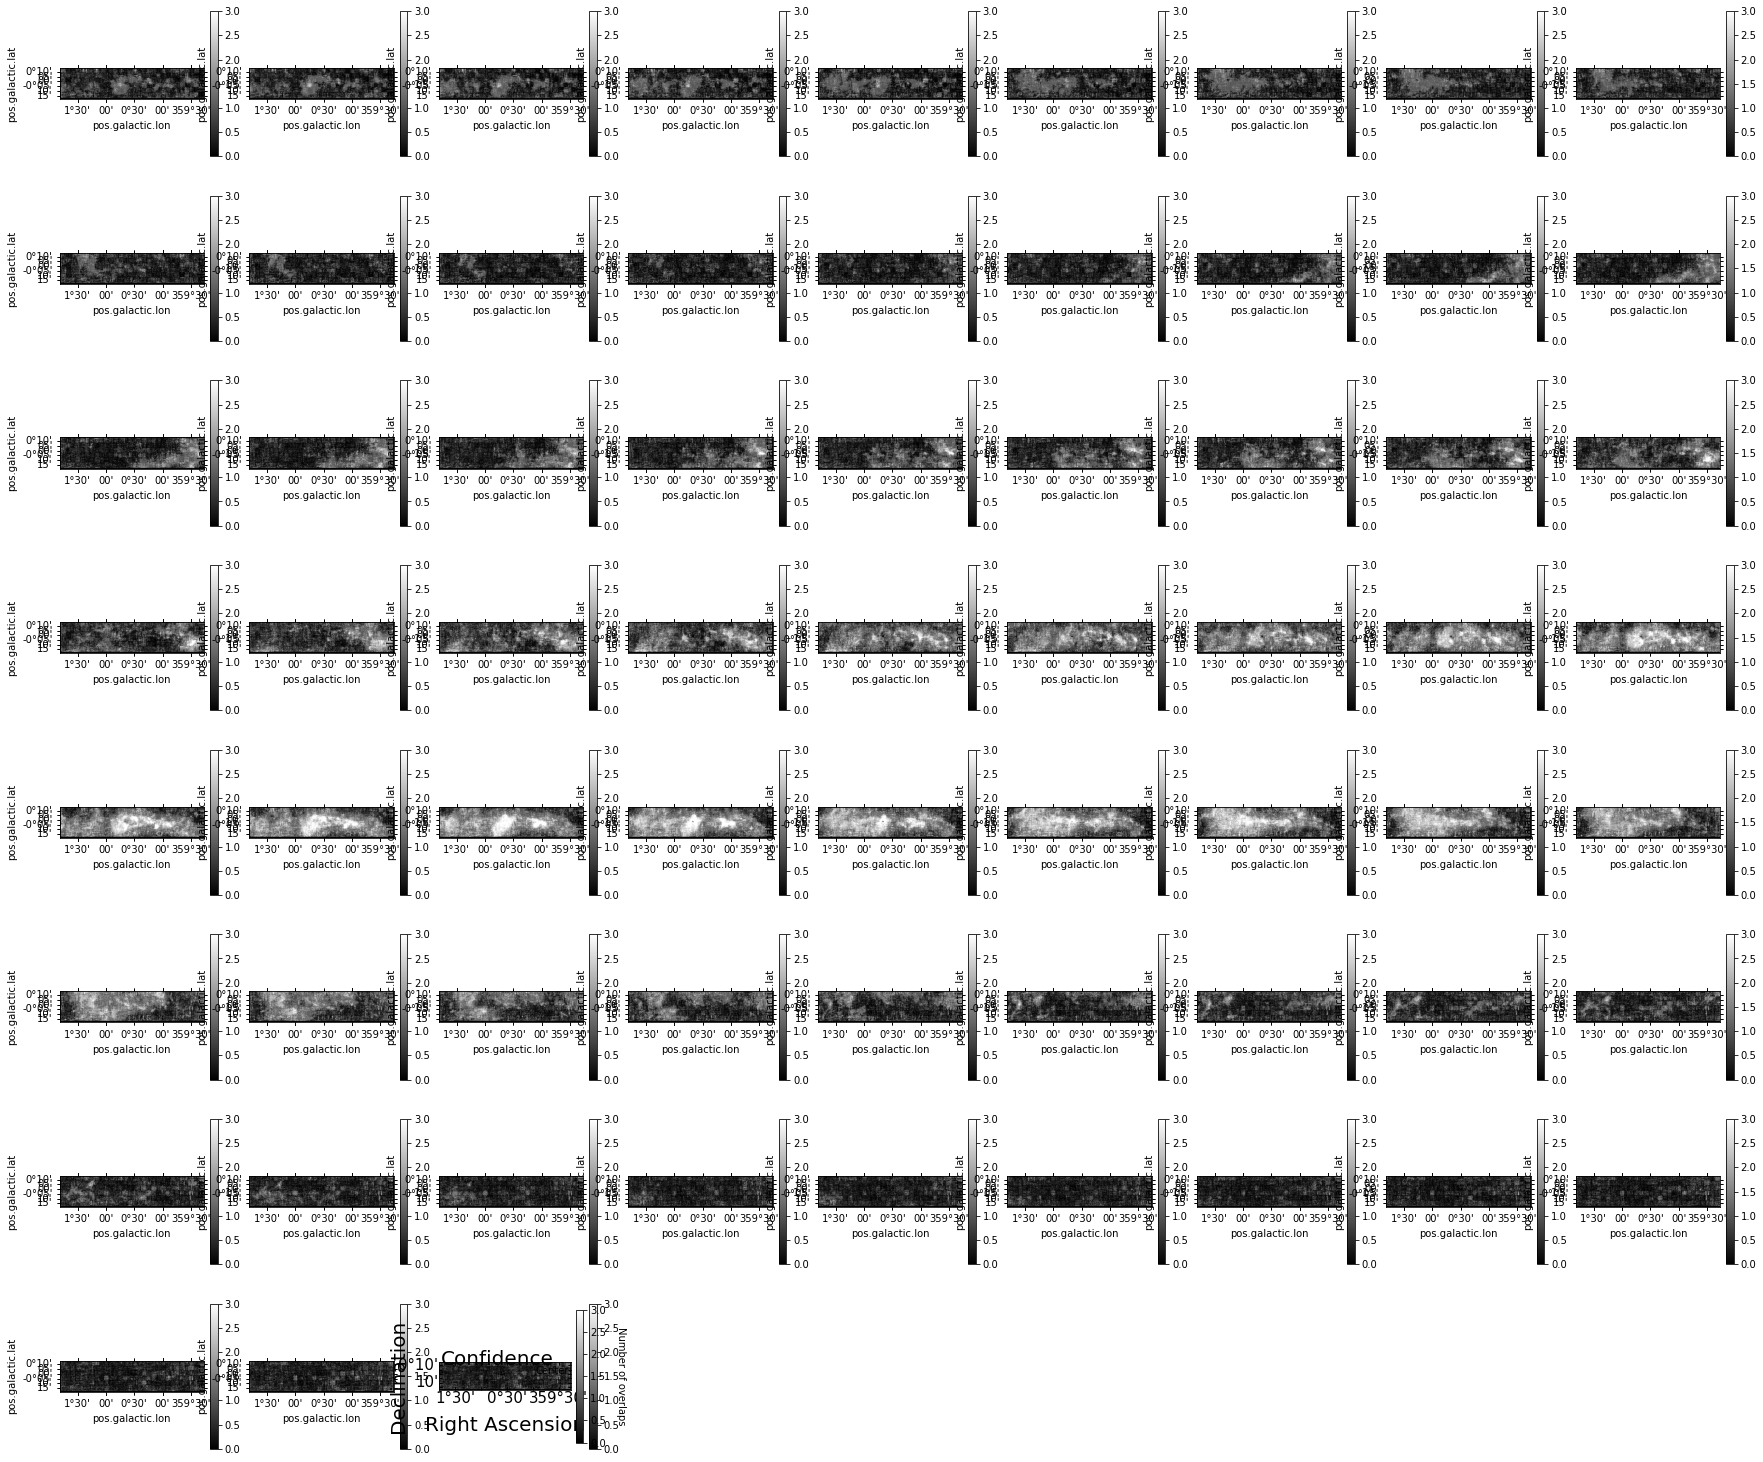

In [4]:
#Create a mask for all the cubes. 

###################No #If there is another cube that shares at least 67% of the structure, a structure is not to be masked.

#If there are multiple pixels that have greater than 3 sigma emission we will keep them (at most  (1-.95)**2 chance of incorrect label)

#Assign greater confidence to more overlaps


paths = pylab.array(['cmz_HCOp.cube.K-kms.pbcor.fits',
                     'cmz_HCN.cube.reproject.K-kms.pbcor.fits',
                     'cmz_H13CN.cube.reproject.K-kms.pbcor.fits',
                     'cmz_H13COp.cube.reproject.K-kms.pbcor.fits'])

FP = pylab.array(['CMZ_3mm_HCO+.fits','CMZ_3mm_HCN.fits','CMZ_3mm_H13CN.fits','CMZ_3mm_H13CO+.fits' ])





SCWs=[]
cds=[]
Ns = [] #get sigmas for all cubes


#Find noises for first cubes
for i in range(len(FP)):
    sc = SpectralCube.read(paths[i])#FP[i])  
    
    sc_kms = sc.with_spectral_unit(u.km/u.s,velocity_convention="radio") # Change units from Hz to km/s
    
    sc_slab = sc_kms.spectral_slab(-800. *u.km / u.s, 1000. *u.km / u.s)  # Crop out velocities we don't care about    
    sc_slab.allow_huge_operations=True    
    
    sc_K_kms = sc_slab.to(u.K)
    
    scW = sc_K_kms.wcs[:][:][0]

    #Find Noise 
    Np1 = SkyCoord('01d31m00s', '00d00m00s', frame='galactic')#These are away from the sources
    Np2 = SkyCoord('01d30m00s', '00d10m00s', frame='galactic')
    NraDP1 = [int(scW.world_to_pixel(Np1)[0]),int(scW.world_to_pixel(Np1)[1])]
    NraDP2 = [int(scW.world_to_pixel(Np2)[0]),int(scW.world_to_pixel(Np2)[1])]
    
        
    
    no = 0
    m=0
    while(True):

        Q = sc_K_kms[int(len(sc_K_kms)-no):len(sc_K_kms),:,:]#NraDP1[1]:NraDP2[1],NraDP1[0]:NraDP2[0]] # Make a subcube away from the signals
        Nsc1 = Q.unmasked_copy()


        bp = np.where(Nsc1.hdu.data<0)

        Nsc1.hdu.data[bp]=np.nan
        #Find StandardDev of this noise cube
        #m=Nsc1.std(axis=0)/u.K
        m=Nsc1.std()/u.K
        
        no+=1
        if(float(np.nanmax(m))!=0.0 and str(float(np.nanmax(m))) != str(np.nan)):
            print(float(np.nanmax(m)),str(float(np.nanmax(m))), str(np.nan),paths[i])
            break
            
    print(np.shape(m),np.shape(Nsc1))
    
    Ns.append(m)
    
#Find noises for pre-masked cubes

'''
for i in range(len(FP)-3,len(FP)):
    sc = SpectralCube.read(FP[i])  
    
    sc_kms = sc.with_spectral_unit(u.km/u.s,velocity_convention="radio") # Change units from Hz to km/s
    
    sc_slab = sc_kms.spectral_slab(-500. *u.km / u.s, 1000. *u.km / u.s)  # Crop out velocities we don't care about    
    sc_slab.allow_huge_operations=True    
    
    sc_K_kms = sc_slab.to(u.K)
    
    scW = sc_K_kms.wcs[:][:][0]

    #Find Noise. Should be the minimum value since it must be at least 3 sigma to be unmasked
    
    Nsc1 = sc_K_kms.unmasked_copy()
    
    
    bp = np.where(Nsc1.hdu.data<=0)
    
    Nsc1.hdu.data[bp]=np.nan
    m=np.nanmin(Nsc1)/u.K
    print(m,np.shape(Nsc1))
    Ns.append(m)
'''  
    
#print(Ns)

for i in range(len(paths)):
    cube=SpectralCube.read(paths[i])
    #print(cube.max(axis=0)[0][0]/u.K,Ns[i][0][0])
    #spatial_mask = cube.max(axis=0)/u.K > 3*Ns[i]        
    
    #cubeM = cube.with_mask(spatial_mask)
    #print(np.shape(cube),np.shape(cubeM))
    cd = cube.hdu.data
    cds.append(cd)
    print(len(cds))
    SCWs.append(cube.wcs[:][:][0])

Confidences=cds[0]

pix = np.where(Confidences != 0)
Confidences[pix] = 0 
#print(Confidences.shape)
print(len(paths),len(FP),len(cds),len(Ns))
for i in range(len(cds)):
    print(cds[i].shape)
for i in range(len(cds)):
    
    GP = np.where(cds[i]>Ns[i]*1)#No abs for only emission
    print(np.shape(GP),len(Confidences))
    
    Confidences[GP]+=1

print(Confidences.shape)


   
print(Confidences.shape)

#Create a plot of all the confidence values

fig1 = pylab.figure(1,figsize=(30,30))


######Moment 0 and Max map
#print(SCWs[0])
#print(Confidences.shape)0
for n in np.arange(0,int(len(Confidences)/5)):   
    
    # Now we loop through each slice (averaged channels) 
    #ax = pylab.subplot(5,5,n+1,projection=wcsU) # We plot them in a grid    
    ax = pylab.subplot(9,9,n+1,projection=SCWs[0]) # We plot them in a grid    
    #im = pylab.imshow(SC_CM.hdu.data[n],cmap='gray',vmin=0,vmax=m*8)
    RA = ax.coords[0]                                                                  # 
    Dec = ax.coords[1]
    im = pylab.imshow(np.nanmean(Confidences[n*5:5*n+5],axis=0),cmap='gray',vmin=0,vmax=3)
    cb=pylab.colorbar(im,fraction=0.046,pad=0.04)  
    
'''
ax = pylab.subplot(1,1,1,projection=SCWs[0]) 
RA = ax.coords[0]                                                                  # 
Dec = ax.coords[1]
im = pylab.imshow(Confidences[int(len(Confidences)*.5)],cmap='rainbow')
'''
center = SkyCoord(l=359.94487501*u.degree,b=-00.04391769*u.degree, frame='galactic')
y,x = [int(SCWs[0].world_to_pixel(center)[0]),int(SCWs[0].world_to_pixel(center)[1])]
pylab.plot(y,x,'+',ms=7,mec='black',mfc='black',mew=2,alpha=.5)
pylab.annotate("Center",(y,x+16))
RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3) 
RA.set_ticklabel(exclude_overlapping=True) 
Dec.set_ticklabel(exclude_overlapping=True)                                                                                     
pylab.xlabel('Right Ascension',fontsize=20,labelpad=1)                               
pylab.ylabel('Declination',fontsize=20,labelpad=0)
ax.tick_params(axis = 'both', which = 'major', labelsize = 15)    
cb=pylab.colorbar(im,fraction=0.046,pad=0.04)                                     
cb.set_label(label='Number of overlaps',fontsize=10,rotation=270,labelpad=20) 
cb.ax.tick_params(which = 'major', labelsize = 10)   
pylab.annotate(s='Confidence',fontsize=20,xy=(0.02,0.91),xycoords="axes fraction")  


np.save('Confidence_data',Confidences)
np.save('Noises_K',Ns)

#Define common structures

#for i in range(len(paths)):


In [5]:
#HCO+

from astropy.io.fits import getdata
from astropy import wcs


path = 'CMZ_3mm_HCO+.fits'

sc = SpectralCube.read(path)  


scW = sc.wcs[:][:][0]


#Find Noise 
Np1 = SkyCoord('01d31m00s', '00d00m00s', frame='galactic')#These are away from the sources
Np2 = SkyCoord('01d30m00s', '00d10m00s', frame='galactic')
NraDP1 = [int(scW.world_to_pixel(Np1)[0]),int(scW.world_to_pixel(Np1)[1])]
NraDP2 = [int(scW.world_to_pixel(Np2)[0]),int(scW.world_to_pixel(Np2)[1])]
Nsc1 = sc[:,NraDP1[1]:NraDP2[1],NraDP1[0]:NraDP2[0]] # Make a subcube away from the signals
#Find StandardDev of this noise cube
m1=Nsc1.std()/u.K
print(m1)

#Make subcube
 
cen_p1 = SkyCoord('00h47m34.034s', '-25d17m29.68s', frame='icrs')
cen_p2 = SkyCoord('00h47m32.234s', '-25d17m09.68s', frame='icrs')

scP = SpectralCube.read(path)
cube = scP.with_spectral_unit(u.km/u.s,velocity_convention="radio")
scW = cube.wcs[:][:][0]


z,x,y = pylab.where(cube.hdu.data==np.nanmax(cube.hdu.data))

#print(m1,subcube[:,int(x)-5:int(x)+5,int(y)-5:int(y)+5],data.shape)

d = astrodendro.Dendrogram.compute(cube.hdu.data[int(z)-15:int(z)+15,:,:],wcs=wcs,min_value=m1*5,min_delta=m1)
v = d.viewer()
v.show()



0.1069265604019165


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [ ]:
#HCN 4-3


from astropy.io.fits import getdata
from astropy import wcs


path = 'CMZ_3mm_HCN.fits'

sc = SpectralCube.read(path)  


scW = sc.wcs[:][:][0]

#Find Noise 
Np1 = SkyCoord('00h47m34.3s', '-25d17m11s', frame='icrs')#These are away from the clusters
Np2 = SkyCoord('00h47m34.0s', '-25d17m10s', frame='icrs')
NraDP1 = [int(scW.world_to_pixel(Np1)[0]),int(scW.world_to_pixel(Np1)[1])]
NraDP2 = [int(scW.world_to_pixel(Np2)[0]),int(scW.world_to_pixel(Np2)[1])]
Nsc1 = sc[:,NraDP1[1]:NraDP2[1],NraDP1[0]:NraDP2[0]] # Make a subcube away from the signals
#Find StandardDev of this noise cube
m1=Nsc1.std()/u.K

print(m1)

#Make subcube
 
cen_p1 = SkyCoord('00h47m34.034s', '-25d17m29.68s', frame='icrs')
cen_p2 = SkyCoord('00h47m32.234s', '-25d17m09.68s', frame='icrs')

scP = SpectralCube.read(path)
scN = scP.with_spectral_unit(u.km/u.s,velocity_convention="radio")
scW = scN.wcs[:][:][0]

raDP1 = [int(scW.world_to_pixel(cen_p1)[0]),int(scW.world_to_pixel(cen_p1)[1])]
raDP2 = [int(scW.world_to_pixel(cen_p2)[0]),int(scW.world_to_pixel(cen_p2)[1])]
subcube = scN[:,raDP1[1]:raDP2[1],raDP1[0]:raDP2[0]] # Make a subcube

wcs = subcube.wcs

z,x,y = pylab.where(subcube.hdu.data==np.nanmax(subcube.hdu.data))

#print(m1,subcube[:,int(x)-5:int(x)+5,int(y)-5:int(y)+5],data.shape)

d = astrodendro.Dendrogram.compute(subcube.hdu.data[int(z)-10:int(z)+10,:,:],wcs=wcs,min_value=m1*6,min_delta=m1)
v = d.viewer()
v.show()


In [ ]:
#H13CN 4-3


path = 'CMZ_3mm_H13CN.fits'

sc = SpectralCube.read(path)  


scW = sc.wcs[:][:][0]

#Find Noise 
Np1 = SkyCoord('00h47m34.3s', '-25d17m11s', frame='icrs')#These are away from the clusters
Np2 = SkyCoord('00h47m34.0s', '-25d17m10s', frame='icrs')
NraDP1 = [int(scW.world_to_pixel(Np1)[0]),int(scW.world_to_pixel(Np1)[1])]
NraDP2 = [int(scW.world_to_pixel(Np2)[0]),int(scW.world_to_pixel(Np2)[1])]
Nsc1 = sc[:,NraDP1[1]:NraDP2[1],NraDP1[0]:NraDP2[0]] # Make a subcube away from the signals
#Find StandardDev of this noise cube
m1=Nsc1.std()/u.K

print(m1)

#Make subcube
 
cen_p1 = SkyCoord('00h47m34.034s', '-25d17m29.68s', frame='icrs')
cen_p2 = SkyCoord('00h47m32.234s', '-25d17m09.68s', frame='icrs')

scP = SpectralCube.read(path)
scN = scP.with_spectral_unit(u.km/u.s,velocity_convention="radio")
scW = scN.wcs[:][:][0]

raDP1 = [int(scW.world_to_pixel(cen_p1)[0]),int(scW.world_to_pixel(cen_p1)[1])]
raDP2 = [int(scW.world_to_pixel(cen_p2)[0]),int(scW.world_to_pixel(cen_p2)[1])]
subcube = scN[:,raDP1[1]:raDP2[1],raDP1[0]:raDP2[0]] # Make a subcube

wcs = subcube.wcs

z,x,y = pylab.where(subcube.hdu.data==np.nanmax(subcube.hdu.data))

print(m1,subcube[:,int(x)-5:int(x)+5,int(y)-5:int(y)+5])

d = astrodendro.Dendrogram.compute(subcube.hdu.data[int(z)-10:int(z)+10,:,:],wcs=wcs,min_value=m1*3,min_delta=m1/3)
v = d.viewer()
v.show()

In [ ]:
#HCN_J1-0



path = 'HCN_J1-0.cube.fits'

sc = SpectralCube.read(path)  


scW = sc.wcs[:][:][0]

#Find Noise 
Np1 = SkyCoord('00h47m34.3s', '-25d17m11s', frame='icrs')#These are away from the clusters
Np2 = SkyCoord('00h47m34.0s', '-25d17m10s', frame='icrs')
NraDP1 = [int(scW.world_to_pixel(Np1)[0]),int(scW.world_to_pixel(Np1)[1])]
NraDP2 = [int(scW.world_to_pixel(Np2)[0]),int(scW.world_to_pixel(Np2)[1])]
Nsc1 = sc[:,NraDP1[1]:NraDP2[1],NraDP1[0]:NraDP2[0]] # Make a subcube away from the signals
#Find StandardDev of this noise cube
m1=Nsc1.std()*u.beam/u.Jy

print(m1)

#Make subcube
 
cen_p1 = SkyCoord('00h47m34.034s', '-25d17m29.68s', frame='icrs')
cen_p2 = SkyCoord('00h47m32.234s', '-25d17m09.68s', frame='icrs')

scP = SpectralCube.read(path)
scN = scP.with_spectral_unit(u.km/u.s,velocity_convention="radio")
scW = scN.wcs[:][:][0]

raDP1 = [int(scW.world_to_pixel(cen_p1)[0]),int(scW.world_to_pixel(cen_p1)[1])]
raDP2 = [int(scW.world_to_pixel(cen_p2)[0]),int(scW.world_to_pixel(cen_p2)[1])]
subcube = scN[:,raDP1[1]:raDP2[1],raDP1[0]:raDP2[0]] # Make a subcube

wcs = subcube.wcs

z,x,y = pylab.where(subcube.hdu.data==np.nanmax(subcube.hdu.data))

print(m1,subcube[:,int(x)-5:int(x)+5,int(y)-5:int(y)+5])

d = astrodendro.Dendrogram.compute(subcube.hdu.data[int(z)-10:int(z)+10,:,:],wcs=wcs,min_value=m1*5,min_delta=m1)
v = d.viewer()
v.show()


In [ ]:
#HCO+_J1-0

path = 'HCOp_J1-0.cube.fits'

sc = SpectralCube.read(path)  


scW = sc.wcs[:][:][0]

#Find Noise 
Np1 = SkyCoord('00h47m34.3s', '-25d17m11s', frame='icrs')#These are away from the clusters
Np2 = SkyCoord('00h47m34.0s', '-25d17m10s', frame='icrs')
NraDP1 = [int(scW.world_to_pixel(Np1)[0]),int(scW.world_to_pixel(Np1)[1])]
NraDP2 = [int(scW.world_to_pixel(Np2)[0]),int(scW.world_to_pixel(Np2)[1])]
Nsc1 = sc[:,NraDP1[1]:NraDP2[1],NraDP1[0]:NraDP2[0]] # Make a subcube away from the signals
#Find StandardDev of this noise cube
m1=Nsc1.std()*u.beam/u.Jy

print(m1)

#Make subcube
 
cen_p1 = SkyCoord('00h47m34.034s', '-25d17m29.68s', frame='icrs')
cen_p2 = SkyCoord('00h47m32.234s', '-25d17m09.68s', frame='icrs')

scP = SpectralCube.read(path)
scN = scP.with_spectral_unit(u.km/u.s,velocity_convention="radio")
scW = scN.wcs[:][:][0]

raDP1 = [int(scW.world_to_pixel(cen_p1)[0]),int(scW.world_to_pixel(cen_p1)[1])]
raDP2 = [int(scW.world_to_pixel(cen_p2)[0]),int(scW.world_to_pixel(cen_p2)[1])]
subcube = scN[:,raDP1[1]:raDP2[1],raDP1[0]:raDP2[0]] # Make a subcube

wcs = subcube.wcs

z,x,y = pylab.where(subcube.hdu.data==np.nanmax(subcube.hdu.data))

print(m1,subcube[:,int(x)-5:int(x)+5,int(y)-5:int(y)+5])

d = astrodendro.Dendrogram.compute(subcube.hdu.data[int(z)-10:int(z)+10,:,:],wcs=wcs,min_value=m1*5,min_delta=m1)
v = d.viewer()
v.show()

In [ ]:
#H13CO+_J1-0

path = 'H13CO_Plus_1_0.fits'

sc = SpectralCube.read(path)  


scW = sc.wcs[:][:][0]

#Find Noise 
Np1 = SkyCoord('00h47m34.3s', '-25d17m11s', frame='icrs')#These are away from the clusters
Np2 = SkyCoord('00h47m34.0s', '-25d17m10s', frame='icrs')
NraDP1 = [int(scW.world_to_pixel(Np1)[0]),int(scW.world_to_pixel(Np1)[1])]
NraDP2 = [int(scW.world_to_pixel(Np2)[0]),int(scW.world_to_pixel(Np2)[1])]
Nsc1 = sc[:,NraDP1[1]:NraDP2[1],NraDP1[0]:NraDP2[0]] # Make a subcube away from the signals
#Find StandardDev of this noise cube
m1=Nsc1.std()*u.beam/u.Jy

print(m1)

#Make subcube
 
cen_p1 = SkyCoord('00h47m34.034s', '-25d17m29.68s', frame='icrs')
cen_p2 = SkyCoord('00h47m32.234s', '-25d17m09.68s', frame='icrs')

scP = SpectralCube.read(path)
scN = scP.with_spectral_unit(u.km/u.s,velocity_convention="radio")
scW = scN.wcs[:][:][0]

raDP1 = [int(scW.world_to_pixel(cen_p1)[0]),int(scW.world_to_pixel(cen_p1)[1])]
raDP2 = [int(scW.world_to_pixel(cen_p2)[0]),int(scW.world_to_pixel(cen_p2)[1])]
subcube = scN[:,raDP1[1]:raDP2[1],raDP1[0]:raDP2[0]] # Make a subcube

wcs = subcube.wcs

z,x,y = pylab.where(subcube.hdu.data==np.nanmax(subcube.hdu.data))

print(m1,subcube[:,int(x)-5:int(x)+5,int(y)-5:int(y)+5])

d = astrodendro.Dendrogram.compute(subcube.hdu.data[int(z)-10:int(z)+10,:,:],wcs=wcs,min_value=m1*4,min_delta=m1/2)
v = d.viewer()
v.show()

In [ ]:
#SiO_J2-1

path = "SiO_2_1.fits"

sc = SpectralCube.read(path)  


scW = sc.wcs[:][:][0]

#Find Noise 
Np1 = SkyCoord('00h47m34.3s', '-25d17m11s', frame='icrs')#These are away from the clusters
Np2 = SkyCoord('00h47m34.0s', '-25d17m10s', frame='icrs')
NraDP1 = [int(scW.world_to_pixel(Np1)[0]),int(scW.world_to_pixel(Np1)[1])]
NraDP2 = [int(scW.world_to_pixel(Np2)[0]),int(scW.world_to_pixel(Np2)[1])]
Nsc1 = sc[:,NraDP1[1]:NraDP2[1],NraDP1[0]:NraDP2[0]] # Make a subcube away from the signals
#Find StandardDev of this noise cube
m1=Nsc1.std()*u.beam/u.Jy

print(m1)

#Make subcube
 
cen_p1 = SkyCoord('00h47m34.034s', '-25d17m29.68s', frame='icrs')
cen_p2 = SkyCoord('00h47m32.234s', '-25d17m09.68s', frame='icrs')

scP = SpectralCube.read(path)
scN = scP.with_spectral_unit(u.km/u.s,velocity_convention="radio")
scW = scN.wcs[:][:][0]

raDP1 = [int(scW.world_to_pixel(cen_p1)[0]),int(scW.world_to_pixel(cen_p1)[1])]
raDP2 = [int(scW.world_to_pixel(cen_p2)[0]),int(scW.world_to_pixel(cen_p2)[1])]
subcube = scN[:,raDP1[1]:raDP2[1],raDP1[0]:raDP2[0]] # Make a subcube

wcs = subcube.wcs

z,x,y = pylab.where(subcube.hdu.data==np.nanmax(subcube.hdu.data))

print(m1,subcube[:,int(x)-5:int(x)+5,int(y)-5:int(y)+5])

d = astrodendro.Dendrogram.compute(subcube.hdu.data[int(z)-10:int(z)+10,:,:],wcs=wcs,min_value=m1*,min_delta=m1)
v = d.viewer()
v.show()

In [7]:
#H13CN_J1-0

path = 'H13CN_J1-0.cube.fits'

sc = SpectralCube.read(path)  


scW = sc.wcs[:][:][0]

#Find Noise 
Np1 = SkyCoord('00h47m34.3s', '-25d17m11s', frame='icrs')#These are away from the clusters
Np2 = SkyCoord('00h47m34.0s', '-25d17m10s', frame='icrs')
NraDP1 = [int(scW.world_to_pixel(Np1)[0]),int(scW.world_to_pixel(Np1)[1])]
NraDP2 = [int(scW.world_to_pixel(Np2)[0]),int(scW.world_to_pixel(Np2)[1])]
Nsc1 = sc[:,NraDP1[1]:NraDP2[1],NraDP1[0]:NraDP2[0]] # Make a subcube away from the signals
#Find StandardDev of this noise cube
m1=Nsc1.std()*u.beam/u.Jy

print(m1)

#Make subcube
 
cen_p1 = SkyCoord('00h47m34.034s', '-25d17m29.68s', frame='icrs')
cen_p2 = SkyCoord('00h47m32.234s', '-25d17m09.68s', frame='icrs')

scP = SpectralCube.read(path)
scN = scP.with_spectral_unit(u.km/u.s,velocity_convention="radio")
scW = scN.wcs[:][:][0]

raDP1 = [int(scW.world_to_pixel(cen_p1)[0]),int(scW.world_to_pixel(cen_p1)[1])]
raDP2 = [int(scW.world_to_pixel(cen_p2)[0]),int(scW.world_to_pixel(cen_p2)[1])]
subcube = scN[:,raDP1[1]:raDP2[1],raDP1[0]:raDP2[0]] # Make a subcube

wcs = subcube.wcs

z,x,y = pylab.where(subcube.hdu.data==np.nanmax(subcube.hdu.data))

print(m1,subcube[:,int(x)-5:int(x)+5,int(y)-5:int(y)+5])

d = astrodendro.Dendrogram.compute(subcube.hdu.data[int(z)-10:int(z)+10,:,:],wcs=wcs,min_value=m1*4,min_delta=m1)
v = d.viewer()
v.show()

0.0001903346856124699
0.0001903346856124699 SpectralCube with shape=(180, 10, 10) and unit=Jy / beam:
 n_x:     10  type_x: RA---SIN  unit_x: deg    range:    11.888677 deg:   11.888763 deg
 n_y:     10  type_y: DEC--SIN  unit_y: deg    range:   -25.287709 deg:  -25.287632 deg
 n_s:    180  type_s: VRAD      unit_s: km / s  range:      -27.401 km / s:     579.633 km / s


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [3]:
#CO_J3-2

path = 'ngc253_co32_hires_common.fits'

sc = SpectralCube.read(path)  


scW = sc.wcs[:][:][0]

#Find Noise 
Np1 = SkyCoord('00h47m34.3s', '-25d17m11s', frame='icrs')#These are away from the clusters
Np2 = SkyCoord('00h47m34.0s', '-25d17m10s', frame='icrs')
NraDP1 = [int(scW.world_to_pixel(Np1)[0]),int(scW.world_to_pixel(Np1)[1])]
NraDP2 = [int(scW.world_to_pixel(Np2)[0]),int(scW.world_to_pixel(Np2)[1])]
Nsc1 = sc[:,NraDP1[1]:NraDP2[1],NraDP1[0]:NraDP2[0]] # Make a subcube away from the signals
#Find StandardDev of this noise cube
m1=Nsc1.std()*u.beam/u.Jy

print(m1)

#Make subcube
 
cen_p1 = SkyCoord('00h47m34.034s', '-25d17m29.68s', frame='icrs')
cen_p2 = SkyCoord('00h47m32.234s', '-25d17m09.68s', frame='icrs')

scP = SpectralCube.read(path)
scN = scP.with_spectral_unit(u.km/u.s,velocity_convention="radio")
scW = scN.wcs[:][:][0]

raDP1 = [int(scW.world_to_pixel(cen_p1)[0]),int(scW.world_to_pixel(cen_p1)[1])]
raDP2 = [int(scW.world_to_pixel(cen_p2)[0]),int(scW.world_to_pixel(cen_p2)[1])]
subcube = scN[:,raDP1[1]:raDP2[1],raDP1[0]:raDP2[0]] # Make a subcube

wcs = subcube.wcs

z,x,y = pylab.where(subcube.hdu.data==np.nanmax(subcube.hdu.data))

print(m1,subcube[:,int(x)-5:int(x)+5,int(y)-5:int(y)+5])

d = astrodendro.Dendrogram.compute(subcube.hdu.data[int(z)-10:int(z)+10,:,:],wcs=wcs,min_value=m1*5,min_delta=m1)
v = d.viewer()
v.show()

0.010561508126556873
0.010561508126556873 SpectralCube with shape=(81, 10, 10) and unit=Jy / beam:
 n_x:     10  type_x: RA---SIN  unit_x: deg    range:    11.888679 deg:   11.888773 deg
 n_y:     10  type_y: DEC--SIN  unit_y: deg    range:   -25.287710 deg:  -25.287625 deg
 n_s:     81  type_s: VRAD      unit_s: km / s  range:       43.000 km / s:     443.000 km / s


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …